In [1]:
import numpy as np
import pandas as pd

import os
import json
from pathlib import Path

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
# from tensorflow.keras import layers 
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Reshape
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers

import matplotlib.pyplot as plt
from matplotlib import colors

In [2]:
data_path = Path('./kaggle_input/')
training_path = data_path / 'training'      # 400 X-train ('train'), y-train('test') input-output pairs
evaluation_path = data_path / 'evaluation'  # 400
test_path = data_path / 'test'              # 100 pairs X-train ('train') (input-output),
                                            #           y-train (input only) pairs

training_tasks_files = sorted(os.listdir(training_path))#[1:]
eval_tasks_files = sorted(os.listdir(evaluation_path))
test_task_files = sorted(os.listdir(test_path))

In [3]:
training_tasks_files

['007bbfb7.json',
 '00d62c1b.json',
 '017c7c7b.json',
 '025d127b.json',
 '045e512c.json',
 '0520fde7.json',
 '05269061.json',
 '05f2a901.json',
 '06df4c85.json',
 '08ed6ac7.json',
 '09629e4f.json',
 '0962bcdd.json',
 '0a938d79.json',
 '0b148d64.json',
 '0ca9ddb6.json',
 '0d3d703e.json',
 '0dfd9992.json',
 '0e206a2e.json',
 '10fcaaa3.json',
 '11852cab.json',
 '1190e5a7.json',
 '137eaa0f.json',
 '150deff5.json',
 '178fcbfb.json',
 '1a07d186.json',
 '1b2d62fb.json',
 '1b60fb0c.json',
 '1bfc4729.json',
 '1c786137.json',
 '1caeab9d.json',
 '1cf80156.json',
 '1e0a9b12.json',
 '1e32b0e9.json',
 '1f0c79e5.json',
 '1f642eb9.json',
 '1f85a75f.json',
 '1f876c06.json',
 '1fad071e.json',
 '2013d3e2.json',
 '2204b7a8.json',
 '22168020.json',
 '22233c11.json',
 '2281f1f4.json',
 '228f6490.json',
 '22eb0ac0.json',
 '234bbc79.json',
 '23581191.json',
 '239be575.json',
 '23b5c85d.json',
 '253bf280.json',
 '25d487eb.json',
 '25d8a9c8.json',
 '25ff71a9.json',
 '264363fd.json',
 '272f95fa.json',
 '27a28665

In [4]:
def load_files(path):
    path_files = sorted(os.listdir(path))
    tasks = []
    for task_file in path_files:
        with open(str(path / task_file), 'r') as f:
            task = json.load(f)
            tasks.append(task)
    return tasks

In [5]:
training_tasks = load_files(training_path)
test_tasks = load_files(test_path)
evaluation_tasks = load_files(evaluation_path)

 
 ---
 ---

### 1. Create Train - Test - Split

In [6]:
Xs_test, ys_test, Xs_train, ys_train = [], [], [], []

for task in training_tasks:
    X_test, y_test, X_train, y_train = [], [], [], []

    for pair in task["test"]:
        X_test.append(pair["input"])
        y_test.append(pair["output"])      ### to be predicted !!!

    for pair in task["train"]:
        X_train.append(pair["input"])
        y_train.append(pair["output"])
    
    Xs_test.append(X_test)
    ys_test.append(y_test)
    Xs_train.append(X_train)
    ys_train.append(y_train)

In [7]:
len(Xs_train), len(ys_train), len(Xs_test), len(ys_test)

(400, 400, 400, 400)

---
---

very basic model from week 9
- instead of assigning to m --> make a fct 
- input_shape needs to be dependent on each task shape --> np.array(Xs_train[0][0]).shape
- kernel_size ???
- put into a loop for task in Xs_train

In [8]:
def basic_model(input_shape, output_shape, kernel):
    m = Sequential([
        Conv2D(16, 
               kernel_size = kernel, 
               padding = 'same', 
               activation = 'relu',
               input_shape = input_shape),         
        MaxPooling2D(pool_size = (3, 3),
                     strides = (2, 2),
                     padding = "same"),
        Conv2D(32,
               kernel_size = kernel,
               padding='same',
               activation='relu'),
        MaxPooling2D(pool_size=(3, 3),
                     strides=(2, 2),
                     padding="same"),
        Conv2D(64,
               kernel_size = kernel,
               padding='same',
               activation='relu'),
        MaxPooling2D(pool_size=(3, 3),
                     strides=(2, 2),
                     padding="same"),
        Dropout(0.2),
        Flatten(),
        Dense(128,
              activation='relu'),
        Dense(output_shape,
              activation='softmax')
    ])
    return m

# -------------------------------------------------------------------------------------------------------------------------- 1.  all 1301 inputs as one --------------------------------------------------------------------------------------------------------------------------------

In [9]:

li=[]
for X_train in Xs_train:
    for e in X_train:
        e = np.array(e)
        e = np.pad(e, [(0, 30-e.shape[0]), (0, 30-e.shape[1])], mode='constant')
        li.append(e)
X_train_big = np.array(li)

In [10]:
X_train_big.shape

(1301, 30, 30)

In [11]:
X_train_big = X_train_big.reshape(1301,30,30, 1)
X_train_big.shape

(1301, 30, 30, 1)

In [12]:
#X_train_big = X_train_big / 10
#X_train_big

In [13]:
li=[]
for y_train in ys_train:
    for e in y_train:
        e = np.array(e)
        e = np.pad(e, [(0, 30-e.shape[0]), (0, 30-e.shape[1])], mode='constant')
        li.append(e)
y_train_big = np.array(li)

In [14]:
y_train_big.shape

(1301, 30, 30)

In [15]:
y_train_big = y_train_big.reshape(y_train_big.shape[0],-1)     

In [16]:
y_train_big.shape

(1301, 900)

In [17]:
#y_train_big = y_train_big #/ 10

In [18]:
y_cat = to_categorical(y_train_big)#[0][:10]#.shape

In [19]:
y_cat = y_cat.reshape(y_cat.shape[0],-1)    

In [20]:
y_cat.shape

(1301, 9000)

In [21]:
K.clear_session()   #clean slate

m = basic_model((30,30,1), 9000, 2)
    
m.compile(optimizer='adam', 
          loss='categorical_crossentropy', #### this one needs to be adjusted
          metrics=['accuracy'])  

#callback = keras.callbacks.EarlyStopping(monitor='accuracy',patience=5)

hist = m.fit(X_train_big,
              y_cat,
              epochs=500,               ### this can be much smaller cause each task has only 5 or so inputs???
              batch_size=400,          ### this can be much smaller cause each task has only 5 or so inputs???
              validation_split=0.2) 

Epoch 1/500
3/3 [==============================] - 3s 511ms/step - loss: 8185.8154 - accuracy: 0.0000e+00 - val_loss: 8152.4263 - val_accuracy: 0.0000e+00
Epoch 2/500
3/3 [==============================] - 1s 338ms/step - loss: 8117.3413 - accuracy: 0.0000e+00 - val_loss: 8029.1538 - val_accuracy: 0.0000e+00
Epoch 3/500
3/3 [==============================] - 1s 352ms/step - loss: 7966.1343 - accuracy: 0.0000e+00 - val_loss: 7816.9814 - val_accuracy: 0.0000e+00
Epoch 4/500
3/3 [==============================] - 1s 291ms/step - loss: 7766.5557 - accuracy: 0.0000e+00 - val_loss: 7573.9893 - val_accuracy: 0.0000e+00
Epoch 5/500
3/3 [==============================] - 1s 290ms/step - loss: 7663.7915 - accuracy: 0.0000e+00 - val_loss: 7431.2959 - val_accuracy: 0.0000e+00
Epoch 6/500
3/3 [==============================] - 1s 269ms/step - loss: 7869.6553 - accuracy: 0.0000e+00 - val_loss: 7604.2505 - val_accuracy: 0.0000e+00
Epoch 7/500
3/3 [==============================] - 1s 311ms/step - los

Epoch 52/500
3/3 [==============================] - 1s 250ms/step - loss: 171501984.0000 - accuracy: 0.0000e+00 - val_loss: 72822024.0000 - val_accuracy: 0.0000e+00
Epoch 53/500
3/3 [==============================] - 1s 223ms/step - loss: 192407024.0000 - accuracy: 0.0000e+00 - val_loss: 81291392.0000 - val_accuracy: 0.0000e+00
Epoch 54/500
3/3 [==============================] - 1s 253ms/step - loss: 218949248.0000 - accuracy: 0.0000e+00 - val_loss: 90503696.0000 - val_accuracy: 0.0000e+00
Epoch 55/500
3/3 [==============================] - 1s 228ms/step - loss: 244555856.0000 - accuracy: 0.0000e+00 - val_loss: 100249080.0000 - val_accuracy: 0.0000e+00
Epoch 56/500
3/3 [==============================] - 1s 232ms/step - loss: 274184992.0000 - accuracy: 0.0000e+00 - val_loss: 111218296.0000 - val_accuracy: 0.0000e+00
Epoch 57/500
3/3 [==============================] - 1s 243ms/step - loss: 308151584.0000 - accuracy: 0.0000e+00 - val_loss: 122892504.0000 - val_accuracy: 0.0000e+00
Epoch 5

3/3 [==============================] - 1s 249ms/step - loss: 10437491712.0000 - accuracy: 0.0000e+00 - val_loss: 3053913088.0000 - val_accuracy: 0.0000e+00
Epoch 102/500
3/3 [==============================] - 1s 266ms/step - loss: 11003538432.0000 - accuracy: 0.0000e+00 - val_loss: 3223025664.0000 - val_accuracy: 0.0000e+00
Epoch 103/500
3/3 [==============================] - 1s 245ms/step - loss: 11527245824.0000 - accuracy: 0.0000e+00 - val_loss: 3399361024.0000 - val_accuracy: 0.0000e+00
Epoch 104/500
3/3 [==============================] - 1s 237ms/step - loss: 12301095936.0000 - accuracy: 0.0000e+00 - val_loss: 3584076032.0000 - val_accuracy: 0.0000e+00
Epoch 105/500
3/3 [==============================] - 1s 289ms/step - loss: 12972313600.0000 - accuracy: 0.0000e+00 - val_loss: 3774497280.0000 - val_accuracy: 0.0000e+00
Epoch 106/500
3/3 [==============================] - 1s 266ms/step - loss: 13700846592.0000 - accuracy: 0.0000e+00 - val_loss: 3977828352.0000 - val_accuracy: 0.000

3/3 [==============================] - 1s 250ms/step - loss: 97370161152.0000 - accuracy: 0.0000e+00 - val_loss: 25550123008.0000 - val_accuracy: 0.0000e+00
Epoch 150/500
3/3 [==============================] - 1s 238ms/step - loss: 100530200576.0000 - accuracy: 0.0000e+00 - val_loss: 26465253376.0000 - val_accuracy: 0.0000e+00
Epoch 151/500
3/3 [==============================] - 1s 239ms/step - loss: 104608727040.0000 - accuracy: 0.0000e+00 - val_loss: 27428081664.0000 - val_accuracy: 0.0000e+00
Epoch 152/500
3/3 [==============================] - 1s 233ms/step - loss: 107604606976.0000 - accuracy: 0.0000e+00 - val_loss: 28399200256.0000 - val_accuracy: 0.0000e+00
Epoch 153/500
3/3 [==============================] - 1s 276ms/step - loss: 112203939840.0000 - accuracy: 0.0000e+00 - val_loss: 29391771648.0000 - val_accuracy: 0.0000e+00
Epoch 154/500
3/3 [==============================] - 1s 264ms/step - loss: 116267974656.0000 - accuracy: 0.0000e+00 - val_loss: 30502844416.0000 - val_accu

Epoch 197/500
3/3 [==============================] - 1s 279ms/step - loss: 446964662272.0000 - accuracy: 0.0000e+00 - val_loss: 112419454976.0000 - val_accuracy: 0.0000e+00
Epoch 198/500
3/3 [==============================] - 1s 269ms/step - loss: 457590702080.0000 - accuracy: 0.0000e+00 - val_loss: 115386138624.0000 - val_accuracy: 0.0000e+00
Epoch 199/500
3/3 [==============================] - 1s 246ms/step - loss: 470998581248.0000 - accuracy: 0.0000e+00 - val_loss: 118365937664.0000 - val_accuracy: 0.0000e+00
Epoch 200/500
3/3 [==============================] - 1s 259ms/step - loss: 484697440256.0000 - accuracy: 0.0000e+00 - val_loss: 121364799488.0000 - val_accuracy: 0.0000e+00
Epoch 201/500
3/3 [==============================] - 1s 270ms/step - loss: 497753653248.0000 - accuracy: 0.0000e+00 - val_loss: 124435972096.0000 - val_accuracy: 0.0000e+00
Epoch 202/500
3/3 [==============================] - 1s 288ms/step - loss: 511674810368.0000 - accuracy: 0.0000e+00 - val_loss: 1275802

3/3 [==============================] - 1s 256ms/step - loss: 1369680773120.0000 - accuracy: 0.0000e+00 - val_loss: 334602141696.0000 - val_accuracy: 0.0000e+00
Epoch 245/500
3/3 [==============================] - 1s 252ms/step - loss: 1403057864704.0000 - accuracy: 0.0000e+00 - val_loss: 341870149632.0000 - val_accuracy: 0.0000e+00
Epoch 246/500
3/3 [==============================] - 1s 266ms/step - loss: 1435750236160.0000 - accuracy: 0.0000e+00 - val_loss: 349404856320.0000 - val_accuracy: 0.0000e+00
Epoch 247/500
3/3 [==============================] - 1s 293ms/step - loss: 1456128786432.0000 - accuracy: 0.0000e+00 - val_loss: 356319035392.0000 - val_accuracy: 0.0000e+00
Epoch 248/500
3/3 [==============================] - 1s 271ms/step - loss: 1494030483456.0000 - accuracy: 0.0000e+00 - val_loss: 363543298048.0000 - val_accuracy: 0.0000e+00
Epoch 249/500
3/3 [==============================] - 1s 269ms/step - loss: 1517851246592.0000 - accuracy: 0.0000e+00 - val_loss: 370925338624.00

3/3 [==============================] - 1s 239ms/step - loss: 3343085993984.0000 - accuracy: 0.0000e+00 - val_loss: 802765733888.0000 - val_accuracy: 0.0000e+00
Epoch 292/500
3/3 [==============================] - 1s 235ms/step - loss: 3394363195392.0000 - accuracy: 0.0000e+00 - val_loss: 816023863296.0000 - val_accuracy: 0.0000e+00
Epoch 293/500
3/3 [==============================] - 1s 246ms/step - loss: 3451215413248.0000 - accuracy: 0.0000e+00 - val_loss: 829637656576.0000 - val_accuracy: 0.0000e+00
Epoch 294/500
3/3 [==============================] - 1s 225ms/step - loss: 3525156274176.0000 - accuracy: 0.0000e+00 - val_loss: 843815059456.0000 - val_accuracy: 0.0000e+00
Epoch 295/500
3/3 [==============================] - 1s 280ms/step - loss: 3544375885824.0000 - accuracy: 0.0000e+00 - val_loss: 857828163584.0000 - val_accuracy: 0.0000e+00
Epoch 296/500
3/3 [==============================] - 1s 226ms/step - loss: 3653537890304.0000 - accuracy: 0.0000e+00 - val_loss: 871027376128.00

Epoch 338/500
3/3 [==============================] - 1s 235ms/step - loss: 6996444053504.0000 - accuracy: 0.0000e+00 - val_loss: 1661771317248.0000 - val_accuracy: 0.0000e+00
Epoch 339/500
3/3 [==============================] - 1s 242ms/step - loss: 7085742882816.0000 - accuracy: 0.0000e+00 - val_loss: 1686445096960.0000 - val_accuracy: 0.0000e+00
Epoch 340/500
3/3 [==============================] - 1s 209ms/step - loss: 7188421017600.0000 - accuracy: 0.0000e+00 - val_loss: 1710416723968.0000 - val_accuracy: 0.0000e+00
Epoch 341/500
3/3 [==============================] - 1s 316ms/step - loss: 7281429184512.0000 - accuracy: 0.0000e+00 - val_loss: 1734807388160.0000 - val_accuracy: 0.0000e+00
Epoch 342/500
3/3 [==============================] - 1s 238ms/step - loss: 7401284042752.0000 - accuracy: 0.0000e+00 - val_loss: 1759128190976.0000 - val_accuracy: 0.0000e+00
Epoch 343/500
3/3 [==============================] - 1s 229ms/step - loss: 7506115952640.0000 - accuracy: 0.0000e+00 - val_lo

Epoch 385/500
3/3 [==============================] - 1s 221ms/step - loss: 13031372226560.0000 - accuracy: 0.0000e+00 - val_loss: 3090495832064.0000 - val_accuracy: 0.0000e+00
Epoch 386/500
3/3 [==============================] - 1s 239ms/step - loss: 13262032732160.0000 - accuracy: 0.0000e+00 - val_loss: 3129461440512.0000 - val_accuracy: 0.0000e+00
Epoch 387/500
3/3 [==============================] - 1s 227ms/step - loss: 13393486413824.0000 - accuracy: 0.0000e+00 - val_loss: 3166726782976.0000 - val_accuracy: 0.0000e+00
Epoch 388/500
3/3 [==============================] - 1s 228ms/step - loss: 13599084904448.0000 - accuracy: 0.0000e+00 - val_loss: 3203817275392.0000 - val_accuracy: 0.0000e+00
Epoch 389/500
3/3 [==============================] - 1s 231ms/step - loss: 13736738816000.0000 - accuracy: 0.0000e+00 - val_loss: 3241271361536.0000 - val_accuracy: 0.0000e+00
Epoch 390/500
3/3 [==============================] - 1s 263ms/step - loss: 13951847890944.0000 - accuracy: 0.0000e+00 - 

3/3 [==============================] - 1s 229ms/step - loss: 22315320475648.0000 - accuracy: 0.0000e+00 - val_loss: 5245888888832.0000 - val_accuracy: 0.0000e+00
Epoch 432/500
3/3 [==============================] - 1s 245ms/step - loss: 22522915454976.0000 - accuracy: 0.0000e+00 - val_loss: 5301357510656.0000 - val_accuracy: 0.0000e+00
Epoch 433/500
3/3 [==============================] - 1s 233ms/step - loss: 22765392363520.0000 - accuracy: 0.0000e+00 - val_loss: 5358817378304.0000 - val_accuracy: 0.0000e+00
Epoch 434/500
3/3 [==============================] - 1s 292ms/step - loss: 23091151372288.0000 - accuracy: 0.0000e+00 - val_loss: 5415308361728.0000 - val_accuracy: 0.0000e+00
Epoch 435/500
3/3 [==============================] - 1s 250ms/step - loss: 23322970554368.0000 - accuracy: 0.0000e+00 - val_loss: 5473059733504.0000 - val_accuracy: 0.0000e+00
Epoch 436/500
3/3 [==============================] - 1s 260ms/step - loss: 23435434524672.0000 - accuracy: 0.0000e+00 - val_loss: 5531

3/3 [==============================] - 1s 272ms/step - loss: 35679127994368.0000 - accuracy: 0.0000e+00 - val_loss: 8358039912448.0000 - val_accuracy: 0.0000e+00
Epoch 478/500
3/3 [==============================] - 1s 292ms/step - loss: 36051460554752.0000 - accuracy: 0.0000e+00 - val_loss: 8442365345792.0000 - val_accuracy: 0.0000e+00
Epoch 479/500
3/3 [==============================] - 1s 266ms/step - loss: 36415324815360.0000 - accuracy: 0.0000e+00 - val_loss: 8521390227456.0000 - val_accuracy: 0.0000e+00
Epoch 480/500
3/3 [==============================] - 1s 273ms/step - loss: 36784310321152.0000 - accuracy: 0.0000e+00 - val_loss: 8600179703808.0000 - val_accuracy: 0.0000e+00
Epoch 481/500
3/3 [==============================] - 1s 362ms/step - loss: 37243393671168.0000 - accuracy: 0.0000e+00 - val_loss: 8681511452672.0000 - val_accuracy: 0.0000e+00
Epoch 482/500
3/3 [==============================] - 1s 335ms/step - loss: 37407885885440.0000 - accuracy: 0.0000e+00 - val_loss: 8761

In [22]:
########################

accuracy = m.evaluate(x=X_train_big,y=y_cat,batch_size=32)
print("Accuracy: ",accuracy[1])

41/41 [==============================] - 0s 11ms/step - loss: 37720210538496.0000 - accuracy: 0.0000e+00
Accuracy:  0.0


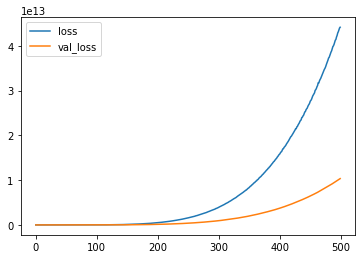

In [23]:
plt.plot(hist.history['loss'],label='loss')
plt.plot(hist.history['val_loss'],label='val_loss')
plt.legend()

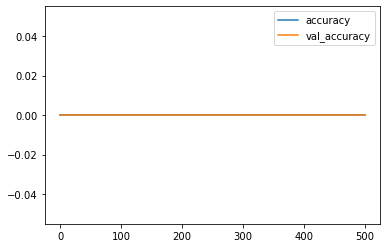

In [24]:
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.legend()

In [25]:
n = np.full((1,30, 30,1), 7)

In [26]:
n.shape

(1, 30, 30, 1)

In [27]:
w = X_train_big[125:126]#.shape

In [28]:
w.shape

(1, 30, 30, 1)

In [29]:
X_train_big[125:126].reshape(1,30,30)

array([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0

In [30]:
pred = m.predict(w)#.reshape(1,30,30)

In [31]:
pred.shape

(1, 9000)

In [32]:
pred.reshape(1,30,30,10)[0][0][0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [33]:
np.argmax(pred.reshape(1,30,30,10)[0][0][0])

0

In [34]:
li=[]
for i in range(30):
    for j in range(30):
        x = np.argmax(pred.reshape(1,30,30,10)[0][i][j]) 
        li.append(x)
new_array = np.array(li).reshape(30,30)

In [35]:
new_array.shape

(30, 30)

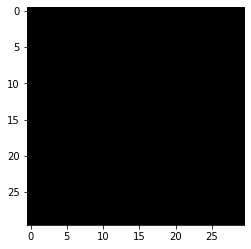

In [36]:
cmap = colors.ListedColormap(
            ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
             '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)
plt.imshow(new_array, cmap=cmap, norm=norm)#.reshape(orig_shape[0],orig_shape[1]) ## Xs_test
#    plt.gray()

In [ ]:
np.argmax(pred)#.shape

In [ ]:
np.rint(pred).shape

# -------------------------------------------------------------------------------------------------------------------------- 2.  loop through all 400 tasks ------------------------------------------------------------------------------------------------------------------------

In [30]:
Xs_train_tasks = []
for X_train in Xs_train:
    li2=[]
    for e in X_train:
        e = np.array(e)
        e = np.pad(e, [(0, 30-e.shape[0]), (0, 30-e.shape[1])], mode='constant')
        li2.append(e)
    li2 = np.array(li2)
    Xs_train_tasks.append(li2)

In [31]:
type(Xs_train_tasks), type(Xs_train_tasks[215])

(list, numpy.ndarray)

In [ ]:
len(Xs_train_tasks), Xs_train_tasks[215].shape

In [32]:
ys_train_tasks = []
for y_train in ys_train:
    li2=[]
    for e in y_train:
        e = np.array(e)
        e = np.pad(e, [(0, 30-e.shape[0]), (0, 30-e.shape[1])], mode='constant')
        li2.append(e)
    li2 = np.array(li2)
    ys_train_tasks.append(li2)

In [33]:
type(ys_train_tasks), type(ys_train_tasks[215])

(list, numpy.ndarray)

In [34]:
len(ys_train_tasks), ys_train_tasks[215].shape

(400, (3, 30, 30))

In [35]:
K.clear_session()   #clean slate

idx = 0
#start = time.time()

for X_train, y_train in zip(Xs_train_tasks, ys_train_tasks):    
    print("TASK " + str(idx + 1))
    
#     X_train = np.array([np.array(xi) for xi in X_train], dtype=object)
    X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2], 1)
    input_shape = X_train.shape[1:]
    
#     y_train = np.array(y_train)
    y_train = y_train.reshape(y_train.shape[0],-1)     
    output_shape = y_train.shape[1]
#     y_tensor = tf.convert_to_tensor(y_train, dtype=tf.int64) 
    
#     X_train = np.asarray(X_train).astype(np.int)

#     y_train = np.asarray(y_train).astype(np.int)

    a = min([len(Xs_train[idx][x]) for x in range(len(Xs_train[idx]))]) 
    b = min([len(Xs_train[idx][x][0]) for x in range(len(Xs_train[idx]))])
    
    if a < 6 or b < 6:
            kernel = 1
    else: kernel = 2
    
    
    
    
    m = basic_model(input_shape, output_shape, kernel)
    
    m.compile(optimizer='adam', 
              loss='mean_squared_error', #### this one needs to be adjusted
              metrics=['accuracy'])  

    callback = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5)

    hist = m.fit(X_train,
                  y_train,
                  epochs=50,               ### this can be much smaller cause each task has only 5 or so inputs???
                  batch_size=400,          ### this can be much smaller cause each task has only 5 or so inputs???
                  validation_split=0.2) 
    
    
    idx += 1
#    print("Total time: " + str(np.round(end - start, 1)) + " s" + "\n")
    
    
    
#
# epochs: how many times the whole dataset has passed through the model

TASK 1
Epoch 1/50
1/1 [==============================] - 1s 639ms/step - loss: 0.9666 - accuracy: 0.0000e+00 - val_loss: 0.1110 - val_accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 26ms/step - loss: 0.9666 - accuracy: 0.0000e+00 - val_loss: 0.1110 - val_accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 28ms/step - loss: 0.9666 - accuracy: 0.0000e+00 - val_loss: 0.1110 - val_accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 29ms/step - loss: 0.9666 - accuracy: 0.0000e+00 - val_loss: 0.1110 - val_accuracy: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 27ms/step - loss: 0.9666 - accuracy: 0.0000e+00 - val_loss: 0.1110 - val_accuracy: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 30ms/step - loss: 0.9666 - accuracy: 0.0000e+00 - val_loss: 0.1110 - val_accuracy: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 30ms/step - loss: 0.9666 - accuracy: 0.0000e+00 - val_los

1/1 [==============================] - 0s 28ms/step - loss: 0.0577 - accuracy: 0.5000 - val_loss: 0.0533 - val_accuracy: 1.0000
Epoch 13/50
1/1 [==============================] - 0s 27ms/step - loss: 0.0577 - accuracy: 0.0000e+00 - val_loss: 0.0533 - val_accuracy: 1.0000
Epoch 14/50
1/1 [==============================] - 0s 28ms/step - loss: 0.0577 - accuracy: 0.5000 - val_loss: 0.0533 - val_accuracy: 1.0000
Epoch 15/50
1/1 [==============================] - 0s 28ms/step - loss: 0.0577 - accuracy: 0.0000e+00 - val_loss: 0.0533 - val_accuracy: 1.0000
Epoch 16/50
1/1 [==============================] - 0s 29ms/step - loss: 0.0577 - accuracy: 0.5000 - val_loss: 0.0533 - val_accuracy: 1.0000
Epoch 17/50
1/1 [==============================] - 0s 28ms/step - loss: 0.0577 - accuracy: 0.0000e+00 - val_loss: 0.0533 - val_accuracy: 1.0000
Epoch 18/50
1/1 [==============================] - 0s 28ms/step - loss: 0.0577 - accuracy: 0.5000 - val_loss: 0.0533 - val_accuracy: 1.0000
Epoch 19/50
1/1 [===

1/1 [==============================] - 0s 31ms/step - loss: 0.6490 - accuracy: 0.0000e+00 - val_loss: 0.5841 - val_accuracy: 0.0000e+00
Epoch 24/50
1/1 [==============================] - 0s 32ms/step - loss: 0.6482 - accuracy: 0.0000e+00 - val_loss: 0.5841 - val_accuracy: 0.0000e+00
Epoch 25/50
1/1 [==============================] - 0s 28ms/step - loss: 0.6470 - accuracy: 0.0000e+00 - val_loss: 0.5841 - val_accuracy: 0.0000e+00
Epoch 26/50
1/1 [==============================] - 0s 29ms/step - loss: 0.6463 - accuracy: 0.0000e+00 - val_loss: 0.5843 - val_accuracy: 0.0000e+00
Epoch 27/50
1/1 [==============================] - 0s 30ms/step - loss: 0.6439 - accuracy: 0.0000e+00 - val_loss: 0.5847 - val_accuracy: 0.0000e+00
Epoch 28/50
1/1 [==============================] - 0s 29ms/step - loss: 0.6429 - accuracy: 0.0000e+00 - val_loss: 0.5852 - val_accuracy: 0.0000e+00
Epoch 29/50
1/1 [==============================] - 0s 29ms/step - loss: 0.6424 - accuracy: 0.0000e+00 - val_loss: 0.5854 - v

1/1 [==============================] - 0s 35ms/step - loss: 0.8742 - accuracy: 0.0000e+00 - val_loss: 1.5929 - val_accuracy: 0.0000e+00
Epoch 34/50
1/1 [==============================] - 0s 31ms/step - loss: 0.8740 - accuracy: 0.0000e+00 - val_loss: 1.5903 - val_accuracy: 0.0000e+00
Epoch 35/50
1/1 [==============================] - 0s 36ms/step - loss: 0.8734 - accuracy: 0.0000e+00 - val_loss: 1.5876 - val_accuracy: 0.0000e+00
Epoch 36/50
1/1 [==============================] - 0s 32ms/step - loss: 0.8723 - accuracy: 0.0000e+00 - val_loss: 1.5855 - val_accuracy: 0.0000e+00
Epoch 37/50
1/1 [==============================] - 0s 36ms/step - loss: 0.8717 - accuracy: 0.0000e+00 - val_loss: 1.5841 - val_accuracy: 0.0000e+00
Epoch 38/50
1/1 [==============================] - 0s 30ms/step - loss: 0.8702 - accuracy: 0.0000e+00 - val_loss: 1.5832 - val_accuracy: 0.0000e+00
Epoch 39/50
1/1 [==============================] - 0s 36ms/step - loss: 0.8694 - accuracy: 0.0000e+00 - val_loss: 1.5827 - v

1/1 [==============================] - 0s 28ms/step - loss: 9.3448 - accuracy: 0.0000e+00 - val_loss: 5.3358 - val_accuracy: 0.0000e+00
Epoch 45/50
1/1 [==============================] - 0s 30ms/step - loss: 9.3448 - accuracy: 0.0000e+00 - val_loss: 5.3359 - val_accuracy: 0.0000e+00
Epoch 46/50
1/1 [==============================] - 0s 30ms/step - loss: 9.3448 - accuracy: 0.0000e+00 - val_loss: 5.3359 - val_accuracy: 0.0000e+00
Epoch 47/50
1/1 [==============================] - 0s 30ms/step - loss: 9.3447 - accuracy: 0.0000e+00 - val_loss: 5.3360 - val_accuracy: 0.0000e+00
Epoch 48/50
1/1 [==============================] - 0s 27ms/step - loss: 9.3447 - accuracy: 0.0000e+00 - val_loss: 5.3360 - val_accuracy: 0.0000e+00
Epoch 49/50
1/1 [==============================] - 0s 28ms/step - loss: 9.3447 - accuracy: 0.0000e+00 - val_loss: 5.3361 - val_accuracy: 0.0000e+00
Epoch 50/50
1/1 [==============================] - 0s 29ms/step - loss: 9.3447 - accuracy: 0.0000e+00 - val_loss: 5.3361 - v

1/1 [==============================] - 0s 26ms/step - loss: 0.9507 - accuracy: 0.0000e+00 - val_loss: 1.8572 - val_accuracy: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 26ms/step - loss: 0.9507 - accuracy: 0.0000e+00 - val_loss: 1.8572 - val_accuracy: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 26ms/step - loss: 0.9507 - accuracy: 0.0000e+00 - val_loss: 1.8572 - val_accuracy: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 28ms/step - loss: 0.9507 - accuracy: 0.0000e+00 - val_loss: 1.8571 - val_accuracy: 0.0000e+00
Epoch 8/50
1/1 [==============================] - 0s 28ms/step - loss: 0.9507 - accuracy: 0.0000e+00 - val_loss: 1.8571 - val_accuracy: 0.0000e+00
Epoch 9/50
1/1 [==============================] - 0s 29ms/step - loss: 0.9506 - accuracy: 0.0000e+00 - val_loss: 1.8571 - val_accuracy: 0.0000e+00
Epoch 10/50
1/1 [==============================] - 0s 28ms/step - loss: 0.9506 - accuracy: 0.0000e+00 - val_loss: 1.8570 - val_ac

1/1 [==============================] - 0s 29ms/step - loss: 0.3422 - accuracy: 0.0000e+00 - val_loss: 0.5855 - val_accuracy: 0.0000e+00
Epoch 15/50
1/1 [==============================] - 0s 29ms/step - loss: 0.3421 - accuracy: 0.0000e+00 - val_loss: 0.5853 - val_accuracy: 0.0000e+00
Epoch 16/50
1/1 [==============================] - 0s 31ms/step - loss: 0.3419 - accuracy: 0.0000e+00 - val_loss: 0.5851 - val_accuracy: 0.0000e+00
Epoch 17/50
1/1 [==============================] - 0s 31ms/step - loss: 0.3416 - accuracy: 0.0000e+00 - val_loss: 0.5848 - val_accuracy: 0.0000e+00
Epoch 18/50
1/1 [==============================] - 0s 31ms/step - loss: 0.3415 - accuracy: 0.0000e+00 - val_loss: 0.5846 - val_accuracy: 0.0000e+00
Epoch 19/50
1/1 [==============================] - 0s 33ms/step - loss: 0.3411 - accuracy: 0.0000e+00 - val_loss: 0.5843 - val_accuracy: 0.0000e+00
Epoch 20/50
1/1 [==============================] - 0s 33ms/step - loss: 0.3406 - accuracy: 0.5000 - val_loss: 0.5838 - val_a

1/1 [==============================] - 0s 31ms/step - loss: 0.3286 - accuracy: 0.0000e+00 - val_loss: 0.3628 - val_accuracy: 0.0000e+00
Epoch 25/50
1/1 [==============================] - 0s 31ms/step - loss: 0.3285 - accuracy: 0.0000e+00 - val_loss: 0.3627 - val_accuracy: 0.0000e+00
Epoch 26/50
1/1 [==============================] - 0s 33ms/step - loss: 0.3285 - accuracy: 0.0000e+00 - val_loss: 0.3626 - val_accuracy: 0.0000e+00
Epoch 27/50
1/1 [==============================] - 0s 32ms/step - loss: 0.3285 - accuracy: 0.0000e+00 - val_loss: 0.3625 - val_accuracy: 0.0000e+00
Epoch 28/50
1/1 [==============================] - 0s 32ms/step - loss: 0.3284 - accuracy: 0.0000e+00 - val_loss: 0.3622 - val_accuracy: 0.0000e+00
Epoch 29/50
1/1 [==============================] - 0s 32ms/step - loss: 0.3281 - accuracy: 0.0000e+00 - val_loss: 0.3619 - val_accuracy: 0.0000e+00
Epoch 30/50
1/1 [==============================] - 0s 30ms/step - loss: 0.3281 - accuracy: 0.0000e+00 - val_loss: 0.3614 - v

1/1 [==============================] - 0s 29ms/step - loss: 0.4225 - accuracy: 0.0000e+00 - val_loss: 0.5214 - val_accuracy: 0.0000e+00
Epoch 35/50
1/1 [==============================] - 0s 31ms/step - loss: 0.4226 - accuracy: 0.0000e+00 - val_loss: 0.5215 - val_accuracy: 0.0000e+00
Epoch 36/50
1/1 [==============================] - 0s 30ms/step - loss: 0.4226 - accuracy: 0.0000e+00 - val_loss: 0.5215 - val_accuracy: 0.0000e+00
Epoch 37/50
1/1 [==============================] - 0s 31ms/step - loss: 0.4227 - accuracy: 0.0000e+00 - val_loss: 0.5216 - val_accuracy: 0.0000e+00
Epoch 38/50
1/1 [==============================] - 0s 43ms/step - loss: 0.4226 - accuracy: 0.0000e+00 - val_loss: 0.5216 - val_accuracy: 0.0000e+00
Epoch 39/50
1/1 [==============================] - 0s 32ms/step - loss: 0.4226 - accuracy: 0.0000e+00 - val_loss: 0.5217 - val_accuracy: 0.0000e+00
Epoch 40/50
1/1 [==============================] - 0s 29ms/step - loss: 0.4227 - accuracy: 0.0000e+00 - val_loss: 0.5216 - v

1/1 [==============================] - 0s 29ms/step - loss: 0.2410 - accuracy: 0.5000 - val_loss: 0.6416 - val_accuracy: 0.0000e+00
Epoch 45/50
1/1 [==============================] - 0s 28ms/step - loss: 0.2411 - accuracy: 0.0000e+00 - val_loss: 0.6415 - val_accuracy: 0.0000e+00
Epoch 46/50
1/1 [==============================] - 0s 29ms/step - loss: 0.2409 - accuracy: 0.0000e+00 - val_loss: 0.6415 - val_accuracy: 0.0000e+00
Epoch 47/50
1/1 [==============================] - 0s 27ms/step - loss: 0.2409 - accuracy: 0.0000e+00 - val_loss: 0.6415 - val_accuracy: 0.0000e+00
Epoch 48/50
1/1 [==============================] - 0s 28ms/step - loss: 0.2409 - accuracy: 0.0000e+00 - val_loss: 0.6415 - val_accuracy: 0.0000e+00
Epoch 49/50
1/1 [==============================] - 0s 29ms/step - loss: 0.2409 - accuracy: 0.0000e+00 - val_loss: 0.6415 - val_accuracy: 0.0000e+00
Epoch 50/50
1/1 [==============================] - 0s 30ms/step - loss: 0.2409 - accuracy: 0.0000e+00 - val_loss: 0.6414 - val_a

Epoch 50/50
1/1 [==============================] - 0s 29ms/step - loss: 0.0394 - accuracy: 0.0000e+00 - val_loss: 0.2939 - val_accuracy: 0.0000e+00
TASK 22
Epoch 1/50
1/1 [==============================] - 1s 585ms/step - loss: 0.2338 - accuracy: 0.0000e+00 - val_loss: 0.2199 - val_accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 25ms/step - loss: 0.2338 - accuracy: 0.0000e+00 - val_loss: 0.2199 - val_accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 27ms/step - loss: 0.2338 - accuracy: 0.0000e+00 - val_loss: 0.2199 - val_accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 29ms/step - loss: 0.2338 - accuracy: 0.0000e+00 - val_loss: 0.2199 - val_accuracy: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 28ms/step - loss: 0.2338 - accuracy: 0.0000e+00 - val_loss: 0.2199 - val_accuracy: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 29ms/step - loss: 0.2338 - accuracy: 0.0000e+00 - val_l

1/1 [==============================] - 0s 30ms/step - loss: 0.1654 - accuracy: 0.0000e+00 - val_loss: 0.2942 - val_accuracy: 0.0000e+00
Epoch 11/50
1/1 [==============================] - 0s 30ms/step - loss: 0.1654 - accuracy: 0.0000e+00 - val_loss: 0.2942 - val_accuracy: 0.0000e+00
Epoch 12/50
1/1 [==============================] - 0s 33ms/step - loss: 0.1654 - accuracy: 0.0000e+00 - val_loss: 0.2942 - val_accuracy: 0.0000e+00
Epoch 13/50
1/1 [==============================] - 0s 30ms/step - loss: 0.1654 - accuracy: 0.0000e+00 - val_loss: 0.2942 - val_accuracy: 0.0000e+00
Epoch 14/50
1/1 [==============================] - 0s 32ms/step - loss: 0.1654 - accuracy: 0.0000e+00 - val_loss: 0.2942 - val_accuracy: 0.0000e+00
Epoch 15/50
1/1 [==============================] - 0s 31ms/step - loss: 0.1654 - accuracy: 0.0000e+00 - val_loss: 0.2942 - val_accuracy: 0.0000e+00
Epoch 16/50
1/1 [==============================] - 0s 29ms/step - loss: 0.1654 - accuracy: 0.0000e+00 - val_loss: 0.2942 - v

Epoch 21/50
1/1 [==============================] - 0s 34ms/step - loss: 0.2834 - accuracy: 0.5000 - val_loss: 0.1418 - val_accuracy: 0.0000e+00
Epoch 22/50
1/1 [==============================] - 0s 28ms/step - loss: 0.2830 - accuracy: 0.5000 - val_loss: 0.1417 - val_accuracy: 0.0000e+00
Epoch 23/50
1/1 [==============================] - 0s 29ms/step - loss: 0.2825 - accuracy: 0.5000 - val_loss: 0.1415 - val_accuracy: 0.0000e+00
Epoch 24/50
1/1 [==============================] - 0s 28ms/step - loss: 0.2821 - accuracy: 0.5000 - val_loss: 0.1414 - val_accuracy: 0.0000e+00
Epoch 25/50
1/1 [==============================] - 0s 29ms/step - loss: 0.2811 - accuracy: 0.5000 - val_loss: 0.1414 - val_accuracy: 0.0000e+00
Epoch 26/50
1/1 [==============================] - 0s 29ms/step - loss: 0.2801 - accuracy: 0.5000 - val_loss: 0.1414 - val_accuracy: 0.0000e+00
Epoch 27/50
1/1 [==============================] - 0s 28ms/step - loss: 0.2769 - accuracy: 0.5000 - val_loss: 0.1417 - val_accuracy: 0.0

Epoch 27/50
1/1 [==============================] - 0s 28ms/step - loss: 0.0738 - accuracy: 0.0000e+00 - val_loss: 0.0788 - val_accuracy: 0.0000e+00
Epoch 28/50
1/1 [==============================] - 0s 30ms/step - loss: 0.0738 - accuracy: 0.0000e+00 - val_loss: 0.0788 - val_accuracy: 0.0000e+00
Epoch 29/50
1/1 [==============================] - 0s 29ms/step - loss: 0.0738 - accuracy: 0.0000e+00 - val_loss: 0.0788 - val_accuracy: 0.0000e+00
Epoch 30/50
1/1 [==============================] - 0s 30ms/step - loss: 0.0738 - accuracy: 0.0000e+00 - val_loss: 0.0788 - val_accuracy: 0.0000e+00
Epoch 31/50
1/1 [==============================] - 0s 30ms/step - loss: 0.0738 - accuracy: 0.0000e+00 - val_loss: 0.0788 - val_accuracy: 0.0000e+00
Epoch 32/50
1/1 [==============================] - 0s 29ms/step - loss: 0.0738 - accuracy: 0.0000e+00 - val_loss: 0.0788 - val_accuracy: 0.0000e+00
Epoch 33/50
1/1 [==============================] - 0s 28ms/step - loss: 0.0738 - accuracy: 0.0000e+00 - val_loss

1/1 [==============================] - 0s 28ms/step - loss: 0.5517 - accuracy: 0.0000e+00 - val_loss: 0.8678 - val_accuracy: 0.0000e+00
Epoch 38/50
1/1 [==============================] - 0s 30ms/step - loss: 0.5517 - accuracy: 0.0000e+00 - val_loss: 0.8678 - val_accuracy: 0.0000e+00
Epoch 39/50
1/1 [==============================] - 0s 28ms/step - loss: 0.5517 - accuracy: 0.0000e+00 - val_loss: 0.8678 - val_accuracy: 0.0000e+00
Epoch 40/50
1/1 [==============================] - 0s 29ms/step - loss: 0.5517 - accuracy: 0.0000e+00 - val_loss: 0.8678 - val_accuracy: 0.0000e+00
Epoch 41/50
1/1 [==============================] - 0s 28ms/step - loss: 0.5517 - accuracy: 0.0000e+00 - val_loss: 0.8678 - val_accuracy: 0.0000e+00
Epoch 42/50
1/1 [==============================] - 0s 29ms/step - loss: 0.5517 - accuracy: 0.0000e+00 - val_loss: 0.8678 - val_accuracy: 0.0000e+00
Epoch 43/50
1/1 [==============================] - 0s 28ms/step - loss: 0.5517 - accuracy: 0.0000e+00 - val_loss: 0.8678 - v

1/1 [==============================] - 0s 29ms/step - loss: 0.0244 - accuracy: 0.0000e+00 - val_loss: 0.5683 - val_accuracy: 0.0000e+00
Epoch 48/50
1/1 [==============================] - 0s 29ms/step - loss: 0.0244 - accuracy: 0.0000e+00 - val_loss: 0.5681 - val_accuracy: 0.0000e+00
Epoch 49/50
1/1 [==============================] - 0s 29ms/step - loss: 0.0244 - accuracy: 0.0000e+00 - val_loss: 0.5679 - val_accuracy: 0.0000e+00
Epoch 50/50
1/1 [==============================] - 0s 32ms/step - loss: 0.0244 - accuracy: 0.0000e+00 - val_loss: 0.5675 - val_accuracy: 0.0000e+00
TASK 32
Epoch 1/50
1/1 [==============================] - 1s 707ms/step - loss: 0.2805 - accuracy: 0.0000e+00 - val_loss: 0.0766 - val_accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 24ms/step - loss: 0.2805 - accuracy: 0.0000e+00 - val_loss: 0.0766 - val_accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 26ms/step - loss: 0.2805 - accuracy: 0.0000e+00 - val_loss: 0.07

1/1 [==============================] - 0s 33ms/step - loss: 0.4872 - accuracy: 0.0000e+00 - val_loss: 1.7960 - val_accuracy: 0.0000e+00
Epoch 9/50
1/1 [==============================] - 0s 36ms/step - loss: 0.4872 - accuracy: 0.0000e+00 - val_loss: 1.7960 - val_accuracy: 0.0000e+00
Epoch 10/50
1/1 [==============================] - 0s 33ms/step - loss: 0.4871 - accuracy: 0.0000e+00 - val_loss: 1.7960 - val_accuracy: 0.0000e+00
Epoch 11/50
1/1 [==============================] - 0s 33ms/step - loss: 0.4871 - accuracy: 0.0000e+00 - val_loss: 1.7960 - val_accuracy: 0.0000e+00
Epoch 12/50
1/1 [==============================] - 0s 33ms/step - loss: 0.4871 - accuracy: 0.0000e+00 - val_loss: 1.7959 - val_accuracy: 0.0000e+00
Epoch 13/50
1/1 [==============================] - 0s 35ms/step - loss: 0.4871 - accuracy: 0.0000e+00 - val_loss: 1.7959 - val_accuracy: 0.0000e+00
Epoch 14/50
1/1 [==============================] - 0s 31ms/step - loss: 0.4871 - accuracy: 0.0000e+00 - val_loss: 1.7959 - va

Epoch 19/50
1/1 [==============================] - 0s 48ms/step - loss: 0.1139 - accuracy: 0.0000e+00 - val_loss: 0.0997 - val_accuracy: 0.0000e+00
Epoch 20/50
1/1 [==============================] - 0s 29ms/step - loss: 0.1139 - accuracy: 0.0000e+00 - val_loss: 0.0995 - val_accuracy: 0.0000e+00
Epoch 21/50
1/1 [==============================] - 0s 28ms/step - loss: 0.1139 - accuracy: 0.0000e+00 - val_loss: 0.0994 - val_accuracy: 0.0000e+00
Epoch 22/50
1/1 [==============================] - 0s 28ms/step - loss: 0.1138 - accuracy: 0.0000e+00 - val_loss: 0.0996 - val_accuracy: 0.0000e+00
Epoch 23/50
1/1 [==============================] - 0s 28ms/step - loss: 0.1139 - accuracy: 0.0000e+00 - val_loss: 0.1002 - val_accuracy: 0.0000e+00
Epoch 24/50
1/1 [==============================] - 0s 27ms/step - loss: 0.1138 - accuracy: 0.0000e+00 - val_loss: 0.1014 - val_accuracy: 0.0000e+00
Epoch 25/50
1/1 [==============================] - 0s 27ms/step - loss: 0.1140 - accuracy: 0.0000e+00 - val_loss

1/1 [==============================] - 0s 30ms/step - loss: 0.0033 - accuracy: 0.0000e+00 - val_loss: 0.0044 - val_accuracy: 0.0000e+00
Epoch 30/50
1/1 [==============================] - 0s 29ms/step - loss: 0.0033 - accuracy: 0.0000e+00 - val_loss: 0.0044 - val_accuracy: 0.0000e+00
Epoch 31/50
1/1 [==============================] - 0s 29ms/step - loss: 0.0033 - accuracy: 0.0000e+00 - val_loss: 0.0044 - val_accuracy: 0.0000e+00
Epoch 32/50
1/1 [==============================] - 0s 30ms/step - loss: 0.0033 - accuracy: 0.0000e+00 - val_loss: 0.0044 - val_accuracy: 0.0000e+00
Epoch 33/50
1/1 [==============================] - 0s 30ms/step - loss: 0.0033 - accuracy: 0.0000e+00 - val_loss: 0.0044 - val_accuracy: 0.0000e+00
Epoch 34/50
1/1 [==============================] - 0s 30ms/step - loss: 0.0033 - accuracy: 0.0000e+00 - val_loss: 0.0044 - val_accuracy: 0.0000e+00
Epoch 35/50
1/1 [==============================] - 0s 30ms/step - loss: 0.0033 - accuracy: 0.0000e+00 - val_loss: 0.0044 - v

1/1 [==============================] - 0s 28ms/step - loss: 0.2920 - accuracy: 1.0000 - val_loss: 0.0725 - val_accuracy: 1.0000
Epoch 37/50
1/1 [==============================] - 0s 30ms/step - loss: 0.2918 - accuracy: 1.0000 - val_loss: 0.0724 - val_accuracy: 1.0000
Epoch 38/50
1/1 [==============================] - 0s 31ms/step - loss: 0.2917 - accuracy: 1.0000 - val_loss: 0.0725 - val_accuracy: 0.0000e+00
Epoch 39/50
1/1 [==============================] - 0s 32ms/step - loss: 0.2918 - accuracy: 0.0000e+00 - val_loss: 0.0726 - val_accuracy: 0.0000e+00
Epoch 40/50
1/1 [==============================] - 0s 31ms/step - loss: 0.2918 - accuracy: 0.0000e+00 - val_loss: 0.0726 - val_accuracy: 0.0000e+00
Epoch 41/50
1/1 [==============================] - 0s 32ms/step - loss: 0.2918 - accuracy: 0.0000e+00 - val_loss: 0.0726 - val_accuracy: 0.0000e+00
Epoch 42/50
1/1 [==============================] - 0s 32ms/step - loss: 0.2920 - accuracy: 0.0000e+00 - val_loss: 0.0724 - val_accuracy: 0.0000e

Epoch 42/50
1/1 [==============================] - 0s 29ms/step - loss: 0.4656 - accuracy: 0.0000e+00 - val_loss: 2.0755 - val_accuracy: 0.0000e+00
Epoch 43/50
1/1 [==============================] - 0s 28ms/step - loss: 0.4656 - accuracy: 0.0000e+00 - val_loss: 2.0752 - val_accuracy: 0.0000e+00
Epoch 44/50
1/1 [==============================] - 0s 27ms/step - loss: 0.4653 - accuracy: 0.0000e+00 - val_loss: 2.0751 - val_accuracy: 0.0000e+00
Epoch 45/50
1/1 [==============================] - 0s 28ms/step - loss: 0.4650 - accuracy: 0.0000e+00 - val_loss: 2.0754 - val_accuracy: 0.0000e+00
Epoch 46/50
1/1 [==============================] - 0s 27ms/step - loss: 0.4650 - accuracy: 0.0000e+00 - val_loss: 2.0755 - val_accuracy: 0.0000e+00
Epoch 47/50
1/1 [==============================] - 0s 28ms/step - loss: 0.4650 - accuracy: 0.0000e+00 - val_loss: 2.0755 - val_accuracy: 0.0000e+00
Epoch 48/50
1/1 [==============================] - 0s 27ms/step - loss: 0.4649 - accuracy: 0.0000e+00 - val_loss

1/1 [==============================] - 0s 31ms/step - loss: 0.2065 - accuracy: 0.0000e+00 - val_loss: 0.3387 - val_accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 35ms/step - loss: 0.2065 - accuracy: 0.0000e+00 - val_loss: 0.3387 - val_accuracy: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 36ms/step - loss: 0.2065 - accuracy: 0.0000e+00 - val_loss: 0.3387 - val_accuracy: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 31ms/step - loss: 0.2065 - accuracy: 0.0000e+00 - val_loss: 0.3387 - val_accuracy: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 28ms/step - loss: 0.2065 - accuracy: 0.0000e+00 - val_loss: 0.3387 - val_accuracy: 0.0000e+00
Epoch 8/50
1/1 [==============================] - 0s 28ms/step - loss: 0.2065 - accuracy: 0.0000e+00 - val_loss: 0.3387 - val_accuracy: 0.0000e+00
Epoch 9/50
1/1 [==============================] - 0s 27ms/step - loss: 0.2065 - accuracy: 0.0000e+00 - val_loss: 0.3387 - val_acc

Epoch 9/50
1/1 [==============================] - 0s 29ms/step - loss: 1.7733 - accuracy: 0.0000e+00 - val_loss: 1.5842 - val_accuracy: 0.0000e+00
Epoch 10/50
1/1 [==============================] - 0s 27ms/step - loss: 1.7730 - accuracy: 0.0000e+00 - val_loss: 1.5839 - val_accuracy: 0.0000e+00
Epoch 11/50
1/1 [==============================] - 0s 29ms/step - loss: 1.7724 - accuracy: 0.0000e+00 - val_loss: 1.5835 - val_accuracy: 0.0000e+00
Epoch 12/50
1/1 [==============================] - 0s 31ms/step - loss: 1.7709 - accuracy: 0.0000e+00 - val_loss: 1.5833 - val_accuracy: 0.0000e+00
Epoch 13/50
1/1 [==============================] - 0s 31ms/step - loss: 1.7696 - accuracy: 0.0000e+00 - val_loss: 1.5833 - val_accuracy: 0.0000e+00
Epoch 14/50
1/1 [==============================] - 0s 31ms/step - loss: 1.7673 - accuracy: 0.0000e+00 - val_loss: 1.5839 - val_accuracy: 0.0000e+00
Epoch 15/50
1/1 [==============================] - 0s 31ms/step - loss: 1.7661 - accuracy: 0.0000e+00 - val_loss:

Epoch 15/50
1/1 [==============================] - 0s 25ms/step - loss: 0.6829 - accuracy: 0.0000e+00 - val_loss: 0.2165 - val_accuracy: 0.0000e+00
Epoch 16/50
1/1 [==============================] - 0s 25ms/step - loss: 0.6829 - accuracy: 0.0000e+00 - val_loss: 0.2165 - val_accuracy: 0.0000e+00
Epoch 17/50
1/1 [==============================] - 0s 24ms/step - loss: 0.6828 - accuracy: 0.0000e+00 - val_loss: 0.2165 - val_accuracy: 0.0000e+00
Epoch 18/50
1/1 [==============================] - 0s 25ms/step - loss: 0.6827 - accuracy: 0.0000e+00 - val_loss: 0.2165 - val_accuracy: 0.0000e+00
Epoch 19/50
1/1 [==============================] - 0s 25ms/step - loss: 0.6826 - accuracy: 0.0000e+00 - val_loss: 0.2164 - val_accuracy: 0.0000e+00
Epoch 20/50
1/1 [==============================] - 0s 29ms/step - loss: 0.6824 - accuracy: 0.0000e+00 - val_loss: 0.2164 - val_accuracy: 0.0000e+00
Epoch 21/50
1/1 [==============================] - 0s 30ms/step - loss: 0.6821 - accuracy: 0.0000e+00 - val_loss

Epoch 21/50
1/1 [==============================] - 0s 34ms/step - loss: 0.1728 - accuracy: 0.0000e+00 - val_loss: 0.0355 - val_accuracy: 0.0000e+00
Epoch 22/50
1/1 [==============================] - 0s 27ms/step - loss: 0.1728 - accuracy: 0.0000e+00 - val_loss: 0.0355 - val_accuracy: 0.0000e+00
Epoch 23/50
1/1 [==============================] - 0s 29ms/step - loss: 0.1728 - accuracy: 0.0000e+00 - val_loss: 0.0355 - val_accuracy: 0.0000e+00
Epoch 24/50
1/1 [==============================] - 0s 27ms/step - loss: 0.1728 - accuracy: 0.0000e+00 - val_loss: 0.0355 - val_accuracy: 0.0000e+00
Epoch 25/50
1/1 [==============================] - 0s 30ms/step - loss: 0.1728 - accuracy: 0.0000e+00 - val_loss: 0.0355 - val_accuracy: 0.0000e+00
Epoch 26/50
1/1 [==============================] - 0s 28ms/step - loss: 0.1727 - accuracy: 0.0000e+00 - val_loss: 0.0355 - val_accuracy: 0.0000e+00
Epoch 27/50
1/1 [==============================] - 0s 29ms/step - loss: 0.1727 - accuracy: 0.0000e+00 - val_loss

Epoch 33/50
1/1 [==============================] - 0s 30ms/step - loss: 0.0354 - accuracy: 1.0000 - val_loss: 0.0353 - val_accuracy: 1.0000
Epoch 34/50
1/1 [==============================] - 0s 29ms/step - loss: 0.0354 - accuracy: 1.0000 - val_loss: 0.0352 - val_accuracy: 1.0000
Epoch 35/50
1/1 [==============================] - 0s 27ms/step - loss: 0.0353 - accuracy: 1.0000 - val_loss: 0.0350 - val_accuracy: 1.0000
Epoch 36/50
1/1 [==============================] - 0s 28ms/step - loss: 0.0352 - accuracy: 1.0000 - val_loss: 0.0347 - val_accuracy: 1.0000
Epoch 37/50
1/1 [==============================] - 0s 29ms/step - loss: 0.0352 - accuracy: 1.0000 - val_loss: 0.0342 - val_accuracy: 1.0000
Epoch 38/50
1/1 [==============================] - 0s 30ms/step - loss: 0.0349 - accuracy: 1.0000 - val_loss: 0.0335 - val_accuracy: 1.0000
Epoch 39/50
1/1 [==============================] - 0s 28ms/step - loss: 0.0340 - accuracy: 1.0000 - val_loss: 0.0324 - val_accuracy: 1.0000
Epoch 40/50
1/1 [===

1/1 [==============================] - 0s 28ms/step - loss: 0.2268 - accuracy: 0.5000 - val_loss: 0.3543 - val_accuracy: 0.0000e+00
Epoch 46/50
1/1 [==============================] - 0s 28ms/step - loss: 0.2266 - accuracy: 0.5000 - val_loss: 0.3543 - val_accuracy: 0.0000e+00
Epoch 47/50
1/1 [==============================] - 0s 28ms/step - loss: 0.2258 - accuracy: 0.5000 - val_loss: 0.3543 - val_accuracy: 0.0000e+00
Epoch 48/50
1/1 [==============================] - 0s 30ms/step - loss: 0.2257 - accuracy: 0.5000 - val_loss: 0.3544 - val_accuracy: 0.0000e+00
Epoch 49/50
1/1 [==============================] - 0s 28ms/step - loss: 0.2250 - accuracy: 0.5000 - val_loss: 0.3544 - val_accuracy: 0.0000e+00
Epoch 50/50
1/1 [==============================] - 0s 28ms/step - loss: 0.2248 - accuracy: 0.5000 - val_loss: 0.3545 - val_accuracy: 0.0000e+00
TASK 51
Epoch 1/50
1/1 [==============================] - 1s 589ms/step - loss: 0.5865 - accuracy: 0.0000e+00 - val_loss: 0.1288 - val_accuracy: 0.0

1/1 [==============================] - 0s 26ms/step - loss: 0.0033 - accuracy: 0.0000e+00 - val_loss: 0.0133 - val_accuracy: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 26ms/step - loss: 0.0033 - accuracy: 0.0000e+00 - val_loss: 0.0133 - val_accuracy: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 27ms/step - loss: 0.0033 - accuracy: 0.0000e+00 - val_loss: 0.0133 - val_accuracy: 0.0000e+00
Epoch 8/50
1/1 [==============================] - 0s 26ms/step - loss: 0.0033 - accuracy: 0.0000e+00 - val_loss: 0.0133 - val_accuracy: 0.0000e+00
Epoch 9/50
1/1 [==============================] - 0s 29ms/step - loss: 0.0033 - accuracy: 0.0000e+00 - val_loss: 0.0133 - val_accuracy: 0.0000e+00
Epoch 10/50
1/1 [==============================] - 0s 27ms/step - loss: 0.0033 - accuracy: 0.0000e+00 - val_loss: 0.0133 - val_accuracy: 0.0000e+00
Epoch 11/50
1/1 [==============================] - 0s 27ms/step - loss: 0.0033 - accuracy: 0.0000e+00 - val_loss: 0.0133 - val_a

1/1 [==============================] - 0s 27ms/step - loss: 18.9042 - accuracy: 0.0000e+00 - val_loss: 40.2814 - val_accuracy: 0.0000e+00
Epoch 12/50
1/1 [==============================] - 0s 29ms/step - loss: 18.9042 - accuracy: 0.0000e+00 - val_loss: 40.2815 - val_accuracy: 0.0000e+00
Epoch 13/50
1/1 [==============================] - 0s 29ms/step - loss: 18.9042 - accuracy: 0.0000e+00 - val_loss: 40.2814 - val_accuracy: 0.0000e+00
Epoch 14/50
1/1 [==============================] - 0s 28ms/step - loss: 18.9042 - accuracy: 0.0000e+00 - val_loss: 40.2811 - val_accuracy: 0.0000e+00
Epoch 15/50
1/1 [==============================] - 0s 28ms/step - loss: 18.9042 - accuracy: 0.0000e+00 - val_loss: 40.2813 - val_accuracy: 0.0000e+00
Epoch 16/50
1/1 [==============================] - 0s 29ms/step - loss: 18.9041 - accuracy: 0.0000e+00 - val_loss: 40.2816 - val_accuracy: 0.0000e+00
Epoch 17/50
1/1 [==============================] - 0s 27ms/step - loss: 18.9041 - accuracy: 0.0000e+00 - val_los

Epoch 16/50
1/1 [==============================] - 0s 32ms/step - loss: 6.6049 - accuracy: 0.0000e+00 - val_loss: 4.1736 - val_accuracy: 0.0000e+00
Epoch 17/50
1/1 [==============================] - 0s 32ms/step - loss: 6.6049 - accuracy: 0.0000e+00 - val_loss: 4.1742 - val_accuracy: 0.0000e+00
Epoch 18/50
1/1 [==============================] - 0s 31ms/step - loss: 6.6049 - accuracy: 0.0000e+00 - val_loss: 4.1746 - val_accuracy: 0.0000e+00
Epoch 19/50
1/1 [==============================] - 0s 34ms/step - loss: 6.6049 - accuracy: 0.0000e+00 - val_loss: 4.1749 - val_accuracy: 0.0000e+00
Epoch 20/50
1/1 [==============================] - 0s 36ms/step - loss: 6.6049 - accuracy: 0.0000e+00 - val_loss: 4.1746 - val_accuracy: 0.0000e+00
Epoch 21/50
1/1 [==============================] - 0s 34ms/step - loss: 6.6049 - accuracy: 0.0000e+00 - val_loss: 4.1736 - val_accuracy: 0.0000e+00
Epoch 22/50
1/1 [==============================] - 0s 32ms/step - loss: 6.6048 - accuracy: 0.0000e+00 - val_loss

Epoch 22/50
1/1 [==============================] - 0s 31ms/step - loss: 0.0060 - accuracy: 0.8000 - val_loss: 0.0205 - val_accuracy: 1.0000
Epoch 23/50
1/1 [==============================] - 0s 30ms/step - loss: 0.0060 - accuracy: 0.8000 - val_loss: 0.0205 - val_accuracy: 1.0000
Epoch 24/50
1/1 [==============================] - 0s 30ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.0205 - val_accuracy: 1.0000
Epoch 25/50
1/1 [==============================] - 0s 30ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.0205 - val_accuracy: 1.0000
Epoch 26/50
1/1 [==============================] - 0s 29ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.0205 - val_accuracy: 1.0000
Epoch 27/50
1/1 [==============================] - 0s 31ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.0205 - val_accuracy: 1.0000
Epoch 28/50
1/1 [==============================] - 0s 28ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.0205 - val_accuracy: 1.0000
Epoch 29/50
1/1 [===

Epoch 29/50
1/1 [==============================] - 0s 31ms/step - loss: 0.4521 - accuracy: 0.0000e+00 - val_loss: 0.0089 - val_accuracy: 0.0000e+00
Epoch 30/50
1/1 [==============================] - 0s 29ms/step - loss: 0.4511 - accuracy: 0.0000e+00 - val_loss: 0.0089 - val_accuracy: 0.0000e+00
Epoch 31/50
1/1 [==============================] - 0s 35ms/step - loss: 0.4495 - accuracy: 0.0000e+00 - val_loss: 0.0089 - val_accuracy: 0.0000e+00
Epoch 32/50
1/1 [==============================] - 0s 36ms/step - loss: 0.4478 - accuracy: 0.0000e+00 - val_loss: 0.0088 - val_accuracy: 0.0000e+00
Epoch 33/50
1/1 [==============================] - 0s 33ms/step - loss: 0.4464 - accuracy: 0.0000e+00 - val_loss: 0.0088 - val_accuracy: 0.0000e+00
Epoch 34/50
1/1 [==============================] - 0s 32ms/step - loss: 0.4474 - accuracy: 0.0000e+00 - val_loss: 0.0088 - val_accuracy: 0.0000e+00
Epoch 35/50
1/1 [==============================] - 0s 33ms/step - loss: 0.4451 - accuracy: 0.0000e+00 - val_loss

1/1 [==============================] - 0s 30ms/step - loss: 1.1452 - accuracy: 0.0000e+00 - val_loss: 1.1901 - val_accuracy: 0.0000e+00
Epoch 43/50
1/1 [==============================] - 0s 31ms/step - loss: 1.1451 - accuracy: 0.0000e+00 - val_loss: 1.1901 - val_accuracy: 0.0000e+00
Epoch 44/50
1/1 [==============================] - 0s 37ms/step - loss: 1.1451 - accuracy: 0.0000e+00 - val_loss: 1.1901 - val_accuracy: 0.0000e+00
Epoch 45/50
1/1 [==============================] - 0s 32ms/step - loss: 1.1451 - accuracy: 0.0000e+00 - val_loss: 1.1901 - val_accuracy: 0.0000e+00
Epoch 46/50
1/1 [==============================] - 0s 32ms/step - loss: 1.1451 - accuracy: 0.0000e+00 - val_loss: 1.1901 - val_accuracy: 0.0000e+00
Epoch 47/50
1/1 [==============================] - 0s 33ms/step - loss: 1.1451 - accuracy: 0.0000e+00 - val_loss: 1.1901 - val_accuracy: 0.0000e+00
Epoch 48/50
1/1 [==============================] - 0s 30ms/step - loss: 1.1451 - accuracy: 0.0000e+00 - val_loss: 1.1901 - v

1/1 [==============================] - 0s 27ms/step - loss: 1.2140 - accuracy: 0.0000e+00 - val_loss: 1.4880 - val_accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 27ms/step - loss: 1.2140 - accuracy: 0.0000e+00 - val_loss: 1.4880 - val_accuracy: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 27ms/step - loss: 1.2140 - accuracy: 0.0000e+00 - val_loss: 1.4880 - val_accuracy: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 28ms/step - loss: 1.2140 - accuracy: 0.0000e+00 - val_loss: 1.4880 - val_accuracy: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 31ms/step - loss: 1.2140 - accuracy: 0.0000e+00 - val_loss: 1.4880 - val_accuracy: 0.0000e+00
Epoch 8/50
1/1 [==============================] - 0s 29ms/step - loss: 1.2140 - accuracy: 0.0000e+00 - val_loss: 1.4880 - val_accuracy: 0.0000e+00
Epoch 9/50
1/1 [==============================] - 0s 29ms/step - loss: 1.2140 - accuracy: 0.0000e+00 - val_loss: 1.4879 - val_acc

Epoch 9/50
1/1 [==============================] - 0s 28ms/step - loss: 2.8760 - accuracy: 0.0000e+00 - val_loss: 2.1879 - val_accuracy: 0.0000e+00
Epoch 10/50
1/1 [==============================] - 0s 28ms/step - loss: 2.8757 - accuracy: 0.0000e+00 - val_loss: 2.1878 - val_accuracy: 0.0000e+00
Epoch 11/50
1/1 [==============================] - 0s 29ms/step - loss: 2.8753 - accuracy: 0.0000e+00 - val_loss: 2.1877 - val_accuracy: 0.0000e+00
Epoch 12/50
1/1 [==============================] - 0s 27ms/step - loss: 2.8748 - accuracy: 0.0000e+00 - val_loss: 2.1875 - val_accuracy: 0.0000e+00
Epoch 13/50
1/1 [==============================] - 0s 29ms/step - loss: 2.8736 - accuracy: 0.0000e+00 - val_loss: 2.1873 - val_accuracy: 0.0000e+00
Epoch 14/50
1/1 [==============================] - 0s 29ms/step - loss: 2.8731 - accuracy: 0.0000e+00 - val_loss: 2.1870 - val_accuracy: 0.0000e+00
Epoch 15/50
1/1 [==============================] - 0s 28ms/step - loss: 2.8715 - accuracy: 0.0000e+00 - val_loss:

1/1 [==============================] - 0s 28ms/step - loss: 0.1871 - accuracy: 0.0000e+00 - val_loss: 0.3109 - val_accuracy: 0.0000e+00
Epoch 20/50
1/1 [==============================] - 0s 27ms/step - loss: 0.1871 - accuracy: 0.0000e+00 - val_loss: 0.3108 - val_accuracy: 0.0000e+00
Epoch 21/50
1/1 [==============================] - 0s 28ms/step - loss: 0.1871 - accuracy: 0.0000e+00 - val_loss: 0.3108 - val_accuracy: 0.0000e+00
Epoch 22/50
1/1 [==============================] - 0s 27ms/step - loss: 0.1871 - accuracy: 0.0000e+00 - val_loss: 0.3108 - val_accuracy: 0.0000e+00
Epoch 23/50
1/1 [==============================] - 0s 26ms/step - loss: 0.1871 - accuracy: 0.0000e+00 - val_loss: 0.3108 - val_accuracy: 0.0000e+00
Epoch 24/50
1/1 [==============================] - 0s 29ms/step - loss: 0.1870 - accuracy: 0.0000e+00 - val_loss: 0.3108 - val_accuracy: 0.0000e+00
Epoch 25/50
1/1 [==============================] - 0s 27ms/step - loss: 0.1870 - accuracy: 0.0000e+00 - val_loss: 0.3107 - v

1/1 [==============================] - 0s 31ms/step - loss: 0.1349 - accuracy: 0.0000e+00 - val_loss: 0.0200 - val_accuracy: 0.0000e+00
Epoch 30/50
1/1 [==============================] - 0s 32ms/step - loss: 0.1348 - accuracy: 0.0000e+00 - val_loss: 0.0200 - val_accuracy: 0.0000e+00
Epoch 31/50
1/1 [==============================] - 0s 29ms/step - loss: 0.1348 - accuracy: 0.0000e+00 - val_loss: 0.0200 - val_accuracy: 0.0000e+00
Epoch 32/50
1/1 [==============================] - 0s 30ms/step - loss: 0.1348 - accuracy: 0.0000e+00 - val_loss: 0.0200 - val_accuracy: 0.0000e+00
Epoch 33/50
1/1 [==============================] - 0s 29ms/step - loss: 0.1348 - accuracy: 0.0000e+00 - val_loss: 0.0200 - val_accuracy: 0.0000e+00
Epoch 34/50
1/1 [==============================] - 0s 28ms/step - loss: 0.1348 - accuracy: 0.0000e+00 - val_loss: 0.0200 - val_accuracy: 0.0000e+00
Epoch 35/50
1/1 [==============================] - 0s 28ms/step - loss: 0.1347 - accuracy: 0.0000e+00 - val_loss: 0.0200 - v

1/1 [==============================] - 0s 31ms/step - loss: 0.5873 - accuracy: 1.0000 - val_loss: 0.6872 - val_accuracy: 0.0000e+00
Epoch 42/50
1/1 [==============================] - 0s 29ms/step - loss: 0.5874 - accuracy: 1.0000 - val_loss: 0.6872 - val_accuracy: 0.0000e+00
Epoch 43/50
1/1 [==============================] - 0s 29ms/step - loss: 0.5874 - accuracy: 1.0000 - val_loss: 0.6872 - val_accuracy: 0.0000e+00
Epoch 44/50
1/1 [==============================] - 0s 28ms/step - loss: 0.5873 - accuracy: 1.0000 - val_loss: 0.6872 - val_accuracy: 0.0000e+00
Epoch 45/50
1/1 [==============================] - 0s 27ms/step - loss: 0.5873 - accuracy: 1.0000 - val_loss: 0.6872 - val_accuracy: 0.0000e+00
Epoch 46/50
1/1 [==============================] - 0s 27ms/step - loss: 0.5873 - accuracy: 0.0000e+00 - val_loss: 0.6873 - val_accuracy: 0.0000e+00
Epoch 47/50
1/1 [==============================] - 0s 27ms/step - loss: 0.5873 - accuracy: 0.0000e+00 - val_loss: 0.6873 - val_accuracy: 0.0000e

1/1 [==============================] - 1s 588ms/step - loss: 0.1566 - accuracy: 0.0000e+00 - val_loss: 0.2098 - val_accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 24ms/step - loss: 0.1566 - accuracy: 0.0000e+00 - val_loss: 0.2098 - val_accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 27ms/step - loss: 0.1566 - accuracy: 0.0000e+00 - val_loss: 0.2098 - val_accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 27ms/step - loss: 0.1565 - accuracy: 0.0000e+00 - val_loss: 0.2098 - val_accuracy: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 29ms/step - loss: 0.1565 - accuracy: 0.0000e+00 - val_loss: 0.2098 - val_accuracy: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 28ms/step - loss: 0.1565 - accuracy: 0.0000e+00 - val_loss: 0.2098 - val_accuracy: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 27ms/step - loss: 0.1565 - accuracy: 0.0000e+00 - val_loss: 0.2098 - val_ac

1/1 [==============================] - 0s 28ms/step - loss: 12.1075 - accuracy: 0.0000e+00 - val_loss: 11.6422 - val_accuracy: 0.0000e+00
Epoch 12/50
1/1 [==============================] - 0s 29ms/step - loss: 12.1074 - accuracy: 0.0000e+00 - val_loss: 11.6422 - val_accuracy: 0.0000e+00
Epoch 13/50
1/1 [==============================] - 0s 28ms/step - loss: 12.1074 - accuracy: 0.0000e+00 - val_loss: 11.6422 - val_accuracy: 0.0000e+00
Epoch 14/50
1/1 [==============================] - 0s 28ms/step - loss: 12.1074 - accuracy: 0.0000e+00 - val_loss: 11.6422 - val_accuracy: 0.0000e+00
Epoch 15/50
1/1 [==============================] - 0s 28ms/step - loss: 12.1074 - accuracy: 0.0000e+00 - val_loss: 11.6422 - val_accuracy: 0.0000e+00
Epoch 16/50
1/1 [==============================] - 0s 29ms/step - loss: 12.1074 - accuracy: 0.0000e+00 - val_loss: 11.6422 - val_accuracy: 0.0000e+00
Epoch 17/50
1/1 [==============================] - 0s 29ms/step - loss: 12.1074 - accuracy: 0.0000e+00 - val_los

Epoch 16/50
1/1 [==============================] - 0s 28ms/step - loss: 1.1881 - accuracy: 0.0000e+00 - val_loss: 3.5887 - val_accuracy: 0.0000e+00
Epoch 17/50
1/1 [==============================] - 0s 29ms/step - loss: 1.1881 - accuracy: 0.0000e+00 - val_loss: 3.5886 - val_accuracy: 0.0000e+00
Epoch 18/50
1/1 [==============================] - 0s 29ms/step - loss: 1.1880 - accuracy: 0.0000e+00 - val_loss: 3.5884 - val_accuracy: 0.0000e+00
Epoch 19/50
1/1 [==============================] - 0s 27ms/step - loss: 1.1880 - accuracy: 0.0000e+00 - val_loss: 3.5883 - val_accuracy: 0.0000e+00
Epoch 20/50
1/1 [==============================] - 0s 29ms/step - loss: 1.1877 - accuracy: 0.0000e+00 - val_loss: 3.5880 - val_accuracy: 0.0000e+00
Epoch 21/50
1/1 [==============================] - 0s 27ms/step - loss: 1.1875 - accuracy: 0.0000e+00 - val_loss: 3.5877 - val_accuracy: 0.0000e+00
Epoch 22/50
1/1 [==============================] - 0s 30ms/step - loss: 1.1870 - accuracy: 0.0000e+00 - val_loss

Epoch 27/50
1/1 [==============================] - 0s 29ms/step - loss: 4.0208 - accuracy: 0.0000e+00 - val_loss: 0.9323 - val_accuracy: 0.0000e+00
Epoch 28/50
1/1 [==============================] - 0s 30ms/step - loss: 4.0207 - accuracy: 0.0000e+00 - val_loss: 0.9322 - val_accuracy: 0.0000e+00
Epoch 29/50
1/1 [==============================] - 0s 32ms/step - loss: 4.0205 - accuracy: 0.0000e+00 - val_loss: 0.9320 - val_accuracy: 0.0000e+00
Epoch 30/50
1/1 [==============================] - 0s 32ms/step - loss: 4.0204 - accuracy: 0.0000e+00 - val_loss: 0.9316 - val_accuracy: 0.0000e+00
Epoch 31/50
1/1 [==============================] - 0s 32ms/step - loss: 4.0204 - accuracy: 0.0000e+00 - val_loss: 0.9314 - val_accuracy: 0.0000e+00
Epoch 32/50
1/1 [==============================] - 0s 33ms/step - loss: 4.0202 - accuracy: 0.0000e+00 - val_loss: 0.9311 - val_accuracy: 0.0000e+00
Epoch 33/50
1/1 [==============================] - 0s 28ms/step - loss: 4.0199 - accuracy: 0.0000e+00 - val_loss

1/1 [==============================] - 0s 28ms/step - loss: 0.2006 - accuracy: 1.0000 - val_loss: 0.3563 - val_accuracy: 0.0000e+00
Epoch 38/50
1/1 [==============================] - 0s 31ms/step - loss: 0.2006 - accuracy: 0.5000 - val_loss: 0.3564 - val_accuracy: 0.0000e+00
Epoch 39/50
1/1 [==============================] - 0s 31ms/step - loss: 0.2006 - accuracy: 0.0000e+00 - val_loss: 0.3565 - val_accuracy: 0.0000e+00
Epoch 40/50
1/1 [==============================] - 0s 33ms/step - loss: 0.2007 - accuracy: 0.0000e+00 - val_loss: 0.3564 - val_accuracy: 0.0000e+00
Epoch 41/50
1/1 [==============================] - 0s 35ms/step - loss: 0.2007 - accuracy: 0.0000e+00 - val_loss: 0.3562 - val_accuracy: 0.0000e+00
Epoch 42/50
1/1 [==============================] - 0s 34ms/step - loss: 0.2006 - accuracy: 0.5000 - val_loss: 0.3561 - val_accuracy: 0.0000e+00
Epoch 43/50
1/1 [==============================] - 0s 33ms/step - loss: 0.2006 - accuracy: 0.5000 - val_loss: 0.3561 - val_accuracy: 0.0

1/1 [==============================] - 0s 29ms/step - loss: 0.4117 - accuracy: 1.0000 - val_loss: 0.6439 - val_accuracy: 0.0000e+00
Epoch 49/50
1/1 [==============================] - 0s 29ms/step - loss: 0.4117 - accuracy: 1.0000 - val_loss: 0.6439 - val_accuracy: 0.0000e+00
Epoch 50/50
1/1 [==============================] - 0s 28ms/step - loss: 0.4117 - accuracy: 1.0000 - val_loss: 0.6439 - val_accuracy: 0.0000e+00
TASK 82
Epoch 1/50
1/1 [==============================] - 1s 632ms/step - loss: 0.6798 - accuracy: 0.0000e+00 - val_loss: 0.1599 - val_accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 25ms/step - loss: 0.6798 - accuracy: 0.0000e+00 - val_loss: 0.1599 - val_accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 29ms/step - loss: 0.6798 - accuracy: 0.0000e+00 - val_loss: 0.1599 - val_accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 29ms/step - loss: 0.6798 - accuracy: 0.0000e+00 - val_loss: 0.1599 - val_accu

1/1 [==============================] - 0s 30ms/step - loss: 0.5192 - accuracy: 0.0000e+00 - val_loss: 0.6308 - val_accuracy: 0.0000e+00
Epoch 9/50
1/1 [==============================] - 0s 27ms/step - loss: 0.5192 - accuracy: 0.0000e+00 - val_loss: 0.6308 - val_accuracy: 0.0000e+00
Epoch 10/50
1/1 [==============================] - 0s 27ms/step - loss: 0.5192 - accuracy: 0.0000e+00 - val_loss: 0.6308 - val_accuracy: 0.0000e+00
Epoch 11/50
1/1 [==============================] - 0s 28ms/step - loss: 0.5191 - accuracy: 0.0000e+00 - val_loss: 0.6308 - val_accuracy: 0.0000e+00
Epoch 12/50
1/1 [==============================] - 0s 28ms/step - loss: 0.5191 - accuracy: 0.0000e+00 - val_loss: 0.6308 - val_accuracy: 0.0000e+00
Epoch 13/50
1/1 [==============================] - 0s 29ms/step - loss: 0.5191 - accuracy: 0.0000e+00 - val_loss: 0.6308 - val_accuracy: 0.0000e+00
Epoch 14/50
1/1 [==============================] - 0s 30ms/step - loss: 0.5191 - accuracy: 0.0000e+00 - val_loss: 0.6308 - va

1/1 [==============================] - 0s 27ms/step - loss: 0.6813 - accuracy: 0.0000e+00 - val_loss: 0.3729 - val_accuracy: 0.0000e+00
Epoch 19/50
1/1 [==============================] - 0s 27ms/step - loss: 0.6807 - accuracy: 0.0000e+00 - val_loss: 0.3728 - val_accuracy: 0.0000e+00
Epoch 20/50
1/1 [==============================] - 0s 29ms/step - loss: 0.6807 - accuracy: 0.0000e+00 - val_loss: 0.3727 - val_accuracy: 0.0000e+00
Epoch 21/50
1/1 [==============================] - 0s 28ms/step - loss: 0.6791 - accuracy: 0.0000e+00 - val_loss: 0.3726 - val_accuracy: 0.0000e+00
Epoch 22/50
1/1 [==============================] - 0s 27ms/step - loss: 0.6781 - accuracy: 0.0000e+00 - val_loss: 0.3725 - val_accuracy: 0.0000e+00
Epoch 23/50
1/1 [==============================] - 0s 28ms/step - loss: 0.6773 - accuracy: 0.0000e+00 - val_loss: 0.3723 - val_accuracy: 0.0000e+00
Epoch 24/50
1/1 [==============================] - 0s 27ms/step - loss: 0.6741 - accuracy: 0.0000e+00 - val_loss: 0.3719 - v

Epoch 29/50
1/1 [==============================] - 0s 29ms/step - loss: 0.1470 - accuracy: 0.0000e+00 - val_loss: 0.4981 - val_accuracy: 0.0000e+00
Epoch 30/50
1/1 [==============================] - 0s 28ms/step - loss: 0.1468 - accuracy: 0.0000e+00 - val_loss: 0.4981 - val_accuracy: 0.0000e+00
Epoch 31/50
1/1 [==============================] - 0s 28ms/step - loss: 0.1466 - accuracy: 0.0000e+00 - val_loss: 0.4982 - val_accuracy: 0.0000e+00
Epoch 32/50
1/1 [==============================] - 0s 28ms/step - loss: 0.1457 - accuracy: 0.0000e+00 - val_loss: 0.4982 - val_accuracy: 0.0000e+00
Epoch 33/50
1/1 [==============================] - 0s 27ms/step - loss: 0.1448 - accuracy: 0.0000e+00 - val_loss: 0.4983 - val_accuracy: 0.0000e+00
Epoch 34/50
1/1 [==============================] - 0s 30ms/step - loss: 0.1445 - accuracy: 0.0000e+00 - val_loss: 0.4983 - val_accuracy: 0.0000e+00
Epoch 35/50
1/1 [==============================] - 0s 31ms/step - loss: 0.1443 - accuracy: 0.0000e+00 - val_loss

Epoch 41/50
1/1 [==============================] - 0s 29ms/step - loss: 0.3730 - accuracy: 0.0000e+00 - val_loss: 0.3938 - val_accuracy: 0.0000e+00
Epoch 42/50
1/1 [==============================] - 0s 30ms/step - loss: 0.3718 - accuracy: 0.0000e+00 - val_loss: 0.3936 - val_accuracy: 0.0000e+00
Epoch 43/50
1/1 [==============================] - 0s 29ms/step - loss: 0.3712 - accuracy: 0.0000e+00 - val_loss: 0.3934 - val_accuracy: 0.0000e+00
Epoch 44/50
1/1 [==============================] - 0s 28ms/step - loss: 0.3709 - accuracy: 0.0000e+00 - val_loss: 0.3930 - val_accuracy: 0.0000e+00
Epoch 45/50
1/1 [==============================] - 0s 30ms/step - loss: 0.3707 - accuracy: 0.0000e+00 - val_loss: 0.3925 - val_accuracy: 0.0000e+00
Epoch 46/50
1/1 [==============================] - 0s 28ms/step - loss: 0.3705 - accuracy: 0.0000e+00 - val_loss: 0.3919 - val_accuracy: 0.0000e+00
Epoch 47/50
1/1 [==============================] - 0s 30ms/step - loss: 0.3703 - accuracy: 0.0000e+00 - val_loss

Epoch 48/50
1/1 [==============================] - 0s 31ms/step - loss: 0.5763 - accuracy: 1.0000 - val_loss: 0.6327 - val_accuracy: 1.0000
Epoch 49/50
1/1 [==============================] - 0s 31ms/step - loss: 0.5764 - accuracy: 1.0000 - val_loss: 0.6340 - val_accuracy: 1.0000
Epoch 50/50
1/1 [==============================] - 0s 32ms/step - loss: 0.5762 - accuracy: 0.5000 - val_loss: 0.6357 - val_accuracy: 0.0000e+00
TASK 92
Epoch 1/50
1/1 [==============================] - 1s 610ms/step - loss: 1.0984 - accuracy: 0.0000e+00 - val_loss: 1.3585 - val_accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 24ms/step - loss: 1.0984 - accuracy: 0.0000e+00 - val_loss: 1.3585 - val_accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 27ms/step - loss: 1.0984 - accuracy: 0.0000e+00 - val_loss: 1.3585 - val_accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 27ms/step - loss: 1.0983 - accuracy: 0.0000e+00 - val_loss: 1.3585 - val_

1/1 [==============================] - 0s 36ms/step - loss: 14.0962 - accuracy: 0.0000e+00 - val_loss: 12.2604 - val_accuracy: 0.0000e+00
Epoch 9/50
1/1 [==============================] - 0s 33ms/step - loss: 14.0957 - accuracy: 0.0000e+00 - val_loss: 12.2592 - val_accuracy: 0.0000e+00
Epoch 10/50
1/1 [==============================] - 0s 31ms/step - loss: 14.0943 - accuracy: 0.0000e+00 - val_loss: 12.2578 - val_accuracy: 0.0000e+00
Epoch 11/50
1/1 [==============================] - 0s 31ms/step - loss: 14.0925 - accuracy: 0.0000e+00 - val_loss: 12.2560 - val_accuracy: 0.0000e+00
Epoch 12/50
1/1 [==============================] - 0s 31ms/step - loss: 14.0900 - accuracy: 0.0000e+00 - val_loss: 12.2543 - val_accuracy: 0.0000e+00
Epoch 13/50
1/1 [==============================] - 0s 34ms/step - loss: 14.0882 - accuracy: 0.0000e+00 - val_loss: 12.2531 - val_accuracy: 0.0000e+00
Epoch 14/50
1/1 [==============================] - 0s 33ms/step - loss: 14.0864 - accuracy: 0.0000e+00 - val_loss

Epoch 13/50
1/1 [==============================] - 0s 31ms/step - loss: 0.1099 - accuracy: 0.0000e+00 - val_loss: 0.1465 - val_accuracy: 0.0000e+00
Epoch 14/50
1/1 [==============================] - 0s 32ms/step - loss: 0.1099 - accuracy: 0.0000e+00 - val_loss: 0.1465 - val_accuracy: 0.0000e+00
Epoch 15/50
1/1 [==============================] - 0s 29ms/step - loss: 0.1099 - accuracy: 0.0000e+00 - val_loss: 0.1465 - val_accuracy: 0.0000e+00
Epoch 16/50
1/1 [==============================] - 0s 27ms/step - loss: 0.1099 - accuracy: 0.0000e+00 - val_loss: 0.1465 - val_accuracy: 0.0000e+00
Epoch 17/50
1/1 [==============================] - 0s 31ms/step - loss: 0.1099 - accuracy: 0.0000e+00 - val_loss: 0.1465 - val_accuracy: 0.0000e+00
Epoch 18/50
1/1 [==============================] - 0s 35ms/step - loss: 0.1099 - accuracy: 0.0000e+00 - val_loss: 0.1465 - val_accuracy: 0.0000e+00
Epoch 19/50
1/1 [==============================] - 0s 31ms/step - loss: 0.1099 - accuracy: 0.0000e+00 - val_loss

1/1 [==============================] - 0s 28ms/step - loss: 0.7196 - accuracy: 0.0000e+00 - val_loss: 0.4731 - val_accuracy: 0.0000e+00
Epoch 24/50
1/1 [==============================] - 0s 30ms/step - loss: 0.7196 - accuracy: 0.0000e+00 - val_loss: 0.4726 - val_accuracy: 0.0000e+00
Epoch 25/50
1/1 [==============================] - 0s 29ms/step - loss: 0.7196 - accuracy: 0.0000e+00 - val_loss: 0.4724 - val_accuracy: 0.0000e+00
Epoch 26/50
1/1 [==============================] - 0s 29ms/step - loss: 0.7196 - accuracy: 0.0000e+00 - val_loss: 0.4723 - val_accuracy: 0.0000e+00
Epoch 27/50
1/1 [==============================] - 0s 28ms/step - loss: 0.7196 - accuracy: 0.0000e+00 - val_loss: 0.4723 - val_accuracy: 0.0000e+00
Epoch 28/50
1/1 [==============================] - 0s 30ms/step - loss: 0.7196 - accuracy: 0.0000e+00 - val_loss: 0.4722 - val_accuracy: 0.0000e+00
Epoch 29/50
1/1 [==============================] - 0s 28ms/step - loss: 0.7196 - accuracy: 0.0000e+00 - val_loss: 0.4722 - v

1/1 [==============================] - 0s 29ms/step - loss: 0.1263 - accuracy: 0.0000e+00 - val_loss: 1.1422 - val_accuracy: 0.0000e+00
Epoch 34/50
1/1 [==============================] - 0s 28ms/step - loss: 0.1263 - accuracy: 0.0000e+00 - val_loss: 1.1406 - val_accuracy: 0.0000e+00
Epoch 35/50
1/1 [==============================] - 0s 29ms/step - loss: 0.1262 - accuracy: 0.0000e+00 - val_loss: 1.1386 - val_accuracy: 0.0000e+00
Epoch 36/50
1/1 [==============================] - 0s 28ms/step - loss: 0.1261 - accuracy: 0.0000e+00 - val_loss: 1.1367 - val_accuracy: 0.0000e+00
Epoch 37/50
1/1 [==============================] - 0s 29ms/step - loss: 0.1260 - accuracy: 0.0000e+00 - val_loss: 1.1354 - val_accuracy: 0.0000e+00
Epoch 38/50
1/1 [==============================] - 0s 28ms/step - loss: 0.1258 - accuracy: 0.0000e+00 - val_loss: 1.1347 - val_accuracy: 0.0000e+00
Epoch 39/50
1/1 [==============================] - 0s 29ms/step - loss: 0.1253 - accuracy: 0.0000e+00 - val_loss: 1.1345 - v

Epoch 40/50
1/1 [==============================] - 0s 28ms/step - loss: 0.2350 - accuracy: 0.5000 - val_loss: 0.0626 - val_accuracy: 0.0000e+00
Epoch 41/50
1/1 [==============================] - 0s 29ms/step - loss: 0.2349 - accuracy: 0.0000e+00 - val_loss: 0.0626 - val_accuracy: 0.0000e+00
Epoch 42/50
1/1 [==============================] - 0s 28ms/step - loss: 0.2349 - accuracy: 0.0000e+00 - val_loss: 0.0626 - val_accuracy: 0.0000e+00
Epoch 43/50
1/1 [==============================] - 0s 30ms/step - loss: 0.2349 - accuracy: 0.0000e+00 - val_loss: 0.0626 - val_accuracy: 0.0000e+00
Epoch 44/50
1/1 [==============================] - 0s 30ms/step - loss: 0.2349 - accuracy: 0.0000e+00 - val_loss: 0.0626 - val_accuracy: 0.0000e+00
Epoch 45/50
1/1 [==============================] - 0s 30ms/step - loss: 0.2348 - accuracy: 0.0000e+00 - val_loss: 0.0626 - val_accuracy: 0.0000e+00
Epoch 46/50
1/1 [==============================] - 0s 29ms/step - loss: 0.2349 - accuracy: 0.0000e+00 - val_loss: 0.

1/1 [==============================] - 0s 29ms/step - loss: 1.3493 - accuracy: 0.0000e+00 - val_loss: 0.8789 - val_accuracy: 0.0000e+00
TASK 103
Epoch 1/50
1/1 [==============================] - 1s 971ms/step - loss: 0.0144 - accuracy: 0.0000e+00 - val_loss: 0.0544 - val_accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 27ms/step - loss: 0.0144 - accuracy: 0.0000e+00 - val_loss: 0.0544 - val_accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 28ms/step - loss: 0.0144 - accuracy: 0.0000e+00 - val_loss: 0.0544 - val_accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 32ms/step - loss: 0.0144 - accuracy: 0.0000e+00 - val_loss: 0.0544 - val_accuracy: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 30ms/step - loss: 0.0144 - accuracy: 0.0000e+00 - val_loss: 0.0544 - val_accuracy: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 30ms/step - loss: 0.0144 - accuracy: 0.0000e+00 - val_loss: 0.0544

1/1 [==============================] - 0s 27ms/step - loss: 0.0666 - accuracy: 0.0000e+00 - val_loss: 0.0810 - val_accuracy: 0.0000e+00
Epoch 12/50
1/1 [==============================] - 0s 28ms/step - loss: 0.0666 - accuracy: 0.0000e+00 - val_loss: 0.0810 - val_accuracy: 0.0000e+00
Epoch 13/50
1/1 [==============================] - 0s 28ms/step - loss: 0.0666 - accuracy: 0.0000e+00 - val_loss: 0.0810 - val_accuracy: 0.0000e+00
Epoch 14/50
1/1 [==============================] - 0s 28ms/step - loss: 0.0666 - accuracy: 0.0000e+00 - val_loss: 0.0810 - val_accuracy: 0.0000e+00
Epoch 15/50
1/1 [==============================] - 0s 27ms/step - loss: 0.0666 - accuracy: 0.0000e+00 - val_loss: 0.0810 - val_accuracy: 0.0000e+00
Epoch 16/50
1/1 [==============================] - 0s 26ms/step - loss: 0.0666 - accuracy: 0.0000e+00 - val_loss: 0.0810 - val_accuracy: 0.0000e+00
Epoch 17/50
1/1 [==============================] - 0s 28ms/step - loss: 0.0666 - accuracy: 0.0000e+00 - val_loss: 0.0810 - v

1/1 [==============================] - 0s 24ms/step - loss: 2.9561 - accuracy: 0.0000e+00 - val_loss: 6.8249 - val_accuracy: 0.0000e+00
Epoch 22/50
1/1 [==============================] - 0s 24ms/step - loss: 2.9553 - accuracy: 0.0000e+00 - val_loss: 6.8250 - val_accuracy: 0.0000e+00
Epoch 23/50
1/1 [==============================] - 0s 23ms/step - loss: 2.9555 - accuracy: 0.0000e+00 - val_loss: 6.8251 - val_accuracy: 0.0000e+00
Epoch 24/50
1/1 [==============================] - 0s 23ms/step - loss: 2.9546 - accuracy: 0.0000e+00 - val_loss: 6.8253 - val_accuracy: 0.0000e+00
Epoch 25/50
1/1 [==============================] - 0s 23ms/step - loss: 2.9544 - accuracy: 0.0000e+00 - val_loss: 6.8254 - val_accuracy: 0.0000e+00
Epoch 26/50
1/1 [==============================] - 0s 24ms/step - loss: 2.9533 - accuracy: 0.0000e+00 - val_loss: 6.8255 - val_accuracy: 0.0000e+00
Epoch 27/50
1/1 [==============================] - 0s 24ms/step - loss: 2.9529 - accuracy: 0.0000e+00 - val_loss: 6.8256 - v

Epoch 27/50
1/1 [==============================] - 0s 26ms/step - loss: 1.3512 - accuracy: 0.5000 - val_loss: 0.5510 - val_accuracy: 0.0000e+00
Epoch 28/50
1/1 [==============================] - 0s 26ms/step - loss: 1.3512 - accuracy: 0.5000 - val_loss: 0.5512 - val_accuracy: 0.0000e+00
Epoch 29/50
1/1 [==============================] - 0s 25ms/step - loss: 1.3513 - accuracy: 0.0000e+00 - val_loss: 0.5513 - val_accuracy: 0.0000e+00
Epoch 30/50
1/1 [==============================] - 0s 24ms/step - loss: 1.3514 - accuracy: 0.5000 - val_loss: 0.5513 - val_accuracy: 0.0000e+00
Epoch 31/50
1/1 [==============================] - 0s 25ms/step - loss: 1.3514 - accuracy: 0.0000e+00 - val_loss: 0.5514 - val_accuracy: 0.0000e+00
Epoch 32/50
1/1 [==============================] - 0s 24ms/step - loss: 1.3514 - accuracy: 0.0000e+00 - val_loss: 0.5514 - val_accuracy: 0.0000e+00
Epoch 33/50
1/1 [==============================] - 0s 24ms/step - loss: 1.3514 - accuracy: 0.0000e+00 - val_loss: 0.5514 - v

1/1 [==============================] - 0s 27ms/step - loss: 13.2326 - accuracy: 0.0000e+00 - val_loss: 8.3810 - val_accuracy: 0.0000e+00
Epoch 38/50
1/1 [==============================] - 0s 29ms/step - loss: 13.2322 - accuracy: 0.0000e+00 - val_loss: 8.3860 - val_accuracy: 0.0000e+00
Epoch 39/50
1/1 [==============================] - 0s 24ms/step - loss: 13.2326 - accuracy: 0.0000e+00 - val_loss: 8.3862 - val_accuracy: 0.0000e+00
Epoch 40/50
1/1 [==============================] - 0s 25ms/step - loss: 13.2327 - accuracy: 0.0000e+00 - val_loss: 8.3848 - val_accuracy: 0.0000e+00
Epoch 41/50
1/1 [==============================] - 0s 26ms/step - loss: 13.2325 - accuracy: 0.0000e+00 - val_loss: 8.3792 - val_accuracy: 0.0000e+00
Epoch 42/50
1/1 [==============================] - 0s 27ms/step - loss: 13.2324 - accuracy: 0.0000e+00 - val_loss: 8.3771 - val_accuracy: 0.0000e+00
Epoch 43/50
1/1 [==============================] - 0s 28ms/step - loss: 13.2326 - accuracy: 0.0000e+00 - val_loss: 8.3

Epoch 49/50
1/1 [==============================] - 0s 35ms/step - loss: 0.1766 - accuracy: 0.5000 - val_loss: 0.1427 - val_accuracy: 0.0000e+00
Epoch 50/50
1/1 [==============================] - 0s 34ms/step - loss: 0.1765 - accuracy: 0.5000 - val_loss: 0.1437 - val_accuracy: 1.0000
TASK 113
Epoch 1/50
1/1 [==============================] - 1s 1s/step - loss: 0.1132 - accuracy: 0.0000e+00 - val_loss: 0.7553 - val_accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 23ms/step - loss: 0.1132 - accuracy: 0.0000e+00 - val_loss: 0.7553 - val_accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 22ms/step - loss: 0.1132 - accuracy: 0.0000e+00 - val_loss: 0.7553 - val_accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 31ms/step - loss: 0.1132 - accuracy: 0.0000e+00 - val_loss: 0.7553 - val_accuracy: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 24ms/step - loss: 0.1132 - accuracy: 0.0000e+00 - val_loss: 0.7553 -

1/1 [==============================] - 0s 24ms/step - loss: 0.0983 - accuracy: 0.5000 - val_loss: 0.0722 - val_accuracy: 1.0000
Epoch 10/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0983 - accuracy: 0.5000 - val_loss: 0.0722 - val_accuracy: 1.0000
Epoch 11/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0983 - accuracy: 0.5000 - val_loss: 0.0722 - val_accuracy: 1.0000
Epoch 12/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0982 - accuracy: 0.5000 - val_loss: 0.0722 - val_accuracy: 1.0000
Epoch 13/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0982 - accuracy: 0.5000 - val_loss: 0.0722 - val_accuracy: 1.0000
Epoch 14/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0982 - accuracy: 0.0000e+00 - val_loss: 0.0722 - val_accuracy: 1.0000
Epoch 15/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0982 - accuracy: 0.5000 - val_loss: 0.0722 - val_accuracy: 1.0000
Epoch 16/50
1/1 [===========

Epoch 16/50
1/1 [==============================] - 0s 26ms/step - loss: 0.9529 - accuracy: 0.0000e+00 - val_loss: 0.4530 - val_accuracy: 0.0000e+00
Epoch 17/50
1/1 [==============================] - 0s 23ms/step - loss: 0.9528 - accuracy: 0.0000e+00 - val_loss: 0.4530 - val_accuracy: 0.0000e+00
Epoch 18/50
1/1 [==============================] - 0s 26ms/step - loss: 0.9528 - accuracy: 0.0000e+00 - val_loss: 0.4530 - val_accuracy: 0.0000e+00
Epoch 19/50
1/1 [==============================] - 0s 24ms/step - loss: 0.9527 - accuracy: 0.0000e+00 - val_loss: 0.4529 - val_accuracy: 0.0000e+00
Epoch 20/50
1/1 [==============================] - 0s 25ms/step - loss: 0.9526 - accuracy: 0.0000e+00 - val_loss: 0.4529 - val_accuracy: 0.0000e+00
Epoch 21/50
1/1 [==============================] - 0s 25ms/step - loss: 0.9525 - accuracy: 0.0000e+00 - val_loss: 0.4529 - val_accuracy: 0.0000e+00
Epoch 22/50
1/1 [==============================] - 0s 27ms/step - loss: 0.9523 - accuracy: 0.0000e+00 - val_loss

1/1 [==============================] - 0s 26ms/step - loss: 5.7478 - accuracy: 0.0000e+00 - val_loss: 1.6181 - val_accuracy: 0.0000e+00
Epoch 27/50
1/1 [==============================] - 0s 27ms/step - loss: 5.7472 - accuracy: 0.0000e+00 - val_loss: 1.6179 - val_accuracy: 0.0000e+00
Epoch 28/50
1/1 [==============================] - 0s 27ms/step - loss: 5.7469 - accuracy: 0.0000e+00 - val_loss: 1.6178 - val_accuracy: 0.0000e+00
Epoch 29/50
1/1 [==============================] - 0s 27ms/step - loss: 5.7470 - accuracy: 0.0000e+00 - val_loss: 1.6178 - val_accuracy: 0.0000e+00
Epoch 30/50
1/1 [==============================] - 0s 26ms/step - loss: 5.7468 - accuracy: 0.0000e+00 - val_loss: 1.6178 - val_accuracy: 0.0000e+00
Epoch 31/50
1/1 [==============================] - 0s 28ms/step - loss: 5.7469 - accuracy: 0.0000e+00 - val_loss: 1.6179 - val_accuracy: 0.0000e+00
Epoch 32/50
1/1 [==============================] - 0s 27ms/step - loss: 5.7465 - accuracy: 0.0000e+00 - val_loss: 1.6181 - v

1/1 [==============================] - 0s 24ms/step - loss: 1.4417 - accuracy: 0.0000e+00 - val_loss: 1.9140 - val_accuracy: 0.0000e+00
Epoch 38/50
1/1 [==============================] - 0s 24ms/step - loss: 1.4418 - accuracy: 0.5000 - val_loss: 1.9139 - val_accuracy: 0.0000e+00
Epoch 39/50
1/1 [==============================] - 0s 24ms/step - loss: 1.4417 - accuracy: 0.5000 - val_loss: 1.9139 - val_accuracy: 0.0000e+00
Epoch 40/50
1/1 [==============================] - 0s 24ms/step - loss: 1.4418 - accuracy: 0.0000e+00 - val_loss: 1.9140 - val_accuracy: 0.0000e+00
Epoch 41/50
1/1 [==============================] - 0s 24ms/step - loss: 1.4418 - accuracy: 0.0000e+00 - val_loss: 1.9140 - val_accuracy: 0.0000e+00
Epoch 42/50
1/1 [==============================] - 0s 24ms/step - loss: 1.4418 - accuracy: 0.0000e+00 - val_loss: 1.9139 - val_accuracy: 0.0000e+00
Epoch 43/50
1/1 [==============================] - 0s 24ms/step - loss: 1.4417 - accuracy: 0.0000e+00 - val_loss: 1.9141 - val_accur

Epoch 43/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0671 - accuracy: 0.0000e+00 - val_loss: 0.0246 - val_accuracy: 0.0000e+00
Epoch 44/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0671 - accuracy: 0.5000 - val_loss: 0.0245 - val_accuracy: 0.0000e+00
Epoch 45/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0671 - accuracy: 0.5000 - val_loss: 0.0245 - val_accuracy: 0.0000e+00
Epoch 46/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0671 - accuracy: 0.5000 - val_loss: 0.0244 - val_accuracy: 0.0000e+00
Epoch 47/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0671 - accuracy: 0.5000 - val_loss: 0.0244 - val_accuracy: 0.0000e+00
Epoch 48/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0671 - accuracy: 0.0000e+00 - val_loss: 0.0240 - val_accuracy: 0.0000e+00
Epoch 49/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0671 - accuracy: 0.0000e+00 - val_loss: 0.0238 - val_a

1/1 [==============================] - 0s 22ms/step - loss: 0.0599 - accuracy: 0.0000e+00 - val_loss: 0.0577 - val_accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0599 - accuracy: 0.0000e+00 - val_loss: 0.0577 - val_accuracy: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0599 - accuracy: 0.0000e+00 - val_loss: 0.0577 - val_accuracy: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0599 - accuracy: 0.0000e+00 - val_loss: 0.0577 - val_accuracy: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0599 - accuracy: 0.0000e+00 - val_loss: 0.0577 - val_accuracy: 0.0000e+00
Epoch 8/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0599 - accuracy: 0.0000e+00 - val_loss: 0.0577 - val_accuracy: 0.0000e+00
Epoch 9/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0599 - accuracy: 0.0000e+00 - val_loss: 0.0577 - val_acc

1/1 [==============================] - 0s 43ms/step - loss: 0.2515 - accuracy: 0.0000e+00 - val_loss: 0.5909 - val_accuracy: 0.0000e+00
Epoch 14/50
1/1 [==============================] - 0s 42ms/step - loss: 0.2515 - accuracy: 0.0000e+00 - val_loss: 0.5909 - val_accuracy: 0.0000e+00
Epoch 15/50
1/1 [==============================] - 0s 34ms/step - loss: 0.2515 - accuracy: 0.0000e+00 - val_loss: 0.5909 - val_accuracy: 0.0000e+00
Epoch 16/50
1/1 [==============================] - 0s 39ms/step - loss: 0.2515 - accuracy: 0.0000e+00 - val_loss: 0.5909 - val_accuracy: 0.0000e+00
Epoch 17/50
1/1 [==============================] - 0s 34ms/step - loss: 0.2515 - accuracy: 0.0000e+00 - val_loss: 0.5909 - val_accuracy: 0.0000e+00
Epoch 18/50
1/1 [==============================] - 0s 31ms/step - loss: 0.2515 - accuracy: 0.0000e+00 - val_loss: 0.5908 - val_accuracy: 0.0000e+00
Epoch 19/50
1/1 [==============================] - 0s 33ms/step - loss: 0.2515 - accuracy: 0.0000e+00 - val_loss: 0.5908 - v

1/1 [==============================] - 0s 25ms/step - loss: 0.3987 - accuracy: 0.0000e+00 - val_loss: 0.1263 - val_accuracy: 0.0000e+00
Epoch 24/50
1/1 [==============================] - 0s 24ms/step - loss: 0.3976 - accuracy: 0.0000e+00 - val_loss: 0.1253 - val_accuracy: 0.0000e+00
Epoch 25/50
1/1 [==============================] - 0s 25ms/step - loss: 0.3968 - accuracy: 0.0000e+00 - val_loss: 0.1242 - val_accuracy: 0.0000e+00
Epoch 26/50
1/1 [==============================] - 0s 25ms/step - loss: 0.3964 - accuracy: 0.0000e+00 - val_loss: 0.1233 - val_accuracy: 0.0000e+00
Epoch 27/50
1/1 [==============================] - 0s 25ms/step - loss: 0.3963 - accuracy: 0.0000e+00 - val_loss: 0.1231 - val_accuracy: 0.0000e+00
Epoch 28/50
1/1 [==============================] - 0s 24ms/step - loss: 0.3962 - accuracy: 0.0000e+00 - val_loss: 0.1237 - val_accuracy: 0.0000e+00
Epoch 29/50
1/1 [==============================] - 0s 24ms/step - loss: 0.3962 - accuracy: 0.0000e+00 - val_loss: 0.1254 - v

Epoch 34/50
1/1 [==============================] - 0s 23ms/step - loss: 0.2467 - accuracy: 1.0000 - val_loss: 0.0600 - val_accuracy: 0.0000e+00
Epoch 35/50
1/1 [==============================] - 0s 23ms/step - loss: 0.2467 - accuracy: 1.0000 - val_loss: 0.0600 - val_accuracy: 0.0000e+00
Epoch 36/50
1/1 [==============================] - 0s 23ms/step - loss: 0.2467 - accuracy: 1.0000 - val_loss: 0.0600 - val_accuracy: 0.0000e+00
Epoch 37/50
1/1 [==============================] - 0s 23ms/step - loss: 0.2467 - accuracy: 1.0000 - val_loss: 0.0600 - val_accuracy: 0.0000e+00
Epoch 38/50
1/1 [==============================] - 0s 22ms/step - loss: 0.2467 - accuracy: 1.0000 - val_loss: 0.0600 - val_accuracy: 0.0000e+00
Epoch 39/50
1/1 [==============================] - 0s 23ms/step - loss: 0.2467 - accuracy: 1.0000 - val_loss: 0.0600 - val_accuracy: 0.0000e+00
Epoch 40/50
1/1 [==============================] - 0s 23ms/step - loss: 0.2467 - accuracy: 1.0000 - val_loss: 0.0600 - val_accuracy: 0.0

Epoch 46/50
1/1 [==============================] - 0s 24ms/step - loss: 0.3409 - accuracy: 0.3333 - val_loss: 1.1307 - val_accuracy: 0.0000e+00
Epoch 47/50
1/1 [==============================] - 0s 25ms/step - loss: 0.3409 - accuracy: 0.3333 - val_loss: 1.1300 - val_accuracy: 0.0000e+00
Epoch 48/50
1/1 [==============================] - 0s 24ms/step - loss: 0.3410 - accuracy: 0.3333 - val_loss: 1.1299 - val_accuracy: 0.0000e+00
Epoch 49/50
1/1 [==============================] - 0s 24ms/step - loss: 0.3410 - accuracy: 0.3333 - val_loss: 1.1299 - val_accuracy: 0.0000e+00
Epoch 50/50
1/1 [==============================] - 0s 24ms/step - loss: 0.3410 - accuracy: 0.3333 - val_loss: 1.1303 - val_accuracy: 0.0000e+00
TASK 133
Epoch 1/50
1/1 [==============================] - 1s 1s/step - loss: 1.8709 - accuracy: 0.0000e+00 - val_loss: 0.6353 - val_accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 30ms/step - loss: 1.8709 - accuracy: 0.0000e+00 - val_loss: 0.6353 - val_

1/1 [==============================] - 0s 25ms/step - loss: 0.1977 - accuracy: 0.0000e+00 - val_loss: 0.0378 - val_accuracy: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 25ms/step - loss: 0.1977 - accuracy: 0.0000e+00 - val_loss: 0.0378 - val_accuracy: 0.0000e+00
Epoch 8/50
1/1 [==============================] - 0s 24ms/step - loss: 0.1977 - accuracy: 0.0000e+00 - val_loss: 0.0378 - val_accuracy: 0.0000e+00
Epoch 9/50
1/1 [==============================] - 0s 25ms/step - loss: 0.1977 - accuracy: 0.0000e+00 - val_loss: 0.0378 - val_accuracy: 0.0000e+00
Epoch 10/50
1/1 [==============================] - 0s 25ms/step - loss: 0.1977 - accuracy: 0.0000e+00 - val_loss: 0.0378 - val_accuracy: 0.0000e+00
Epoch 11/50
1/1 [==============================] - 0s 25ms/step - loss: 0.1977 - accuracy: 0.0000e+00 - val_loss: 0.0378 - val_accuracy: 0.0000e+00
Epoch 12/50
1/1 [==============================] - 0s 25ms/step - loss: 0.1977 - accuracy: 0.3333 - val_loss: 0.0378 - val_accu

1/1 [==============================] - 0s 24ms/step - loss: 5.9704 - accuracy: 0.0000e+00 - val_loss: 1.3782 - val_accuracy: 0.0000e+00
Epoch 18/50
1/1 [==============================] - 0s 25ms/step - loss: 5.9703 - accuracy: 0.0000e+00 - val_loss: 1.3781 - val_accuracy: 0.0000e+00
Epoch 19/50
1/1 [==============================] - 0s 24ms/step - loss: 5.9702 - accuracy: 0.0000e+00 - val_loss: 1.3780 - val_accuracy: 0.0000e+00
Epoch 20/50
1/1 [==============================] - 0s 24ms/step - loss: 5.9701 - accuracy: 0.0000e+00 - val_loss: 1.3780 - val_accuracy: 0.0000e+00
Epoch 21/50
1/1 [==============================] - 0s 24ms/step - loss: 5.9699 - accuracy: 0.0000e+00 - val_loss: 1.3781 - val_accuracy: 0.0000e+00
Epoch 22/50
1/1 [==============================] - 0s 24ms/step - loss: 5.9698 - accuracy: 0.0000e+00 - val_loss: 1.3782 - val_accuracy: 0.0000e+00
Epoch 23/50
1/1 [==============================] - 0s 24ms/step - loss: 5.9696 - accuracy: 0.0000e+00 - val_loss: 1.3783 - v

1/1 [==============================] - 0s 24ms/step - loss: 0.5347 - accuracy: 0.0000e+00 - val_loss: 0.4986 - val_accuracy: 0.0000e+00
Epoch 28/50
1/1 [==============================] - 0s 26ms/step - loss: 0.5336 - accuracy: 0.0000e+00 - val_loss: 0.4966 - val_accuracy: 0.0000e+00
Epoch 29/50
1/1 [==============================] - 0s 24ms/step - loss: 0.5303 - accuracy: 0.0000e+00 - val_loss: 0.4947 - val_accuracy: 0.0000e+00
Epoch 30/50
1/1 [==============================] - 0s 24ms/step - loss: 0.5296 - accuracy: 0.0000e+00 - val_loss: 0.4935 - val_accuracy: 0.0000e+00
Epoch 31/50
1/1 [==============================] - 0s 23ms/step - loss: 0.5273 - accuracy: 0.0000e+00 - val_loss: 0.4931 - val_accuracy: 0.0000e+00
Epoch 32/50
1/1 [==============================] - 0s 23ms/step - loss: 0.5261 - accuracy: 0.0000e+00 - val_loss: 0.4930 - val_accuracy: 0.0000e+00
Epoch 33/50
1/1 [==============================] - 0s 23ms/step - loss: 0.5255 - accuracy: 0.0000e+00 - val_loss: 0.4930 - v

Epoch 39/50
1/1 [==============================] - 0s 27ms/step - loss: 0.6105 - accuracy: 0.0000e+00 - val_loss: 0.7824 - val_accuracy: 0.0000e+00
Epoch 40/50
1/1 [==============================] - 0s 26ms/step - loss: 0.6104 - accuracy: 0.0000e+00 - val_loss: 0.7824 - val_accuracy: 0.0000e+00
Epoch 41/50
1/1 [==============================] - 0s 25ms/step - loss: 0.6103 - accuracy: 0.0000e+00 - val_loss: 0.7824 - val_accuracy: 0.0000e+00
Epoch 42/50
1/1 [==============================] - 0s 25ms/step - loss: 0.6103 - accuracy: 0.5000 - val_loss: 0.7824 - val_accuracy: 0.0000e+00
Epoch 43/50
1/1 [==============================] - 0s 24ms/step - loss: 0.6101 - accuracy: 0.5000 - val_loss: 0.7825 - val_accuracy: 0.0000e+00
Epoch 44/50
1/1 [==============================] - 0s 25ms/step - loss: 0.6100 - accuracy: 0.0000e+00 - val_loss: 0.7825 - val_accuracy: 0.0000e+00
Epoch 45/50
1/1 [==============================] - 0s 24ms/step - loss: 0.6099 - accuracy: 0.0000e+00 - val_loss: 0.7826

1/1 [==============================] - 0s 25ms/step - loss: 0.9822 - accuracy: 0.0000e+00 - val_loss: 0.5778 - val_accuracy: 0.0000e+00
Epoch 50/50
1/1 [==============================] - 0s 25ms/step - loss: 0.9822 - accuracy: 0.0000e+00 - val_loss: 0.5778 - val_accuracy: 0.0000e+00
TASK 144
Epoch 1/50
1/1 [==============================] - 1s 580ms/step - loss: 0.0433 - accuracy: 0.0000e+00 - val_loss: 0.0500 - val_accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 28ms/step - loss: 0.0433 - accuracy: 0.0000e+00 - val_loss: 0.0500 - val_accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 27ms/step - loss: 0.0433 - accuracy: 0.0000e+00 - val_loss: 0.0500 - val_accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 26ms/step - loss: 0.0433 - accuracy: 0.0000e+00 - val_loss: 0.0500 - val_accuracy: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 26ms/step - loss: 0.0433 - accuracy: 0.0000e+00 - val_loss: 0.050

1/1 [==============================] - 0s 24ms/step - loss: 0.1995 - accuracy: 0.0000e+00 - val_loss: 0.3198 - val_accuracy: 0.0000e+00
Epoch 11/50
1/1 [==============================] - 0s 24ms/step - loss: 0.1995 - accuracy: 0.0000e+00 - val_loss: 0.3198 - val_accuracy: 0.0000e+00
Epoch 12/50
1/1 [==============================] - 0s 24ms/step - loss: 0.1995 - accuracy: 0.0000e+00 - val_loss: 0.3198 - val_accuracy: 0.0000e+00
Epoch 13/50
1/1 [==============================] - 0s 24ms/step - loss: 0.1995 - accuracy: 0.0000e+00 - val_loss: 0.3198 - val_accuracy: 0.0000e+00
Epoch 14/50
1/1 [==============================] - 0s 24ms/step - loss: 0.1995 - accuracy: 0.3333 - val_loss: 0.3198 - val_accuracy: 0.0000e+00
Epoch 15/50
1/1 [==============================] - 0s 24ms/step - loss: 0.1995 - accuracy: 0.0000e+00 - val_loss: 0.3198 - val_accuracy: 0.0000e+00
Epoch 16/50
1/1 [==============================] - 0s 24ms/step - loss: 0.1995 - accuracy: 0.3333 - val_loss: 0.3198 - val_accur

1/1 [==============================] - 0s 24ms/step - loss: 1.4089 - accuracy: 0.0000e+00 - val_loss: 2.8717 - val_accuracy: 0.0000e+00
Epoch 23/50
1/1 [==============================] - 0s 24ms/step - loss: 1.4087 - accuracy: 0.0000e+00 - val_loss: 2.8706 - val_accuracy: 0.0000e+00
Epoch 24/50
1/1 [==============================] - 0s 24ms/step - loss: 1.4087 - accuracy: 0.0000e+00 - val_loss: 2.8697 - val_accuracy: 0.0000e+00
Epoch 25/50
1/1 [==============================] - 0s 24ms/step - loss: 1.4086 - accuracy: 0.0000e+00 - val_loss: 2.8694 - val_accuracy: 0.0000e+00
Epoch 26/50
1/1 [==============================] - 0s 27ms/step - loss: 1.4084 - accuracy: 0.0000e+00 - val_loss: 2.8690 - val_accuracy: 0.0000e+00
Epoch 27/50
1/1 [==============================] - 0s 25ms/step - loss: 1.4082 - accuracy: 0.0000e+00 - val_loss: 2.8677 - val_accuracy: 0.0000e+00
Epoch 28/50
1/1 [==============================] - 0s 26ms/step - loss: 1.4081 - accuracy: 0.0000e+00 - val_loss: 2.8658 - v

Epoch 28/50
1/1 [==============================] - 0s 25ms/step - loss: 0.0029 - accuracy: 0.0000e+00 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 29/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0029 - accuracy: 0.0000e+00 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 30/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0029 - accuracy: 0.0000e+00 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 31/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0029 - accuracy: 0.0000e+00 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 32/50
1/1 [==============================] - 0s 25ms/step - loss: 0.0029 - accuracy: 0.0000e+00 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 33/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0029 - accuracy: 0.0000e+00 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 34/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0029 - accuracy: 0.0000e+00 - val_loss: 0.0020 - val_accuracy:

Epoch 34/50
1/1 [==============================] - 0s 24ms/step - loss: 0.9026 - accuracy: 0.0000e+00 - val_loss: 0.6605 - val_accuracy: 0.0000e+00
Epoch 35/50
1/1 [==============================] - 0s 24ms/step - loss: 0.9024 - accuracy: 0.0000e+00 - val_loss: 0.6600 - val_accuracy: 0.0000e+00
Epoch 36/50
1/1 [==============================] - 0s 25ms/step - loss: 0.9017 - accuracy: 0.0000e+00 - val_loss: 0.6595 - val_accuracy: 0.0000e+00
Epoch 37/50
1/1 [==============================] - 0s 24ms/step - loss: 0.9013 - accuracy: 0.0000e+00 - val_loss: 0.6589 - val_accuracy: 0.0000e+00
Epoch 38/50
1/1 [==============================] - 0s 24ms/step - loss: 0.9014 - accuracy: 0.0000e+00 - val_loss: 0.6583 - val_accuracy: 0.0000e+00
Epoch 39/50
1/1 [==============================] - 0s 23ms/step - loss: 0.9009 - accuracy: 0.0000e+00 - val_loss: 0.6576 - val_accuracy: 0.0000e+00
Epoch 40/50
1/1 [==============================] - 0s 23ms/step - loss: 0.8997 - accuracy: 0.0000e+00 - val_loss

1/1 [==============================] - 0s 25ms/step - loss: 0.6588 - accuracy: 0.0000e+00 - val_loss: 0.7719 - val_accuracy: 0.0000e+00
Epoch 45/50
1/1 [==============================] - 0s 23ms/step - loss: 0.6584 - accuracy: 0.3333 - val_loss: 0.7716 - val_accuracy: 0.0000e+00
Epoch 46/50
1/1 [==============================] - 0s 23ms/step - loss: 0.6579 - accuracy: 0.3333 - val_loss: 0.7710 - val_accuracy: 0.0000e+00
Epoch 47/50
1/1 [==============================] - 0s 24ms/step - loss: 0.6577 - accuracy: 0.0000e+00 - val_loss: 0.7701 - val_accuracy: 0.0000e+00
Epoch 48/50
1/1 [==============================] - 0s 24ms/step - loss: 0.6572 - accuracy: 0.0000e+00 - val_loss: 0.7687 - val_accuracy: 0.0000e+00
Epoch 49/50
1/1 [==============================] - 0s 24ms/step - loss: 0.6567 - accuracy: 0.0000e+00 - val_loss: 0.7673 - val_accuracy: 0.0000e+00
Epoch 50/50
1/1 [==============================] - 0s 23ms/step - loss: 0.6564 - accuracy: 0.0000e+00 - val_loss: 0.7662 - val_accur

Epoch 50/50
1/1 [==============================] - 0s 24ms/step - loss: 0.2889 - accuracy: 0.0000e+00 - val_loss: 0.0411 - val_accuracy: 0.0000e+00
TASK 154
Epoch 1/50
1/1 [==============================] - 1s 564ms/step - loss: 0.2748 - accuracy: 0.0000e+00 - val_loss: 0.2843 - val_accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 22ms/step - loss: 0.2748 - accuracy: 0.0000e+00 - val_loss: 0.2843 - val_accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 23ms/step - loss: 0.2748 - accuracy: 0.0000e+00 - val_loss: 0.2843 - val_accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 24ms/step - loss: 0.2748 - accuracy: 0.0000e+00 - val_loss: 0.2843 - val_accuracy: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 24ms/step - loss: 0.2748 - accuracy: 0.0000e+00 - val_loss: 0.2843 - val_accuracy: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 23ms/step - loss: 0.2748 - accuracy: 0.0000e+00 - val_

Epoch 6/50
1/1 [==============================] - 0s 23ms/step - loss: 0.8175 - accuracy: 0.0000e+00 - val_loss: 1.1040 - val_accuracy: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 24ms/step - loss: 0.8175 - accuracy: 0.0000e+00 - val_loss: 1.1040 - val_accuracy: 0.0000e+00
Epoch 8/50
1/1 [==============================] - 0s 23ms/step - loss: 0.8175 - accuracy: 0.0000e+00 - val_loss: 1.1040 - val_accuracy: 0.0000e+00
Epoch 9/50
1/1 [==============================] - 0s 24ms/step - loss: 0.8175 - accuracy: 0.0000e+00 - val_loss: 1.1040 - val_accuracy: 0.0000e+00
Epoch 10/50
1/1 [==============================] - 0s 23ms/step - loss: 0.8175 - accuracy: 0.0000e+00 - val_loss: 1.1040 - val_accuracy: 0.0000e+00
Epoch 11/50
1/1 [==============================] - 0s 23ms/step - loss: 0.8175 - accuracy: 0.0000e+00 - val_loss: 1.1040 - val_accuracy: 0.0000e+00
Epoch 12/50
1/1 [==============================] - 0s 24ms/step - loss: 0.8175 - accuracy: 0.0000e+00 - val_loss: 1.

1/1 [==============================] - 0s 23ms/step - loss: 0.1802 - accuracy: 0.0000e+00 - val_loss: 0.1683 - val_accuracy: 0.0000e+00
Epoch 17/50
1/1 [==============================] - 0s 24ms/step - loss: 0.1794 - accuracy: 0.0000e+00 - val_loss: 0.1677 - val_accuracy: 0.0000e+00
Epoch 18/50
1/1 [==============================] - 0s 23ms/step - loss: 0.1787 - accuracy: 0.0000e+00 - val_loss: 0.1676 - val_accuracy: 0.0000e+00
Epoch 19/50
1/1 [==============================] - 0s 23ms/step - loss: 0.1786 - accuracy: 0.0000e+00 - val_loss: 0.1676 - val_accuracy: 0.0000e+00
Epoch 20/50
1/1 [==============================] - 0s 24ms/step - loss: 0.1787 - accuracy: 0.0000e+00 - val_loss: 0.1676 - val_accuracy: 0.0000e+00
Epoch 21/50
1/1 [==============================] - 0s 23ms/step - loss: 0.1786 - accuracy: 0.0000e+00 - val_loss: 0.1675 - val_accuracy: 0.0000e+00
Epoch 22/50
1/1 [==============================] - 0s 23ms/step - loss: 0.1786 - accuracy: 0.0000e+00 - val_loss: 0.1674 - v

1/1 [==============================] - 0s 24ms/step - loss: 0.8030 - accuracy: 0.0000e+00 - val_loss: 0.9788 - val_accuracy: 0.0000e+00
Epoch 27/50
1/1 [==============================] - 0s 24ms/step - loss: 0.8029 - accuracy: 0.0000e+00 - val_loss: 0.9789 - val_accuracy: 0.0000e+00
Epoch 28/50
1/1 [==============================] - 0s 24ms/step - loss: 0.8029 - accuracy: 0.0000e+00 - val_loss: 0.9789 - val_accuracy: 0.0000e+00
Epoch 29/50
1/1 [==============================] - 0s 24ms/step - loss: 0.8030 - accuracy: 0.0000e+00 - val_loss: 0.9789 - val_accuracy: 0.0000e+00
Epoch 30/50
1/1 [==============================] - 0s 24ms/step - loss: 0.8031 - accuracy: 0.0000e+00 - val_loss: 0.9789 - val_accuracy: 0.0000e+00
Epoch 31/50
1/1 [==============================] - 0s 24ms/step - loss: 0.8030 - accuracy: 0.0000e+00 - val_loss: 0.9789 - val_accuracy: 0.0000e+00
Epoch 32/50
1/1 [==============================] - 0s 24ms/step - loss: 0.8029 - accuracy: 0.0000e+00 - val_loss: 0.9788 - v

1/1 [==============================] - 0s 24ms/step - loss: 0.2442 - accuracy: 0.0000e+00 - val_loss: 2.2044 - val_accuracy: 0.0000e+00
Epoch 37/50
1/1 [==============================] - 0s 25ms/step - loss: 0.2441 - accuracy: 0.0000e+00 - val_loss: 2.2046 - val_accuracy: 0.0000e+00
Epoch 38/50
1/1 [==============================] - 0s 26ms/step - loss: 0.2441 - accuracy: 0.0000e+00 - val_loss: 2.2048 - val_accuracy: 0.0000e+00
Epoch 39/50
1/1 [==============================] - 0s 27ms/step - loss: 0.2440 - accuracy: 0.0000e+00 - val_loss: 2.2050 - val_accuracy: 0.0000e+00
Epoch 40/50
1/1 [==============================] - 0s 28ms/step - loss: 0.2442 - accuracy: 0.0000e+00 - val_loss: 2.2049 - val_accuracy: 0.0000e+00
Epoch 41/50
1/1 [==============================] - 0s 27ms/step - loss: 0.2440 - accuracy: 0.0000e+00 - val_loss: 2.2049 - val_accuracy: 0.0000e+00
Epoch 42/50
1/1 [==============================] - 0s 26ms/step - loss: 0.2438 - accuracy: 0.0000e+00 - val_loss: 2.2052 - v

1/1 [==============================] - 0s 26ms/step - loss: 1.2442 - accuracy: 0.0000e+00 - val_loss: 1.1823 - val_accuracy: 0.0000e+00
Epoch 47/50
1/1 [==============================] - 0s 22ms/step - loss: 1.2442 - accuracy: 0.0000e+00 - val_loss: 1.1823 - val_accuracy: 0.0000e+00
Epoch 48/50
1/1 [==============================] - 0s 24ms/step - loss: 1.2442 - accuracy: 0.0000e+00 - val_loss: 1.1823 - val_accuracy: 0.0000e+00
Epoch 49/50
1/1 [==============================] - 0s 23ms/step - loss: 1.2442 - accuracy: 0.0000e+00 - val_loss: 1.1823 - val_accuracy: 0.0000e+00
Epoch 50/50
1/1 [==============================] - 0s 23ms/step - loss: 1.2442 - accuracy: 0.0000e+00 - val_loss: 1.1823 - val_accuracy: 0.0000e+00
TASK 164
Epoch 1/50
1/1 [==============================] - 1s 579ms/step - loss: 0.5591 - accuracy: 0.0000e+00 - val_loss: 0.4087 - val_accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 24ms/step - loss: 0.5591 - accuracy: 0.0000e+00 - val_loss: 0.

1/1 [==============================] - 0s 29ms/step - loss: 1.3995 - accuracy: 0.0000e+00 - val_loss: 1.3995 - val_accuracy: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 34ms/step - loss: 1.3994 - accuracy: 0.0000e+00 - val_loss: 1.3994 - val_accuracy: 0.0000e+00
Epoch 8/50
1/1 [==============================] - 0s 28ms/step - loss: 1.3994 - accuracy: 0.0000e+00 - val_loss: 1.3994 - val_accuracy: 0.0000e+00
Epoch 9/50
1/1 [==============================] - 0s 29ms/step - loss: 1.3994 - accuracy: 0.0000e+00 - val_loss: 1.3993 - val_accuracy: 0.0000e+00
Epoch 10/50
1/1 [==============================] - 0s 28ms/step - loss: 1.3992 - accuracy: 0.0000e+00 - val_loss: 1.3992 - val_accuracy: 0.0000e+00
Epoch 11/50
1/1 [==============================] - 0s 30ms/step - loss: 1.3991 - accuracy: 0.0000e+00 - val_loss: 1.3991 - val_accuracy: 0.0000e+00
Epoch 12/50
1/1 [==============================] - 0s 50ms/step - loss: 1.3990 - accuracy: 0.0000e+00 - val_loss: 1.3989 - val_

1/1 [==============================] - 0s 28ms/step - loss: 0.6517 - accuracy: 1.0000 - val_loss: 1.2593 - val_accuracy: 0.0000e+00
Epoch 18/50
1/1 [==============================] - 0s 28ms/step - loss: 0.6513 - accuracy: 0.0000e+00 - val_loss: 1.2591 - val_accuracy: 0.0000e+00
Epoch 19/50
1/1 [==============================] - 0s 30ms/step - loss: 0.6487 - accuracy: 1.0000 - val_loss: 1.2588 - val_accuracy: 0.0000e+00
Epoch 20/50
1/1 [==============================] - 0s 29ms/step - loss: 0.6486 - accuracy: 0.0000e+00 - val_loss: 1.2583 - val_accuracy: 0.0000e+00
Epoch 21/50
1/1 [==============================] - 0s 30ms/step - loss: 0.6465 - accuracy: 0.0000e+00 - val_loss: 1.2575 - val_accuracy: 0.0000e+00
Epoch 22/50
1/1 [==============================] - 0s 28ms/step - loss: 0.6425 - accuracy: 1.0000 - val_loss: 1.2564 - val_accuracy: 0.0000e+00
Epoch 23/50
1/1 [==============================] - 0s 28ms/step - loss: 0.6408 - accuracy: 0.0000e+00 - val_loss: 1.2552 - val_accuracy:

Epoch 29/50
1/1 [==============================] - 0s 31ms/step - loss: 0.1706 - accuracy: 1.0000 - val_loss: 0.2711 - val_accuracy: 0.0000e+00
Epoch 30/50
1/1 [==============================] - 0s 31ms/step - loss: 0.1706 - accuracy: 1.0000 - val_loss: 0.2711 - val_accuracy: 0.0000e+00
Epoch 31/50
1/1 [==============================] - 0s 31ms/step - loss: 0.1706 - accuracy: 1.0000 - val_loss: 0.2711 - val_accuracy: 0.0000e+00
Epoch 32/50
1/1 [==============================] - 0s 32ms/step - loss: 0.1706 - accuracy: 1.0000 - val_loss: 0.2711 - val_accuracy: 0.0000e+00
Epoch 33/50
1/1 [==============================] - 0s 32ms/step - loss: 0.1706 - accuracy: 1.0000 - val_loss: 0.2711 - val_accuracy: 0.0000e+00
Epoch 34/50
1/1 [==============================] - 0s 37ms/step - loss: 0.1706 - accuracy: 1.0000 - val_loss: 0.2711 - val_accuracy: 0.0000e+00
Epoch 35/50
1/1 [==============================] - 0s 32ms/step - loss: 0.1706 - accuracy: 1.0000 - val_loss: 0.2711 - val_accuracy: 0.0

Epoch 37/50
1/1 [==============================] - 0s 28ms/step - loss: 0.7583 - accuracy: 1.0000 - val_loss: 1.2796 - val_accuracy: 1.0000
Epoch 38/50
1/1 [==============================] - 0s 25ms/step - loss: 0.7583 - accuracy: 1.0000 - val_loss: 1.2796 - val_accuracy: 1.0000
Epoch 39/50
1/1 [==============================] - 0s 25ms/step - loss: 0.7583 - accuracy: 1.0000 - val_loss: 1.2796 - val_accuracy: 1.0000
Epoch 40/50
1/1 [==============================] - 0s 23ms/step - loss: 0.7583 - accuracy: 1.0000 - val_loss: 1.2796 - val_accuracy: 1.0000
Epoch 41/50
1/1 [==============================] - 0s 24ms/step - loss: 0.7583 - accuracy: 1.0000 - val_loss: 1.2796 - val_accuracy: 1.0000
Epoch 42/50
1/1 [==============================] - 0s 23ms/step - loss: 0.7583 - accuracy: 1.0000 - val_loss: 1.2796 - val_accuracy: 1.0000
Epoch 43/50
1/1 [==============================] - 0s 23ms/step - loss: 0.7583 - accuracy: 1.0000 - val_loss: 1.2796 - val_accuracy: 1.0000
Epoch 44/50
1/1 [===

1/1 [==============================] - 0s 25ms/step - loss: 0.8597 - accuracy: 0.0000e+00 - val_loss: 0.4649 - val_accuracy: 0.0000e+00
Epoch 50/50
1/1 [==============================] - 0s 24ms/step - loss: 0.8597 - accuracy: 0.0000e+00 - val_loss: 0.4649 - val_accuracy: 0.0000e+00
TASK 174
Epoch 1/50
1/1 [==============================] - 1s 666ms/step - loss: 0.1555 - accuracy: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 26ms/step - loss: 0.1555 - accuracy: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 24ms/step - loss: 0.1555 - accuracy: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 25ms/step - loss: 0.1555 - accuracy: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 24ms/step - loss: 0.1555 - accuracy: 0.0000e+00 - val_loss: 0.166

Epoch 5/50
1/1 [==============================] - 0s 24ms/step - loss: 11.9115 - accuracy: 0.0000e+00 - val_loss: 11.3508 - val_accuracy: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 24ms/step - loss: 11.9110 - accuracy: 0.0000e+00 - val_loss: 11.3504 - val_accuracy: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 24ms/step - loss: 11.9104 - accuracy: 0.0000e+00 - val_loss: 11.3499 - val_accuracy: 0.0000e+00
Epoch 8/50
1/1 [==============================] - 0s 24ms/step - loss: 11.9097 - accuracy: 0.0000e+00 - val_loss: 11.3493 - val_accuracy: 0.0000e+00
Epoch 9/50
1/1 [==============================] - 0s 24ms/step - loss: 11.9088 - accuracy: 0.0000e+00 - val_loss: 11.3487 - val_accuracy: 0.0000e+00
Epoch 10/50
1/1 [==============================] - 0s 24ms/step - loss: 11.9077 - accuracy: 0.0000e+00 - val_loss: 11.3482 - val_accuracy: 0.0000e+00
Epoch 11/50
1/1 [==============================] - 0s 24ms/step - loss: 11.9067 - accuracy: 0.0000e+00 - 

Epoch 10/50
1/1 [==============================] - 0s 28ms/step - loss: 0.2154 - accuracy: 0.0000e+00 - val_loss: 0.2931 - val_accuracy: 0.0000e+00
Epoch 11/50
1/1 [==============================] - 0s 27ms/step - loss: 0.2154 - accuracy: 0.0000e+00 - val_loss: 0.2931 - val_accuracy: 0.0000e+00
Epoch 12/50
1/1 [==============================] - 0s 28ms/step - loss: 0.2154 - accuracy: 0.0000e+00 - val_loss: 0.2931 - val_accuracy: 0.0000e+00
Epoch 13/50
1/1 [==============================] - 0s 27ms/step - loss: 0.2154 - accuracy: 0.0000e+00 - val_loss: 0.2931 - val_accuracy: 0.0000e+00
Epoch 14/50
1/1 [==============================] - 0s 27ms/step - loss: 0.2154 - accuracy: 0.0000e+00 - val_loss: 0.2931 - val_accuracy: 0.0000e+00
Epoch 15/50
1/1 [==============================] - 0s 26ms/step - loss: 0.2154 - accuracy: 0.0000e+00 - val_loss: 0.2931 - val_accuracy: 0.0000e+00
Epoch 16/50
1/1 [==============================] - 0s 27ms/step - loss: 0.2154 - accuracy: 0.0000e+00 - val_loss

1/1 [==============================] - 0s 29ms/step - loss: 0.0691 - accuracy: 0.0000e+00 - val_loss: 0.1033 - val_accuracy: 0.0000e+00
Epoch 21/50
1/1 [==============================] - 0s 32ms/step - loss: 0.0691 - accuracy: 0.2500 - val_loss: 0.1033 - val_accuracy: 0.0000e+00
Epoch 22/50
1/1 [==============================] - 0s 29ms/step - loss: 0.0691 - accuracy: 0.2500 - val_loss: 0.1033 - val_accuracy: 0.0000e+00
Epoch 23/50
1/1 [==============================] - 0s 28ms/step - loss: 0.0691 - accuracy: 0.2500 - val_loss: 0.1033 - val_accuracy: 0.0000e+00
Epoch 24/50
1/1 [==============================] - 0s 29ms/step - loss: 0.0691 - accuracy: 0.2500 - val_loss: 0.1032 - val_accuracy: 0.0000e+00
Epoch 25/50
1/1 [==============================] - 0s 28ms/step - loss: 0.0691 - accuracy: 0.5000 - val_loss: 0.1032 - val_accuracy: 0.0000e+00
Epoch 26/50
1/1 [==============================] - 0s 29ms/step - loss: 0.0691 - accuracy: 0.2500 - val_loss: 0.1032 - val_accuracy: 0.0000e+00


1/1 [==============================] - 0s 33ms/step - loss: 0.5636 - accuracy: 0.2500 - val_loss: 0.5633 - val_accuracy: 0.0000e+00
Epoch 33/50
1/1 [==============================] - 0s 33ms/step - loss: 0.5636 - accuracy: 0.2500 - val_loss: 0.5633 - val_accuracy: 0.0000e+00
Epoch 34/50
1/1 [==============================] - 0s 33ms/step - loss: 0.5636 - accuracy: 0.2500 - val_loss: 0.5633 - val_accuracy: 0.0000e+00
Epoch 35/50
1/1 [==============================] - 0s 34ms/step - loss: 0.5636 - accuracy: 0.2500 - val_loss: 0.5633 - val_accuracy: 0.0000e+00
Epoch 36/50
1/1 [==============================] - 0s 37ms/step - loss: 0.5636 - accuracy: 0.2500 - val_loss: 0.5633 - val_accuracy: 0.0000e+00
Epoch 37/50
1/1 [==============================] - 0s 32ms/step - loss: 0.5636 - accuracy: 0.2500 - val_loss: 0.5633 - val_accuracy: 0.0000e+00
Epoch 38/50
1/1 [==============================] - 0s 34ms/step - loss: 0.5636 - accuracy: 0.2500 - val_loss: 0.5633 - val_accuracy: 0.0000e+00
Epoc

Epoch 38/50
1/1 [==============================] - 0s 28ms/step - loss: 0.9256 - accuracy: 0.0000e+00 - val_loss: 0.6411 - val_accuracy: 0.0000e+00
Epoch 39/50
1/1 [==============================] - 0s 28ms/step - loss: 0.9256 - accuracy: 0.0000e+00 - val_loss: 0.6411 - val_accuracy: 0.0000e+00
Epoch 40/50
1/1 [==============================] - 0s 29ms/step - loss: 0.9256 - accuracy: 0.0000e+00 - val_loss: 0.6411 - val_accuracy: 0.0000e+00
Epoch 41/50
1/1 [==============================] - 0s 35ms/step - loss: 0.9256 - accuracy: 0.0000e+00 - val_loss: 0.6411 - val_accuracy: 0.0000e+00
Epoch 42/50
1/1 [==============================] - 0s 33ms/step - loss: 0.9256 - accuracy: 0.0000e+00 - val_loss: 0.6411 - val_accuracy: 0.0000e+00
Epoch 43/50
1/1 [==============================] - 0s 34ms/step - loss: 0.9256 - accuracy: 0.0000e+00 - val_loss: 0.6411 - val_accuracy: 0.0000e+00
Epoch 44/50
1/1 [==============================] - 0s 33ms/step - loss: 0.9256 - accuracy: 0.0000e+00 - val_loss

1/1 [==============================] - 0s 32ms/step - loss: 0.1236 - accuracy: 0.5000 - val_loss: 0.3411 - val_accuracy: 0.0000e+00
Epoch 50/50
1/1 [==============================] - 0s 31ms/step - loss: 0.1245 - accuracy: 0.5000 - val_loss: 0.3395 - val_accuracy: 0.0000e+00
TASK 184
Epoch 1/50
1/1 [==============================] - 1s 686ms/step - loss: 0.1444 - accuracy: 0.0000e+00 - val_loss: 0.1888 - val_accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 24ms/step - loss: 0.1444 - accuracy: 0.0000e+00 - val_loss: 0.1888 - val_accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 23ms/step - loss: 0.1444 - accuracy: 0.0000e+00 - val_loss: 0.1887 - val_accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 23ms/step - loss: 0.1443 - accuracy: 0.0000e+00 - val_loss: 0.1887 - val_accuracy: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 23ms/step - loss: 0.1442 - accuracy: 0.5000 - val_loss: 0.1885 - val_accu

Epoch 6/50
1/1 [==============================] - 0s 39ms/step - loss: 0.0677 - accuracy: 0.0000e+00 - val_loss: 0.0233 - val_accuracy: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 30ms/step - loss: 0.0677 - accuracy: 0.3333 - val_loss: 0.0233 - val_accuracy: 0.0000e+00
Epoch 8/50
1/1 [==============================] - 0s 29ms/step - loss: 0.0677 - accuracy: 0.0000e+00 - val_loss: 0.0233 - val_accuracy: 0.0000e+00
Epoch 9/50
1/1 [==============================] - 0s 31ms/step - loss: 0.0677 - accuracy: 0.3333 - val_loss: 0.0233 - val_accuracy: 0.0000e+00
Epoch 10/50
1/1 [==============================] - 0s 30ms/step - loss: 0.0677 - accuracy: 0.3333 - val_loss: 0.0232 - val_accuracy: 0.0000e+00
Epoch 11/50
1/1 [==============================] - 0s 28ms/step - loss: 0.0677 - accuracy: 0.3333 - val_loss: 0.0232 - val_accuracy: 0.0000e+00
Epoch 12/50
1/1 [==============================] - 0s 33ms/step - loss: 0.0677 - accuracy: 0.3333 - val_loss: 0.0231 - val_accuracy:

1/1 [==============================] - 0s 29ms/step - loss: 7.8972 - accuracy: 0.0000e+00 - val_loss: 5.4524 - val_accuracy: 0.0000e+00
Epoch 19/50
1/1 [==============================] - 0s 28ms/step - loss: 7.8971 - accuracy: 0.0000e+00 - val_loss: 5.4525 - val_accuracy: 0.0000e+00
Epoch 20/50
1/1 [==============================] - 0s 28ms/step - loss: 7.8971 - accuracy: 0.0000e+00 - val_loss: 5.4526 - val_accuracy: 0.0000e+00
Epoch 21/50
1/1 [==============================] - 0s 28ms/step - loss: 7.8968 - accuracy: 0.0000e+00 - val_loss: 5.4527 - val_accuracy: 0.0000e+00
Epoch 22/50
1/1 [==============================] - 0s 29ms/step - loss: 7.8971 - accuracy: 0.0000e+00 - val_loss: 5.4523 - val_accuracy: 0.0000e+00
Epoch 23/50
1/1 [==============================] - 0s 29ms/step - loss: 7.8968 - accuracy: 0.0000e+00 - val_loss: 5.4518 - val_accuracy: 0.0000e+00
Epoch 24/50
1/1 [==============================] - 0s 28ms/step - loss: 7.8967 - accuracy: 0.0000e+00 - val_loss: 5.4520 - v

Epoch 24/50
1/1 [==============================] - 0s 31ms/step - loss: 0.2054 - accuracy: 0.5000 - val_loss: 0.0644 - val_accuracy: 0.0000e+00
Epoch 25/50
1/1 [==============================] - 0s 29ms/step - loss: 0.2054 - accuracy: 0.5000 - val_loss: 0.0644 - val_accuracy: 0.0000e+00
Epoch 26/50
1/1 [==============================] - 0s 32ms/step - loss: 0.2053 - accuracy: 0.5000 - val_loss: 0.0644 - val_accuracy: 0.0000e+00
Epoch 27/50
1/1 [==============================] - 0s 31ms/step - loss: 0.2053 - accuracy: 0.5000 - val_loss: 0.0644 - val_accuracy: 0.0000e+00
Epoch 28/50
1/1 [==============================] - 0s 29ms/step - loss: 0.2054 - accuracy: 0.5000 - val_loss: 0.0644 - val_accuracy: 0.0000e+00
Epoch 29/50
1/1 [==============================] - 0s 31ms/step - loss: 0.2053 - accuracy: 0.5000 - val_loss: 0.0644 - val_accuracy: 0.0000e+00
Epoch 30/50
1/1 [==============================] - 0s 28ms/step - loss: 0.2053 - accuracy: 0.5000 - val_loss: 0.0643 - val_accuracy: 0.0

Epoch 36/50
1/1 [==============================] - 0s 28ms/step - loss: 0.1375 - accuracy: 0.0000e+00 - val_loss: 0.5986 - val_accuracy: 0.0000e+00
Epoch 37/50
1/1 [==============================] - 0s 28ms/step - loss: 0.1359 - accuracy: 0.0000e+00 - val_loss: 0.5990 - val_accuracy: 0.0000e+00
Epoch 38/50
1/1 [==============================] - 0s 28ms/step - loss: 0.1353 - accuracy: 0.0000e+00 - val_loss: 0.5994 - val_accuracy: 0.0000e+00
Epoch 39/50
1/1 [==============================] - 0s 28ms/step - loss: 0.1349 - accuracy: 0.0000e+00 - val_loss: 0.5996 - val_accuracy: 0.0000e+00
Epoch 40/50
1/1 [==============================] - 0s 29ms/step - loss: 0.1346 - accuracy: 0.0000e+00 - val_loss: 0.5997 - val_accuracy: 0.0000e+00
Epoch 41/50
1/1 [==============================] - 0s 35ms/step - loss: 0.1347 - accuracy: 0.0000e+00 - val_loss: 0.5996 - val_accuracy: 0.0000e+00
Epoch 42/50
1/1 [==============================] - 0s 33ms/step - loss: 0.1348 - accuracy: 0.0000e+00 - val_loss

1/1 [==============================] - 0s 25ms/step - loss: 0.5744 - accuracy: 0.3333 - val_loss: 0.7627 - val_accuracy: 0.0000e+00
Epoch 43/50
1/1 [==============================] - 0s 25ms/step - loss: 0.5746 - accuracy: 0.3333 - val_loss: 0.7629 - val_accuracy: 0.0000e+00
Epoch 44/50
1/1 [==============================] - 0s 25ms/step - loss: 0.5744 - accuracy: 0.3333 - val_loss: 0.7630 - val_accuracy: 0.0000e+00
Epoch 45/50
1/1 [==============================] - 0s 25ms/step - loss: 0.5744 - accuracy: 0.3333 - val_loss: 0.7632 - val_accuracy: 0.0000e+00
Epoch 46/50
1/1 [==============================] - 0s 25ms/step - loss: 0.5744 - accuracy: 0.3333 - val_loss: 0.7632 - val_accuracy: 0.0000e+00
Epoch 47/50
1/1 [==============================] - 0s 26ms/step - loss: 0.5743 - accuracy: 0.3333 - val_loss: 0.7633 - val_accuracy: 0.0000e+00
Epoch 48/50
1/1 [==============================] - 0s 25ms/step - loss: 0.5743 - accuracy: 0.3333 - val_loss: 0.7633 - val_accuracy: 0.0000e+00
Epoc

Epoch 48/50
1/1 [==============================] - 0s 29ms/step - loss: 0.8235 - accuracy: 0.0000e+00 - val_loss: 0.4204 - val_accuracy: 0.0000e+00
Epoch 49/50
1/1 [==============================] - 0s 31ms/step - loss: 0.8234 - accuracy: 0.0000e+00 - val_loss: 0.4204 - val_accuracy: 0.0000e+00
Epoch 50/50
1/1 [==============================] - 0s 30ms/step - loss: 0.8234 - accuracy: 0.0000e+00 - val_loss: 0.4204 - val_accuracy: 0.0000e+00
TASK 193
Epoch 1/50
1/1 [==============================] - 1s 696ms/step - loss: 1.6778 - accuracy: 0.0000e+00 - val_loss: 0.3332 - val_accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 26ms/step - loss: 1.6778 - accuracy: 0.0000e+00 - val_loss: 0.3332 - val_accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 28ms/step - loss: 1.6778 - accuracy: 0.0000e+00 - val_loss: 0.3332 - val_accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 29ms/step - loss: 1.6777 - accuracy: 0.0000e+00 - va

1/1 [==============================] - 0s 27ms/step - loss: 0.6940 - accuracy: 0.0000e+00 - val_loss: 1.3603 - val_accuracy: 0.0000e+00
Epoch 9/50
1/1 [==============================] - 0s 29ms/step - loss: 0.6940 - accuracy: 0.0000e+00 - val_loss: 1.3602 - val_accuracy: 0.0000e+00
Epoch 10/50
1/1 [==============================] - 0s 28ms/step - loss: 0.6939 - accuracy: 0.0000e+00 - val_loss: 1.3602 - val_accuracy: 0.0000e+00
Epoch 11/50
1/1 [==============================] - 0s 35ms/step - loss: 0.6939 - accuracy: 0.0000e+00 - val_loss: 1.3600 - val_accuracy: 0.0000e+00
Epoch 12/50
1/1 [==============================] - 0s 28ms/step - loss: 0.6938 - accuracy: 0.0000e+00 - val_loss: 1.3599 - val_accuracy: 0.0000e+00
Epoch 13/50
1/1 [==============================] - 0s 34ms/step - loss: 0.6937 - accuracy: 0.0000e+00 - val_loss: 1.3596 - val_accuracy: 0.0000e+00
Epoch 14/50
1/1 [==============================] - 0s 31ms/step - loss: 0.6935 - accuracy: 0.0000e+00 - val_loss: 1.3592 - va

1/1 [==============================] - 0s 28ms/step - loss: 0.5597 - accuracy: 0.0000e+00 - val_loss: 0.4131 - val_accuracy: 0.0000e+00
Epoch 19/50
1/1 [==============================] - 0s 29ms/step - loss: 0.5597 - accuracy: 0.0000e+00 - val_loss: 0.4131 - val_accuracy: 0.0000e+00
Epoch 20/50
1/1 [==============================] - 0s 29ms/step - loss: 0.5597 - accuracy: 0.0000e+00 - val_loss: 0.4131 - val_accuracy: 0.0000e+00
Epoch 21/50
1/1 [==============================] - 0s 29ms/step - loss: 0.5597 - accuracy: 0.0000e+00 - val_loss: 0.4131 - val_accuracy: 0.0000e+00
Epoch 22/50
1/1 [==============================] - 0s 30ms/step - loss: 0.5596 - accuracy: 0.0000e+00 - val_loss: 0.4130 - val_accuracy: 0.0000e+00
Epoch 23/50
1/1 [==============================] - 0s 33ms/step - loss: 0.5596 - accuracy: 0.0000e+00 - val_loss: 0.4130 - val_accuracy: 0.0000e+00
Epoch 24/50
1/1 [==============================] - 0s 31ms/step - loss: 0.5596 - accuracy: 0.0000e+00 - val_loss: 0.4130 - v

1/1 [==============================] - 0s 28ms/step - loss: 0.1110 - accuracy: 0.5000 - val_loss: 0.5341 - val_accuracy: 0.0000e+00
Epoch 29/50
1/1 [==============================] - 0s 28ms/step - loss: 0.1110 - accuracy: 0.5000 - val_loss: 0.5341 - val_accuracy: 0.0000e+00
Epoch 30/50
1/1 [==============================] - 0s 27ms/step - loss: 0.1110 - accuracy: 0.5000 - val_loss: 0.5341 - val_accuracy: 0.0000e+00
Epoch 31/50
1/1 [==============================] - 0s 29ms/step - loss: 0.1110 - accuracy: 0.5000 - val_loss: 0.5341 - val_accuracy: 0.0000e+00
Epoch 32/50
1/1 [==============================] - 0s 28ms/step - loss: 0.1110 - accuracy: 0.5000 - val_loss: 0.5341 - val_accuracy: 0.0000e+00
Epoch 33/50
1/1 [==============================] - 0s 31ms/step - loss: 0.1110 - accuracy: 0.5000 - val_loss: 0.5341 - val_accuracy: 0.0000e+00
Epoch 34/50
1/1 [==============================] - 0s 28ms/step - loss: 0.1110 - accuracy: 0.5000 - val_loss: 0.5341 - val_accuracy: 0.0000e+00
Epoc

Epoch 34/50
1/1 [==============================] - 0s 29ms/step - loss: 0.3441 - accuracy: 0.0000e+00 - val_loss: 0.6163 - val_accuracy: 0.0000e+00
Epoch 35/50
1/1 [==============================] - 0s 29ms/step - loss: 0.3440 - accuracy: 0.0000e+00 - val_loss: 0.6163 - val_accuracy: 0.0000e+00
Epoch 36/50
1/1 [==============================] - 0s 29ms/step - loss: 0.3440 - accuracy: 0.0000e+00 - val_loss: 0.6162 - val_accuracy: 0.0000e+00
Epoch 37/50
1/1 [==============================] - 0s 29ms/step - loss: 0.3440 - accuracy: 0.0000e+00 - val_loss: 0.6162 - val_accuracy: 0.0000e+00
Epoch 38/50
1/1 [==============================] - 0s 28ms/step - loss: 0.3438 - accuracy: 0.0000e+00 - val_loss: 0.6162 - val_accuracy: 0.0000e+00
Epoch 39/50
1/1 [==============================] - 0s 28ms/step - loss: 0.3439 - accuracy: 0.0000e+00 - val_loss: 0.6161 - val_accuracy: 0.0000e+00
Epoch 40/50
1/1 [==============================] - 0s 29ms/step - loss: 0.3436 - accuracy: 0.0000e+00 - val_loss

1/1 [==============================] - 0s 34ms/step - loss: 5.5237 - accuracy: 0.0000e+00 - val_loss: 3.3281 - val_accuracy: 0.0000e+00
Epoch 45/50
1/1 [==============================] - 0s 49ms/step - loss: 5.5237 - accuracy: 0.0000e+00 - val_loss: 3.3272 - val_accuracy: 0.0000e+00
Epoch 46/50
1/1 [==============================] - 0s 36ms/step - loss: 5.5236 - accuracy: 0.0000e+00 - val_loss: 3.3268 - val_accuracy: 0.0000e+00
Epoch 47/50
1/1 [==============================] - 0s 32ms/step - loss: 5.5236 - accuracy: 0.0000e+00 - val_loss: 3.3268 - val_accuracy: 0.0000e+00
Epoch 48/50
1/1 [==============================] - 0s 38ms/step - loss: 5.5236 - accuracy: 0.0000e+00 - val_loss: 3.3280 - val_accuracy: 0.0000e+00
Epoch 49/50
1/1 [==============================] - 0s 32ms/step - loss: 5.5236 - accuracy: 0.0000e+00 - val_loss: 3.3276 - val_accuracy: 0.0000e+00
Epoch 50/50
1/1 [==============================] - 0s 32ms/step - loss: 5.5235 - accuracy: 0.0000e+00 - val_loss: 3.3276 - v

Epoch 5/50
1/1 [==============================] - 0s 35ms/step - loss: 0.4594 - accuracy: 0.0000e+00 - val_loss: 2.5456 - val_accuracy: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 29ms/step - loss: 0.4592 - accuracy: 0.0000e+00 - val_loss: 2.5454 - val_accuracy: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 29ms/step - loss: 0.4588 - accuracy: 0.5000 - val_loss: 2.5452 - val_accuracy: 0.0000e+00
Epoch 8/50
1/1 [==============================] - 0s 30ms/step - loss: 0.4583 - accuracy: 0.5000 - val_loss: 2.5447 - val_accuracy: 0.0000e+00
Epoch 9/50
1/1 [==============================] - 0s 28ms/step - loss: 0.4577 - accuracy: 0.5000 - val_loss: 2.5439 - val_accuracy: 0.0000e+00
Epoch 10/50
1/1 [==============================] - 0s 28ms/step - loss: 0.4561 - accuracy: 0.5000 - val_loss: 2.5425 - val_accuracy: 0.0000e+00
Epoch 11/50
1/1 [==============================] - 0s 28ms/step - loss: 0.4551 - accuracy: 0.0000e+00 - val_loss: 2.5404 - val_accura

Epoch 11/50
1/1 [==============================] - 0s 30ms/step - loss: 0.0810 - accuracy: 0.0000e+00 - val_loss: 0.0821 - val_accuracy: 0.0000e+00
Epoch 12/50
1/1 [==============================] - 0s 29ms/step - loss: 0.0810 - accuracy: 0.0000e+00 - val_loss: 0.0821 - val_accuracy: 0.0000e+00
Epoch 13/50
1/1 [==============================] - 0s 28ms/step - loss: 0.0810 - accuracy: 0.0000e+00 - val_loss: 0.0821 - val_accuracy: 0.0000e+00
Epoch 14/50
1/1 [==============================] - 0s 28ms/step - loss: 0.0810 - accuracy: 0.0000e+00 - val_loss: 0.0821 - val_accuracy: 0.0000e+00
Epoch 15/50
1/1 [==============================] - 0s 29ms/step - loss: 0.0810 - accuracy: 0.0000e+00 - val_loss: 0.0821 - val_accuracy: 0.0000e+00
Epoch 16/50
1/1 [==============================] - 0s 31ms/step - loss: 0.0810 - accuracy: 0.0000e+00 - val_loss: 0.0821 - val_accuracy: 0.0000e+00
Epoch 17/50
1/1 [==============================] - 0s 32ms/step - loss: 0.0810 - accuracy: 0.0000e+00 - val_loss

Epoch 17/50
1/1 [==============================] - 0s 29ms/step - loss: 0.0083 - accuracy: 1.0000 - val_loss: 0.1422 - val_accuracy: 0.0000e+00
Epoch 18/50
1/1 [==============================] - 0s 27ms/step - loss: 0.0083 - accuracy: 0.0000e+00 - val_loss: 0.1422 - val_accuracy: 0.0000e+00
Epoch 19/50
1/1 [==============================] - 0s 27ms/step - loss: 0.0083 - accuracy: 0.5000 - val_loss: 0.1422 - val_accuracy: 0.0000e+00
Epoch 20/50
1/1 [==============================] - 0s 27ms/step - loss: 0.0083 - accuracy: 0.5000 - val_loss: 0.1422 - val_accuracy: 0.0000e+00
Epoch 21/50
1/1 [==============================] - 0s 27ms/step - loss: 0.0083 - accuracy: 1.0000 - val_loss: 0.1422 - val_accuracy: 0.0000e+00
Epoch 22/50
1/1 [==============================] - 0s 29ms/step - loss: 0.0083 - accuracy: 1.0000 - val_loss: 0.1422 - val_accuracy: 0.0000e+00
Epoch 23/50
1/1 [==============================] - 0s 27ms/step - loss: 0.0083 - accuracy: 1.0000 - val_loss: 0.1422 - val_accuracy:

Epoch 29/50
1/1 [==============================] - 0s 28ms/step - loss: 0.2974 - accuracy: 0.5000 - val_loss: 0.2283 - val_accuracy: 0.0000e+00
Epoch 30/50
1/1 [==============================] - 0s 28ms/step - loss: 0.2972 - accuracy: 0.0000e+00 - val_loss: 0.2285 - val_accuracy: 0.0000e+00
Epoch 31/50
1/1 [==============================] - 0s 28ms/step - loss: 0.2971 - accuracy: 0.0000e+00 - val_loss: 0.2285 - val_accuracy: 0.0000e+00
Epoch 32/50
1/1 [==============================] - 0s 28ms/step - loss: 0.2970 - accuracy: 0.0000e+00 - val_loss: 0.2282 - val_accuracy: 0.0000e+00
Epoch 33/50
1/1 [==============================] - 0s 28ms/step - loss: 0.2970 - accuracy: 0.0000e+00 - val_loss: 0.2279 - val_accuracy: 0.0000e+00
Epoch 34/50
1/1 [==============================] - 0s 27ms/step - loss: 0.2969 - accuracy: 0.0000e+00 - val_loss: 0.2278 - val_accuracy: 0.0000e+00
Epoch 35/50
1/1 [==============================] - 0s 28ms/step - loss: 0.2967 - accuracy: 0.0000e+00 - val_loss: 0.

Epoch 40/50
1/1 [==============================] - 0s 27ms/step - loss: 0.4713 - accuracy: 0.0000e+00 - val_loss: 0.3334 - val_accuracy: 0.0000e+00
Epoch 41/50
1/1 [==============================] - 0s 27ms/step - loss: 0.4712 - accuracy: 0.0000e+00 - val_loss: 0.3334 - val_accuracy: 0.0000e+00
Epoch 42/50
1/1 [==============================] - 0s 28ms/step - loss: 0.4712 - accuracy: 0.0000e+00 - val_loss: 0.3335 - val_accuracy: 0.0000e+00
Epoch 43/50
1/1 [==============================] - 0s 27ms/step - loss: 0.4712 - accuracy: 0.0000e+00 - val_loss: 0.3335 - val_accuracy: 0.0000e+00
Epoch 44/50
1/1 [==============================] - 0s 27ms/step - loss: 0.4712 - accuracy: 0.0000e+00 - val_loss: 0.3335 - val_accuracy: 0.0000e+00
Epoch 45/50
1/1 [==============================] - 0s 29ms/step - loss: 0.4712 - accuracy: 0.0000e+00 - val_loss: 0.3335 - val_accuracy: 0.0000e+00
Epoch 46/50
1/1 [==============================] - 0s 27ms/step - loss: 0.4712 - accuracy: 0.0000e+00 - val_loss

1/1 [==============================] - 0s 35ms/step - loss: 0.4560 - accuracy: 0.5000 - val_loss: 0.3702 - val_accuracy: 0.0000e+00
TASK 214
Epoch 1/50
1/1 [==============================] - 1s 683ms/step - loss: 0.5231 - accuracy: 0.0000e+00 - val_loss: 1.7361 - val_accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 24ms/step - loss: 0.5231 - accuracy: 0.0000e+00 - val_loss: 1.7361 - val_accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 27ms/step - loss: 0.5231 - accuracy: 0.0000e+00 - val_loss: 1.7361 - val_accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 27ms/step - loss: 0.5231 - accuracy: 0.0000e+00 - val_loss: 1.7361 - val_accuracy: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 28ms/step - loss: 0.5231 - accuracy: 0.0000e+00 - val_loss: 1.7361 - val_accuracy: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 32ms/step - loss: 0.5231 - accuracy: 0.0000e+00 - val_loss: 1.7361 - v

1/1 [==============================] - 0s 31ms/step - loss: 0.0898 - accuracy: 0.0000e+00 - val_loss: 0.1209 - val_accuracy: 0.0000e+00
Epoch 11/50
1/1 [==============================] - 0s 28ms/step - loss: 0.0898 - accuracy: 0.0000e+00 - val_loss: 0.1209 - val_accuracy: 0.0000e+00
Epoch 12/50
1/1 [==============================] - 0s 27ms/step - loss: 0.0898 - accuracy: 0.0000e+00 - val_loss: 0.1209 - val_accuracy: 0.0000e+00
Epoch 13/50
1/1 [==============================] - 0s 28ms/step - loss: 0.0898 - accuracy: 0.0000e+00 - val_loss: 0.1209 - val_accuracy: 0.0000e+00
Epoch 14/50
1/1 [==============================] - 0s 27ms/step - loss: 0.0898 - accuracy: 0.0000e+00 - val_loss: 0.1209 - val_accuracy: 0.0000e+00
Epoch 15/50
1/1 [==============================] - 0s 28ms/step - loss: 0.0898 - accuracy: 0.0000e+00 - val_loss: 0.1209 - val_accuracy: 0.0000e+00
Epoch 16/50
1/1 [==============================] - 0s 27ms/step - loss: 0.0898 - accuracy: 0.0000e+00 - val_loss: 0.1209 - v

1/1 [==============================] - 0s 28ms/step - loss: 0.1715 - accuracy: 0.5000 - val_loss: 0.1002 - val_accuracy: 1.0000
Epoch 22/50
1/1 [==============================] - 0s 27ms/step - loss: 0.1713 - accuracy: 0.5000 - val_loss: 0.1010 - val_accuracy: 1.0000
Epoch 23/50
1/1 [==============================] - 0s 27ms/step - loss: 0.1712 - accuracy: 0.5000 - val_loss: 0.1031 - val_accuracy: 1.0000
Epoch 24/50
1/1 [==============================] - 0s 26ms/step - loss: 0.1707 - accuracy: 0.5000 - val_loss: 0.1064 - val_accuracy: 0.0000e+00
Epoch 25/50
1/1 [==============================] - 0s 27ms/step - loss: 0.1680 - accuracy: 1.0000 - val_loss: 0.1093 - val_accuracy: 0.0000e+00
Epoch 26/50
1/1 [==============================] - 0s 26ms/step - loss: 0.1656 - accuracy: 1.0000 - val_loss: 0.1106 - val_accuracy: 0.0000e+00
Epoch 27/50
1/1 [==============================] - 0s 28ms/step - loss: 0.1660 - accuracy: 0.5000 - val_loss: 0.1109 - val_accuracy: 0.0000e+00
Epoch 28/50
1/1 

1/1 [==============================] - 0s 24ms/step - loss: 0.4085 - accuracy: 0.0000e+00 - val_loss: 0.2132 - val_accuracy: 0.0000e+00
Epoch 33/50
1/1 [==============================] - 0s 24ms/step - loss: 0.4072 - accuracy: 0.0000e+00 - val_loss: 0.2132 - val_accuracy: 0.0000e+00
Epoch 34/50
1/1 [==============================] - 0s 24ms/step - loss: 0.4072 - accuracy: 0.0000e+00 - val_loss: 0.2132 - val_accuracy: 0.0000e+00
Epoch 35/50
1/1 [==============================] - 0s 23ms/step - loss: 0.4064 - accuracy: 0.0000e+00 - val_loss: 0.2133 - val_accuracy: 0.0000e+00
Epoch 36/50
1/1 [==============================] - 0s 24ms/step - loss: 0.4057 - accuracy: 0.0000e+00 - val_loss: 0.2133 - val_accuracy: 0.0000e+00
Epoch 37/50
1/1 [==============================] - 0s 23ms/step - loss: 0.4057 - accuracy: 0.0000e+00 - val_loss: 0.2134 - val_accuracy: 0.0000e+00
Epoch 38/50
1/1 [==============================] - 0s 24ms/step - loss: 0.4055 - accuracy: 0.0000e+00 - val_loss: 0.2135 - v

1/1 [==============================] - 0s 23ms/step - loss: 0.3004 - accuracy: 0.0000e+00 - val_loss: 0.4903 - val_accuracy: 0.0000e+00
Epoch 46/50
1/1 [==============================] - 0s 23ms/step - loss: 0.3003 - accuracy: 0.0000e+00 - val_loss: 0.4903 - val_accuracy: 0.0000e+00
Epoch 47/50
1/1 [==============================] - 0s 25ms/step - loss: 0.3003 - accuracy: 0.0000e+00 - val_loss: 0.4903 - val_accuracy: 0.0000e+00
Epoch 48/50
1/1 [==============================] - 0s 23ms/step - loss: 0.3003 - accuracy: 0.0000e+00 - val_loss: 0.4903 - val_accuracy: 0.0000e+00
Epoch 49/50
1/1 [==============================] - 0s 23ms/step - loss: 0.3004 - accuracy: 0.0000e+00 - val_loss: 0.4903 - val_accuracy: 0.0000e+00
Epoch 50/50
1/1 [==============================] - 0s 24ms/step - loss: 0.3003 - accuracy: 0.0000e+00 - val_loss: 0.4904 - val_accuracy: 0.0000e+00
TASK 223
Epoch 1/50
1/1 [==============================] - 1s 528ms/step - loss: 0.9895 - accuracy: 1.0000 - val_loss: 0.299

Epoch 1/50
1/1 [==============================] - 1s 598ms/step - loss: 0.3342 - accuracy: 0.0000e+00 - val_loss: 0.9639 - val_accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 22ms/step - loss: 0.3342 - accuracy: 0.0000e+00 - val_loss: 0.9639 - val_accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 23ms/step - loss: 0.3342 - accuracy: 0.0000e+00 - val_loss: 0.9639 - val_accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 23ms/step - loss: 0.3342 - accuracy: 0.0000e+00 - val_loss: 0.9639 - val_accuracy: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 23ms/step - loss: 0.3342 - accuracy: 0.0000e+00 - val_loss: 0.9639 - val_accuracy: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 23ms/step - loss: 0.3342 - accuracy: 0.0000e+00 - val_loss: 0.9639 - val_accuracy: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 23ms/step - loss: 0.3342 - accuracy: 0.0000e+00 - val_loss: 0.96

1/1 [==============================] - 0s 23ms/step - loss: 1.2958 - accuracy: 0.0000e+00 - val_loss: 1.4857 - val_accuracy: 0.0000e+00
Epoch 12/50
1/1 [==============================] - 0s 23ms/step - loss: 1.2958 - accuracy: 0.0000e+00 - val_loss: 1.4856 - val_accuracy: 0.0000e+00
Epoch 13/50
1/1 [==============================] - 0s 23ms/step - loss: 1.2956 - accuracy: 0.0000e+00 - val_loss: 1.4855 - val_accuracy: 0.0000e+00
Epoch 14/50
1/1 [==============================] - 0s 23ms/step - loss: 1.2955 - accuracy: 0.0000e+00 - val_loss: 1.4853 - val_accuracy: 0.0000e+00
Epoch 15/50
1/1 [==============================] - 0s 23ms/step - loss: 1.2952 - accuracy: 0.0000e+00 - val_loss: 1.4850 - val_accuracy: 0.0000e+00
Epoch 16/50
1/1 [==============================] - 0s 24ms/step - loss: 1.2948 - accuracy: 0.0000e+00 - val_loss: 1.4845 - val_accuracy: 0.0000e+00
Epoch 17/50
1/1 [==============================] - 0s 24ms/step - loss: 1.2942 - accuracy: 0.0000e+00 - val_loss: 1.4837 - v

1/1 [==============================] - 0s 61ms/step - loss: 1.1596 - accuracy: 0.0000e+00 - val_loss: 0.1021 - val_accuracy: 0.0000e+00
Epoch 22/50
1/1 [==============================] - 0s 33ms/step - loss: 1.1567 - accuracy: 0.0000e+00 - val_loss: 0.1021 - val_accuracy: 0.0000e+00
Epoch 23/50
1/1 [==============================] - 0s 36ms/step - loss: 1.1553 - accuracy: 0.0000e+00 - val_loss: 0.1020 - val_accuracy: 0.0000e+00
Epoch 24/50
1/1 [==============================] - 0s 44ms/step - loss: 1.1540 - accuracy: 0.0000e+00 - val_loss: 0.1020 - val_accuracy: 0.0000e+00
Epoch 25/50
1/1 [==============================] - 0s 64ms/step - loss: 1.1523 - accuracy: 0.0000e+00 - val_loss: 0.1019 - val_accuracy: 0.0000e+00
Epoch 26/50
1/1 [==============================] - 0s 57ms/step - loss: 1.1512 - accuracy: 0.0000e+00 - val_loss: 0.1019 - val_accuracy: 0.0000e+00
Epoch 27/50
1/1 [==============================] - 0s 41ms/step - loss: 1.1505 - accuracy: 0.0000e+00 - val_loss: 0.1018 - v

1/1 [==============================] - 0s 57ms/step - loss: 0.2152 - accuracy: 0.0000e+00 - val_loss: 0.5758 - val_accuracy: 0.0000e+00
Epoch 32/50
1/1 [==============================] - 0s 87ms/step - loss: 0.2135 - accuracy: 0.0000e+00 - val_loss: 0.5761 - val_accuracy: 0.0000e+00
Epoch 33/50
1/1 [==============================] - 0s 63ms/step - loss: 0.2138 - accuracy: 0.0000e+00 - val_loss: 0.5765 - val_accuracy: 0.0000e+00
Epoch 34/50
1/1 [==============================] - 0s 88ms/step - loss: 0.2119 - accuracy: 0.0000e+00 - val_loss: 0.5768 - val_accuracy: 0.0000e+00
Epoch 35/50
1/1 [==============================] - 0s 76ms/step - loss: 0.2113 - accuracy: 0.0000e+00 - val_loss: 0.5768 - val_accuracy: 0.0000e+00
Epoch 36/50
1/1 [==============================] - 0s 55ms/step - loss: 0.2109 - accuracy: 0.0000e+00 - val_loss: 0.5769 - val_accuracy: 0.0000e+00
Epoch 37/50
1/1 [==============================] - 0s 70ms/step - loss: 0.2108 - accuracy: 0.0000e+00 - val_loss: 0.5772 - v

1/1 [==============================] - 0s 89ms/step - loss: 0.4079 - accuracy: 0.0000e+00 - val_loss: 0.2698 - val_accuracy: 0.0000e+00
Epoch 42/50
1/1 [==============================] - 0s 47ms/step - loss: 0.4071 - accuracy: 0.0000e+00 - val_loss: 0.2699 - val_accuracy: 0.0000e+00
Epoch 43/50
1/1 [==============================] - 0s 40ms/step - loss: 0.4068 - accuracy: 0.0000e+00 - val_loss: 0.2700 - val_accuracy: 0.0000e+00
Epoch 44/50
1/1 [==============================] - 0s 50ms/step - loss: 0.4067 - accuracy: 0.0000e+00 - val_loss: 0.2700 - val_accuracy: 0.0000e+00
Epoch 45/50
1/1 [==============================] - 0s 55ms/step - loss: 0.4067 - accuracy: 0.0000e+00 - val_loss: 0.2700 - val_accuracy: 0.0000e+00
Epoch 46/50
1/1 [==============================] - 0s 45ms/step - loss: 0.4067 - accuracy: 0.0000e+00 - val_loss: 0.2700 - val_accuracy: 0.0000e+00
Epoch 47/50
1/1 [==============================] - 0s 73ms/step - loss: 0.4067 - accuracy: 0.0000e+00 - val_loss: 0.2700 - v

1/1 [==============================] - 2s 2s/step - loss: 0.2110 - accuracy: 0.0000e+00 - val_loss: 0.0799 - val_accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 35ms/step - loss: 0.2110 - accuracy: 0.0000e+00 - val_loss: 0.0799 - val_accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 40ms/step - loss: 0.2110 - accuracy: 0.0000e+00 - val_loss: 0.0799 - val_accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 59ms/step - loss: 0.2110 - accuracy: 0.0000e+00 - val_loss: 0.0799 - val_accuracy: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 54ms/step - loss: 0.2110 - accuracy: 0.0000e+00 - val_loss: 0.0799 - val_accuracy: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 108ms/step - loss: 0.2110 - accuracy: 0.0000e+00 - val_loss: 0.0799 - val_accuracy: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 42ms/step - loss: 0.2110 - accuracy: 0.0000e+00 - val_loss: 0.0799 - val_accu

1/1 [==============================] - 0s 60ms/step - loss: 0.0666 - accuracy: 0.0000e+00 - val_loss: 0.0899 - val_accuracy: 0.0000e+00
Epoch 8/50
1/1 [==============================] - 0s 70ms/step - loss: 0.0666 - accuracy: 0.0000e+00 - val_loss: 0.0899 - val_accuracy: 0.0000e+00
Epoch 9/50
1/1 [==============================] - 0s 43ms/step - loss: 0.0666 - accuracy: 0.0000e+00 - val_loss: 0.0899 - val_accuracy: 0.0000e+00
Epoch 10/50
1/1 [==============================] - 0s 41ms/step - loss: 0.0666 - accuracy: 0.0000e+00 - val_loss: 0.0899 - val_accuracy: 0.0000e+00
Epoch 11/50
1/1 [==============================] - 0s 43ms/step - loss: 0.0666 - accuracy: 0.0000e+00 - val_loss: 0.0899 - val_accuracy: 0.0000e+00
Epoch 12/50
1/1 [==============================] - 0s 42ms/step - loss: 0.0666 - accuracy: 0.0000e+00 - val_loss: 0.0899 - val_accuracy: 0.0000e+00
Epoch 13/50
1/1 [==============================] - 0s 57ms/step - loss: 0.0666 - accuracy: 0.0000e+00 - val_loss: 0.0899 - val

1/1 [==============================] - 0s 25ms/step - loss: 0.4662 - accuracy: 0.5000 - val_loss: 1.0328 - val_accuracy: 0.0000e+00
Epoch 19/50
1/1 [==============================] - 0s 27ms/step - loss: 0.4640 - accuracy: 0.5000 - val_loss: 1.0308 - val_accuracy: 0.0000e+00
Epoch 20/50
1/1 [==============================] - 0s 27ms/step - loss: 0.4618 - accuracy: 0.5000 - val_loss: 1.0302 - val_accuracy: 0.0000e+00
Epoch 21/50
1/1 [==============================] - 0s 27ms/step - loss: 0.4577 - accuracy: 0.5000 - val_loss: 1.0300 - val_accuracy: 0.0000e+00
Epoch 22/50
1/1 [==============================] - 0s 28ms/step - loss: 0.4546 - accuracy: 0.5000 - val_loss: 1.0300 - val_accuracy: 0.0000e+00
Epoch 23/50
1/1 [==============================] - 0s 397ms/step - loss: 0.4528 - accuracy: 0.5000 - val_loss: 1.0300 - val_accuracy: 0.0000e+00
Epoch 24/50
1/1 [==============================] - 0s 27ms/step - loss: 0.4524 - accuracy: 0.5000 - val_loss: 1.0300 - val_accuracy: 0.0000e+00
Epo

Epoch 30/50
1/1 [==============================] - 0s 24ms/step - loss: 0.2331 - accuracy: 0.5000 - val_loss: 0.6395 - val_accuracy: 0.0000e+00
Epoch 31/50
1/1 [==============================] - 0s 23ms/step - loss: 0.2331 - accuracy: 0.5000 - val_loss: 0.6395 - val_accuracy: 0.0000e+00
Epoch 32/50
1/1 [==============================] - 0s 26ms/step - loss: 0.2331 - accuracy: 0.0000e+00 - val_loss: 0.6395 - val_accuracy: 0.0000e+00
Epoch 33/50
1/1 [==============================] - 0s 24ms/step - loss: 0.2330 - accuracy: 0.5000 - val_loss: 0.6394 - val_accuracy: 0.0000e+00
Epoch 34/50
1/1 [==============================] - 0s 24ms/step - loss: 0.2330 - accuracy: 0.0000e+00 - val_loss: 0.6393 - val_accuracy: 0.0000e+00
Epoch 35/50
1/1 [==============================] - 0s 23ms/step - loss: 0.2330 - accuracy: 0.0000e+00 - val_loss: 0.6392 - val_accuracy: 0.0000e+00
Epoch 36/50
1/1 [==============================] - 0s 36ms/step - loss: 0.2329 - accuracy: 0.0000e+00 - val_loss: 0.6390 - v

1/1 [==============================] - 0s 23ms/step - loss: 0.1233 - accuracy: 0.5000 - val_loss: 0.2044 - val_accuracy: 0.0000e+00
Epoch 42/50
1/1 [==============================] - 0s 25ms/step - loss: 0.1233 - accuracy: 0.5000 - val_loss: 0.2044 - val_accuracy: 0.0000e+00
Epoch 43/50
1/1 [==============================] - 0s 25ms/step - loss: 0.1233 - accuracy: 0.5000 - val_loss: 0.2044 - val_accuracy: 0.0000e+00
Epoch 44/50
1/1 [==============================] - 0s 24ms/step - loss: 0.1233 - accuracy: 0.5000 - val_loss: 0.2044 - val_accuracy: 0.0000e+00
Epoch 45/50
1/1 [==============================] - 0s 27ms/step - loss: 0.1233 - accuracy: 0.5000 - val_loss: 0.2044 - val_accuracy: 0.0000e+00
Epoch 46/50
1/1 [==============================] - 0s 28ms/step - loss: 0.1233 - accuracy: 0.5000 - val_loss: 0.2044 - val_accuracy: 0.0000e+00
Epoch 47/50
1/1 [==============================] - 0s 30ms/step - loss: 0.1233 - accuracy: 0.5000 - val_loss: 0.2044 - val_accuracy: 0.0000e+00
Epoc

Epoch 47/50
1/1 [==============================] - 0s 24ms/step - loss: 3.8233 - accuracy: 0.0000e+00 - val_loss: 5.6956 - val_accuracy: 0.0000e+00
Epoch 48/50
1/1 [==============================] - 0s 23ms/step - loss: 3.8233 - accuracy: 0.0000e+00 - val_loss: 5.6956 - val_accuracy: 0.0000e+00
Epoch 49/50
1/1 [==============================] - 0s 26ms/step - loss: 3.8233 - accuracy: 0.0000e+00 - val_loss: 5.6956 - val_accuracy: 0.0000e+00
Epoch 50/50
1/1 [==============================] - 0s 24ms/step - loss: 3.8234 - accuracy: 0.0000e+00 - val_loss: 5.6956 - val_accuracy: 0.0000e+00
TASK 244
Epoch 1/50
1/1 [==============================] - 1s 633ms/step - loss: 0.0405 - accuracy: 0.0000e+00 - val_loss: 0.2310 - val_accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 31ms/step - loss: 0.0405 - accuracy: 0.0000e+00 - val_loss: 0.2310 - val_accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 32ms/step - loss: 0.0405 - accuracy: 0.0000e+00 - v

Epoch 3/50
1/1 [==============================] - 0s 28ms/step - loss: 0.0932 - accuracy: 0.0000e+00 - val_loss: 0.0888 - val_accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 28ms/step - loss: 0.0932 - accuracy: 0.0000e+00 - val_loss: 0.0888 - val_accuracy: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 28ms/step - loss: 0.0932 - accuracy: 0.0000e+00 - val_loss: 0.0888 - val_accuracy: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 29ms/step - loss: 0.0932 - accuracy: 0.0000e+00 - val_loss: 0.0888 - val_accuracy: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 29ms/step - loss: 0.0932 - accuracy: 0.0000e+00 - val_loss: 0.0888 - val_accuracy: 0.0000e+00
Epoch 8/50
1/1 [==============================] - 0s 28ms/step - loss: 0.0932 - accuracy: 0.0000e+00 - val_loss: 0.0888 - val_accuracy: 0.0000e+00
Epoch 9/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0932 - accuracy: 0.0000e+00 - val_loss: 0.088

1/1 [==============================] - 0s 25ms/step - loss: 0.4622 - accuracy: 0.0000e+00 - val_loss: 0.1566 - val_accuracy: 0.0000e+00
Epoch 14/50
1/1 [==============================] - 0s 27ms/step - loss: 0.4622 - accuracy: 0.0000e+00 - val_loss: 0.1566 - val_accuracy: 0.0000e+00
Epoch 15/50
1/1 [==============================] - 0s 27ms/step - loss: 0.4622 - accuracy: 0.0000e+00 - val_loss: 0.1565 - val_accuracy: 0.0000e+00
Epoch 16/50
1/1 [==============================] - 0s 28ms/step - loss: 0.4621 - accuracy: 0.0000e+00 - val_loss: 0.1565 - val_accuracy: 0.0000e+00
Epoch 17/50
1/1 [==============================] - 0s 29ms/step - loss: 0.4619 - accuracy: 0.0000e+00 - val_loss: 0.1565 - val_accuracy: 0.0000e+00
Epoch 18/50
1/1 [==============================] - 0s 29ms/step - loss: 0.4617 - accuracy: 0.0000e+00 - val_loss: 0.1565 - val_accuracy: 0.0000e+00
Epoch 19/50
1/1 [==============================] - 0s 29ms/step - loss: 0.4615 - accuracy: 0.0000e+00 - val_loss: 0.1564 - v

1/1 [==============================] - 0s 22ms/step - loss: 0.1898 - accuracy: 0.0000e+00 - val_loss: 0.5973 - val_accuracy: 0.0000e+00
Epoch 24/50
1/1 [==============================] - 0s 22ms/step - loss: 0.1898 - accuracy: 0.0000e+00 - val_loss: 0.5973 - val_accuracy: 0.0000e+00
Epoch 25/50
1/1 [==============================] - 0s 22ms/step - loss: 0.1897 - accuracy: 0.0000e+00 - val_loss: 0.5973 - val_accuracy: 0.0000e+00
Epoch 26/50
1/1 [==============================] - 0s 22ms/step - loss: 0.1897 - accuracy: 0.0000e+00 - val_loss: 0.5972 - val_accuracy: 0.0000e+00
Epoch 27/50
1/1 [==============================] - 0s 23ms/step - loss: 0.1896 - accuracy: 0.0000e+00 - val_loss: 0.5971 - val_accuracy: 0.0000e+00
Epoch 28/50
1/1 [==============================] - 0s 22ms/step - loss: 0.1895 - accuracy: 0.0000e+00 - val_loss: 0.5970 - val_accuracy: 0.0000e+00
Epoch 29/50
1/1 [==============================] - 0s 22ms/step - loss: 0.1895 - accuracy: 0.0000e+00 - val_loss: 0.5968 - v

Epoch 29/50
1/1 [==============================] - 0s 22ms/step - loss: 0.1000 - accuracy: 1.0000 - val_loss: 0.1286 - val_accuracy: 0.0000e+00
Epoch 30/50
1/1 [==============================] - 0s 22ms/step - loss: 0.0990 - accuracy: 1.0000 - val_loss: 0.1285 - val_accuracy: 0.0000e+00
Epoch 31/50
1/1 [==============================] - 0s 21ms/step - loss: 0.0992 - accuracy: 1.0000 - val_loss: 0.1285 - val_accuracy: 0.0000e+00
Epoch 32/50
1/1 [==============================] - 0s 22ms/step - loss: 0.0964 - accuracy: 1.0000 - val_loss: 0.1286 - val_accuracy: 0.0000e+00
Epoch 33/50
1/1 [==============================] - 0s 22ms/step - loss: 0.0934 - accuracy: 1.0000 - val_loss: 0.1290 - val_accuracy: 0.0000e+00
Epoch 34/50
1/1 [==============================] - 0s 22ms/step - loss: 0.0915 - accuracy: 1.0000 - val_loss: 0.1294 - val_accuracy: 0.0000e+00
Epoch 35/50
1/1 [==============================] - 0s 22ms/step - loss: 0.0911 - accuracy: 1.0000 - val_loss: 0.1296 - val_accuracy: 0.0

Epoch 35/50
1/1 [==============================] - 0s 28ms/step - loss: 0.0976 - accuracy: 0.0000e+00 - val_loss: 0.2374 - val_accuracy: 0.0000e+00
Epoch 36/50
1/1 [==============================] - 0s 26ms/step - loss: 0.0976 - accuracy: 0.0000e+00 - val_loss: 0.2374 - val_accuracy: 0.0000e+00
Epoch 37/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0975 - accuracy: 0.0000e+00 - val_loss: 0.2374 - val_accuracy: 0.0000e+00
Epoch 38/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0975 - accuracy: 0.0000e+00 - val_loss: 0.2373 - val_accuracy: 0.0000e+00
Epoch 39/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0974 - accuracy: 0.0000e+00 - val_loss: 0.2372 - val_accuracy: 0.0000e+00
Epoch 40/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0975 - accuracy: 0.0000e+00 - val_loss: 0.2371 - val_accuracy: 0.0000e+00
Epoch 41/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0973 - accuracy: 0.0000e+00 - val_loss

1/1 [==============================] - 0s 22ms/step - loss: 0.2426 - accuracy: 1.0000 - val_loss: 0.2815 - val_accuracy: 0.0000e+00
Epoch 46/50
1/1 [==============================] - 0s 22ms/step - loss: 0.2427 - accuracy: 1.0000 - val_loss: 0.2815 - val_accuracy: 0.0000e+00
Epoch 47/50
1/1 [==============================] - 0s 22ms/step - loss: 0.2426 - accuracy: 1.0000 - val_loss: 0.2815 - val_accuracy: 0.0000e+00
Epoch 48/50
1/1 [==============================] - 0s 22ms/step - loss: 0.2426 - accuracy: 0.0000e+00 - val_loss: 0.2815 - val_accuracy: 0.0000e+00
Epoch 49/50
1/1 [==============================] - 0s 22ms/step - loss: 0.2426 - accuracy: 0.0000e+00 - val_loss: 0.2815 - val_accuracy: 0.0000e+00
Epoch 50/50
1/1 [==============================] - 0s 22ms/step - loss: 0.2426 - accuracy: 0.0000e+00 - val_loss: 0.2816 - val_accuracy: 0.0000e+00
TASK 254
Epoch 1/50
1/1 [==============================] - 1s 673ms/step - loss: 0.0222 - accuracy: 0.0000e+00 - val_loss: 0.0189 - val_

1/1 [==============================] - 0s 24ms/step - loss: 0.1482 - accuracy: 0.0000e+00 - val_loss: 0.1343 - val_accuracy: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 24ms/step - loss: 0.1482 - accuracy: 0.0000e+00 - val_loss: 0.1343 - val_accuracy: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 23ms/step - loss: 0.1482 - accuracy: 0.0000e+00 - val_loss: 0.1343 - val_accuracy: 0.0000e+00
Epoch 8/50
1/1 [==============================] - 0s 24ms/step - loss: 0.1482 - accuracy: 0.0000e+00 - val_loss: 0.1343 - val_accuracy: 0.0000e+00
Epoch 9/50
1/1 [==============================] - 0s 23ms/step - loss: 0.1482 - accuracy: 0.0000e+00 - val_loss: 0.1343 - val_accuracy: 0.0000e+00
Epoch 10/50
1/1 [==============================] - 0s 24ms/step - loss: 0.1482 - accuracy: 0.0000e+00 - val_loss: 0.1343 - val_accuracy: 0.0000e+00
Epoch 11/50
1/1 [==============================] - 0s 23ms/step - loss: 0.1482 - accuracy: 0.0000e+00 - val_loss: 0.1343 - val_a

Epoch 17/50
1/1 [==============================] - 0s 22ms/step - loss: 0.0255 - accuracy: 0.0000e+00 - val_loss: 0.0388 - val_accuracy: 0.0000e+00
Epoch 18/50
1/1 [==============================] - 0s 22ms/step - loss: 0.0255 - accuracy: 0.0000e+00 - val_loss: 0.0388 - val_accuracy: 0.0000e+00
Epoch 19/50
1/1 [==============================] - 0s 22ms/step - loss: 0.0255 - accuracy: 0.0000e+00 - val_loss: 0.0388 - val_accuracy: 0.0000e+00
Epoch 20/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0255 - accuracy: 0.0000e+00 - val_loss: 0.0388 - val_accuracy: 0.0000e+00
Epoch 21/50
1/1 [==============================] - 0s 22ms/step - loss: 0.0255 - accuracy: 0.0000e+00 - val_loss: 0.0388 - val_accuracy: 0.0000e+00
Epoch 22/50
1/1 [==============================] - 0s 22ms/step - loss: 0.0255 - accuracy: 0.0000e+00 - val_loss: 0.0388 - val_accuracy: 0.0000e+00
Epoch 23/50
1/1 [==============================] - 0s 22ms/step - loss: 0.0255 - accuracy: 0.0000e+00 - val_loss

Epoch 28/50
1/1 [==============================] - 0s 23ms/step - loss: 1.0519 - accuracy: 0.0000e+00 - val_loss: 0.0874 - val_accuracy: 0.0000e+00
Epoch 29/50
1/1 [==============================] - 0s 23ms/step - loss: 1.0509 - accuracy: 0.0000e+00 - val_loss: 0.0872 - val_accuracy: 0.0000e+00
Epoch 30/50
1/1 [==============================] - 0s 23ms/step - loss: 1.0507 - accuracy: 0.0000e+00 - val_loss: 0.0872 - val_accuracy: 0.0000e+00
Epoch 31/50
1/1 [==============================] - 0s 23ms/step - loss: 1.0496 - accuracy: 0.0000e+00 - val_loss: 0.0874 - val_accuracy: 0.0000e+00
Epoch 32/50
1/1 [==============================] - 0s 23ms/step - loss: 1.0492 - accuracy: 0.0000e+00 - val_loss: 0.0876 - val_accuracy: 0.0000e+00
Epoch 33/50
1/1 [==============================] - 0s 23ms/step - loss: 1.0488 - accuracy: 0.0000e+00 - val_loss: 0.0879 - val_accuracy: 0.0000e+00
Epoch 34/50
1/1 [==============================] - 0s 24ms/step - loss: 1.0486 - accuracy: 0.0000e+00 - val_loss

Epoch 34/50
1/1 [==============================] - 0s 22ms/step - loss: 0.0111 - accuracy: 0.5000 - val_loss: 0.0133 - val_accuracy: 0.0000e+00
Epoch 35/50
1/1 [==============================] - 0s 22ms/step - loss: 0.0111 - accuracy: 0.5000 - val_loss: 0.0133 - val_accuracy: 0.0000e+00
Epoch 36/50
1/1 [==============================] - 0s 22ms/step - loss: 0.0111 - accuracy: 0.5000 - val_loss: 0.0133 - val_accuracy: 0.0000e+00
Epoch 37/50
1/1 [==============================] - 0s 22ms/step - loss: 0.0111 - accuracy: 0.5000 - val_loss: 0.0133 - val_accuracy: 0.0000e+00
Epoch 38/50
1/1 [==============================] - 0s 22ms/step - loss: 0.0111 - accuracy: 0.5000 - val_loss: 0.0133 - val_accuracy: 0.0000e+00
Epoch 39/50
1/1 [==============================] - 0s 22ms/step - loss: 0.0111 - accuracy: 0.5000 - val_loss: 0.0133 - val_accuracy: 0.0000e+00
Epoch 40/50
1/1 [==============================] - 0s 22ms/step - loss: 0.0111 - accuracy: 0.5000 - val_loss: 0.0133 - val_accuracy: 0.0

Epoch 40/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0884 - accuracy: 0.0000e+00 - val_loss: 0.1360 - val_accuracy: 0.0000e+00
Epoch 41/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0883 - accuracy: 0.0000e+00 - val_loss: 0.1358 - val_accuracy: 0.0000e+00
Epoch 42/50
1/1 [==============================] - 0s 22ms/step - loss: 0.0879 - accuracy: 0.0000e+00 - val_loss: 0.1355 - val_accuracy: 0.0000e+00
Epoch 43/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0878 - accuracy: 0.0000e+00 - val_loss: 0.1350 - val_accuracy: 0.0000e+00
Epoch 44/50
1/1 [==============================] - 0s 22ms/step - loss: 0.0873 - accuracy: 0.0000e+00 - val_loss: 0.1343 - val_accuracy: 0.0000e+00
Epoch 45/50
1/1 [==============================] - 0s 22ms/step - loss: 0.0862 - accuracy: 0.0000e+00 - val_loss: 0.1334 - val_accuracy: 0.0000e+00
Epoch 46/50
1/1 [==============================] - 0s 22ms/step - loss: 0.0855 - accuracy: 0.0000e+00 - val_loss

1/1 [==============================] - 0s 26ms/step - loss: 2.2067 - accuracy: 0.0000e+00 - val_loss: 2.3833 - val_accuracy: 0.0000e+00
TASK 265
Epoch 1/50
1/1 [==============================] - 1s 698ms/step - loss: 5.4469 - accuracy: 0.5000 - val_loss: 5.8184 - val_accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 22ms/step - loss: 5.4469 - accuracy: 0.0000e+00 - val_loss: 5.8184 - val_accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 23ms/step - loss: 5.4468 - accuracy: 0.0000e+00 - val_loss: 5.8183 - val_accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 23ms/step - loss: 5.4466 - accuracy: 0.0000e+00 - val_loss: 5.8181 - val_accuracy: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 23ms/step - loss: 5.4464 - accuracy: 0.0000e+00 - val_loss: 5.8179 - val_accuracy: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 23ms/step - loss: 5.4462 - accuracy: 0.5000 - val_loss: 5.8176 - val_a

Epoch 6/50
1/1 [==============================] - 0s 23ms/step - loss: 0.1037 - accuracy: 0.0000e+00 - val_loss: 0.1799 - val_accuracy: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 25ms/step - loss: 0.1037 - accuracy: 0.0000e+00 - val_loss: 0.1799 - val_accuracy: 0.0000e+00
Epoch 8/50
1/1 [==============================] - 0s 27ms/step - loss: 0.1037 - accuracy: 0.0000e+00 - val_loss: 0.1799 - val_accuracy: 0.0000e+00
Epoch 9/50
1/1 [==============================] - 0s 24ms/step - loss: 0.1037 - accuracy: 0.3333 - val_loss: 0.1799 - val_accuracy: 0.0000e+00
Epoch 10/50
1/1 [==============================] - 0s 24ms/step - loss: 0.1037 - accuracy: 0.0000e+00 - val_loss: 0.1799 - val_accuracy: 0.0000e+00
Epoch 11/50
1/1 [==============================] - 0s 23ms/step - loss: 0.1037 - accuracy: 0.3333 - val_loss: 0.1799 - val_accuracy: 0.0000e+00
Epoch 12/50
1/1 [==============================] - 0s 23ms/step - loss: 0.1037 - accuracy: 0.0000e+00 - val_loss: 0.1799 - v

Epoch 19/50
1/1 [==============================] - 0s 28ms/step - loss: 1.1222 - accuracy: 0.0000e+00 - val_loss: 0.4595 - val_accuracy: 0.0000e+00
Epoch 20/50
1/1 [==============================] - 0s 28ms/step - loss: 1.1208 - accuracy: 0.0000e+00 - val_loss: 0.4594 - val_accuracy: 0.0000e+00
Epoch 21/50
1/1 [==============================] - 0s 28ms/step - loss: 1.1200 - accuracy: 0.0000e+00 - val_loss: 0.4593 - val_accuracy: 0.0000e+00
Epoch 22/50
1/1 [==============================] - 0s 27ms/step - loss: 1.1190 - accuracy: 0.0000e+00 - val_loss: 0.4592 - val_accuracy: 0.0000e+00
Epoch 23/50
1/1 [==============================] - 0s 28ms/step - loss: 1.1183 - accuracy: 0.0000e+00 - val_loss: 0.4590 - val_accuracy: 0.0000e+00
Epoch 24/50
1/1 [==============================] - 0s 28ms/step - loss: 1.1175 - accuracy: 0.0000e+00 - val_loss: 0.4588 - val_accuracy: 0.0000e+00
Epoch 25/50
1/1 [==============================] - 0s 28ms/step - loss: 1.1172 - accuracy: 0.0000e+00 - val_loss

Epoch 25/50
1/1 [==============================] - 0s 28ms/step - loss: 0.6974 - accuracy: 0.5000 - val_loss: 4.9704 - val_accuracy: 0.0000e+00
Epoch 26/50
1/1 [==============================] - 0s 27ms/step - loss: 0.6974 - accuracy: 0.5000 - val_loss: 4.9704 - val_accuracy: 0.0000e+00
Epoch 27/50
1/1 [==============================] - 0s 29ms/step - loss: 0.6973 - accuracy: 0.5000 - val_loss: 4.9704 - val_accuracy: 0.0000e+00
Epoch 28/50
1/1 [==============================] - 0s 27ms/step - loss: 0.6973 - accuracy: 0.5000 - val_loss: 4.9704 - val_accuracy: 0.0000e+00
Epoch 29/50
1/1 [==============================] - 0s 28ms/step - loss: 0.6973 - accuracy: 0.5000 - val_loss: 4.9703 - val_accuracy: 0.0000e+00
Epoch 30/50
1/1 [==============================] - 0s 30ms/step - loss: 0.6973 - accuracy: 0.5000 - val_loss: 4.9703 - val_accuracy: 0.0000e+00
Epoch 31/50
1/1 [==============================] - 0s 33ms/step - loss: 0.6971 - accuracy: 0.5000 - val_loss: 4.9702 - val_accuracy: 0.0

Epoch 39/50
1/1 [==============================] - 0s 28ms/step - loss: 0.2967 - accuracy: 1.0000 - val_loss: 0.2033 - val_accuracy: 1.0000
Epoch 40/50
1/1 [==============================] - 0s 30ms/step - loss: 0.2967 - accuracy: 1.0000 - val_loss: 0.2033 - val_accuracy: 1.0000
Epoch 41/50
1/1 [==============================] - 0s 34ms/step - loss: 0.2967 - accuracy: 1.0000 - val_loss: 0.2033 - val_accuracy: 1.0000
Epoch 42/50
1/1 [==============================] - 0s 34ms/step - loss: 0.2967 - accuracy: 1.0000 - val_loss: 0.2033 - val_accuracy: 1.0000
Epoch 43/50
1/1 [==============================] - 0s 29ms/step - loss: 0.2967 - accuracy: 1.0000 - val_loss: 0.2033 - val_accuracy: 1.0000
Epoch 44/50
1/1 [==============================] - 0s 31ms/step - loss: 0.2967 - accuracy: 1.0000 - val_loss: 0.2033 - val_accuracy: 1.0000
Epoch 45/50
1/1 [==============================] - 0s 29ms/step - loss: 0.2967 - accuracy: 1.0000 - val_loss: 0.2033 - val_accuracy: 1.0000
Epoch 46/50
1/1 [===

1/1 [==============================] - 0s 27ms/step - loss: 0.1024 - accuracy: 0.0000e+00 - val_loss: 0.1816 - val_accuracy: 0.0000e+00
TASK 274
Epoch 1/50
1/1 [==============================] - 1s 565ms/step - loss: 0.2133 - accuracy: 0.0000e+00 - val_loss: 0.1066 - val_accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 24ms/step - loss: 0.2133 - accuracy: 0.0000e+00 - val_loss: 0.1066 - val_accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 27ms/step - loss: 0.2133 - accuracy: 0.0000e+00 - val_loss: 0.1066 - val_accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 27ms/step - loss: 0.2133 - accuracy: 0.0000e+00 - val_loss: 0.1066 - val_accuracy: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 27ms/step - loss: 0.2133 - accuracy: 0.0000e+00 - val_loss: 0.1066 - val_accuracy: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 27ms/step - loss: 0.2133 - accuracy: 0.0000e+00 - val_loss: 0.1066

1/1 [==============================] - 0s 27ms/step - loss: 0.1649 - accuracy: 0.0000e+00 - val_loss: 0.6218 - val_accuracy: 0.0000e+00
Epoch 8/50
1/1 [==============================] - 0s 26ms/step - loss: 0.1649 - accuracy: 0.0000e+00 - val_loss: 0.6218 - val_accuracy: 0.0000e+00
Epoch 9/50
1/1 [==============================] - 0s 28ms/step - loss: 0.1649 - accuracy: 0.0000e+00 - val_loss: 0.6218 - val_accuracy: 0.0000e+00
Epoch 10/50
1/1 [==============================] - 0s 27ms/step - loss: 0.1649 - accuracy: 0.0000e+00 - val_loss: 0.6218 - val_accuracy: 0.0000e+00
Epoch 11/50
1/1 [==============================] - 0s 27ms/step - loss: 0.1649 - accuracy: 0.0000e+00 - val_loss: 0.6218 - val_accuracy: 0.0000e+00
Epoch 12/50
1/1 [==============================] - 0s 27ms/step - loss: 0.1649 - accuracy: 0.0000e+00 - val_loss: 0.6218 - val_accuracy: 0.0000e+00
Epoch 13/50
1/1 [==============================] - 0s 26ms/step - loss: 0.1649 - accuracy: 0.0000e+00 - val_loss: 0.6218 - val

1/1 [==============================] - 0s 30ms/step - loss: 0.0573 - accuracy: 0.0000e+00 - val_loss: 0.0550 - val_accuracy: 0.0000e+00
Epoch 18/50
1/1 [==============================] - 0s 30ms/step - loss: 0.0570 - accuracy: 0.0000e+00 - val_loss: 0.0548 - val_accuracy: 0.0000e+00
Epoch 19/50
1/1 [==============================] - 0s 30ms/step - loss: 0.0566 - accuracy: 0.0000e+00 - val_loss: 0.0543 - val_accuracy: 0.0000e+00
Epoch 20/50
1/1 [==============================] - 0s 28ms/step - loss: 0.0559 - accuracy: 0.0000e+00 - val_loss: 0.0537 - val_accuracy: 0.0000e+00
Epoch 21/50
1/1 [==============================] - 0s 27ms/step - loss: 0.0554 - accuracy: 0.0000e+00 - val_loss: 0.0529 - val_accuracy: 0.0000e+00
Epoch 22/50
1/1 [==============================] - 0s 27ms/step - loss: 0.0546 - accuracy: 0.0000e+00 - val_loss: 0.0523 - val_accuracy: 0.0000e+00
Epoch 23/50
1/1 [==============================] - 0s 28ms/step - loss: 0.0542 - accuracy: 0.0000e+00 - val_loss: 0.0520 - v

1/1 [==============================] - 0s 27ms/step - loss: 9.9465 - accuracy: 0.0000e+00 - val_loss: 16.0671 - val_accuracy: 0.0000e+00
Epoch 28/50
1/1 [==============================] - 0s 27ms/step - loss: 9.9465 - accuracy: 0.0000e+00 - val_loss: 16.0671 - val_accuracy: 0.0000e+00
Epoch 29/50
1/1 [==============================] - 0s 27ms/step - loss: 9.9465 - accuracy: 0.0000e+00 - val_loss: 16.0671 - val_accuracy: 0.0000e+00
Epoch 30/50
1/1 [==============================] - 0s 27ms/step - loss: 9.9465 - accuracy: 0.0000e+00 - val_loss: 16.0671 - val_accuracy: 0.0000e+00
Epoch 31/50
1/1 [==============================] - 0s 28ms/step - loss: 9.9465 - accuracy: 0.0000e+00 - val_loss: 16.0671 - val_accuracy: 0.0000e+00
Epoch 32/50
1/1 [==============================] - 0s 28ms/step - loss: 9.9465 - accuracy: 0.0000e+00 - val_loss: 16.0672 - val_accuracy: 0.0000e+00
Epoch 33/50
1/1 [==============================] - 0s 27ms/step - loss: 9.9465 - accuracy: 0.0000e+00 - val_loss: 16.0

1/1 [==============================] - 0s 27ms/step - loss: 0.2015 - accuracy: 0.0000e+00 - val_loss: 0.8662 - val_accuracy: 0.0000e+00
Epoch 38/50
1/1 [==============================] - 0s 27ms/step - loss: 0.2015 - accuracy: 0.0000e+00 - val_loss: 0.8657 - val_accuracy: 0.0000e+00
Epoch 39/50
1/1 [==============================] - 0s 27ms/step - loss: 0.2014 - accuracy: 0.0000e+00 - val_loss: 0.8653 - val_accuracy: 0.0000e+00
Epoch 40/50
1/1 [==============================] - 0s 28ms/step - loss: 0.2014 - accuracy: 0.0000e+00 - val_loss: 0.8652 - val_accuracy: 0.0000e+00
Epoch 41/50
1/1 [==============================] - 0s 28ms/step - loss: 0.2014 - accuracy: 0.0000e+00 - val_loss: 0.8654 - val_accuracy: 0.0000e+00
Epoch 42/50
1/1 [==============================] - 0s 27ms/step - loss: 0.2014 - accuracy: 0.0000e+00 - val_loss: 0.8658 - val_accuracy: 0.0000e+00
Epoch 43/50
1/1 [==============================] - 0s 27ms/step - loss: 0.2013 - accuracy: 0.0000e+00 - val_loss: 0.8660 - v

1/1 [==============================] - 0s 25ms/step - loss: 0.3646 - accuracy: 1.0000 - val_loss: 0.5551 - val_accuracy: 0.0000e+00
Epoch 48/50
1/1 [==============================] - 0s 26ms/step - loss: 0.3647 - accuracy: 0.0000e+00 - val_loss: 0.5552 - val_accuracy: 0.0000e+00
Epoch 49/50
1/1 [==============================] - 0s 27ms/step - loss: 0.3647 - accuracy: 0.0000e+00 - val_loss: 0.5553 - val_accuracy: 0.0000e+00
Epoch 50/50
1/1 [==============================] - 0s 26ms/step - loss: 0.3648 - accuracy: 0.0000e+00 - val_loss: 0.5557 - val_accuracy: 0.0000e+00
TASK 284
Epoch 1/50
1/1 [==============================] - 1s 585ms/step - loss: 0.4387 - accuracy: 0.0000e+00 - val_loss: 1.1863 - val_accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 24ms/step - loss: 0.4387 - accuracy: 0.0000e+00 - val_loss: 1.1863 - val_accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 27ms/step - loss: 0.4387 - accuracy: 0.0000e+00 - val_loss: 1.1863 

Epoch 3/50
1/1 [==============================] - 0s 30ms/step - loss: 0.9634 - accuracy: 0.0000e+00 - val_loss: 0.7841 - val_accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 28ms/step - loss: 0.9634 - accuracy: 0.0000e+00 - val_loss: 0.7841 - val_accuracy: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 27ms/step - loss: 0.9634 - accuracy: 0.0000e+00 - val_loss: 0.7841 - val_accuracy: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 27ms/step - loss: 0.9633 - accuracy: 0.0000e+00 - val_loss: 0.7841 - val_accuracy: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 27ms/step - loss: 0.9633 - accuracy: 0.0000e+00 - val_loss: 0.7841 - val_accuracy: 0.0000e+00
Epoch 8/50
1/1 [==============================] - 0s 27ms/step - loss: 0.9632 - accuracy: 0.0000e+00 - val_loss: 0.7841 - val_accuracy: 0.0000e+00
Epoch 9/50
1/1 [==============================] - 0s 29ms/step - loss: 0.9631 - accuracy: 0.0000e+00 - val_loss: 0.784

1/1 [==============================] - 0s 24ms/step - loss: 10.7230 - accuracy: 0.0000e+00 - val_loss: 7.4655 - val_accuracy: 0.0000e+00
Epoch 14/50
1/1 [==============================] - 0s 23ms/step - loss: 10.7225 - accuracy: 0.0000e+00 - val_loss: 7.4658 - val_accuracy: 0.0000e+00
Epoch 15/50
1/1 [==============================] - 0s 23ms/step - loss: 10.7218 - accuracy: 0.0000e+00 - val_loss: 7.4696 - val_accuracy: 0.0000e+00
Epoch 16/50
1/1 [==============================] - 0s 24ms/step - loss: 10.7209 - accuracy: 1.0000 - val_loss: 7.4749 - val_accuracy: 0.0000e+00
Epoch 17/50
1/1 [==============================] - 0s 24ms/step - loss: 10.7204 - accuracy: 1.0000 - val_loss: 7.4764 - val_accuracy: 0.0000e+00
Epoch 18/50
1/1 [==============================] - 0s 24ms/step - loss: 10.7204 - accuracy: 1.0000 - val_loss: 7.4766 - val_accuracy: 0.0000e+00
Epoch 19/50
1/1 [==============================] - 0s 24ms/step - loss: 10.7204 - accuracy: 1.0000 - val_loss: 7.4767 - val_accura

Epoch 25/50
1/1 [==============================] - 0s 24ms/step - loss: 1.0915 - accuracy: 0.0000e+00 - val_loss: 1.7235 - val_accuracy: 0.0000e+00
Epoch 26/50
1/1 [==============================] - 0s 26ms/step - loss: 1.0913 - accuracy: 0.2500 - val_loss: 1.7234 - val_accuracy: 0.0000e+00
Epoch 27/50
1/1 [==============================] - 0s 23ms/step - loss: 1.0913 - accuracy: 0.2500 - val_loss: 1.7234 - val_accuracy: 0.0000e+00
Epoch 28/50
1/1 [==============================] - 0s 23ms/step - loss: 1.0912 - accuracy: 0.2500 - val_loss: 1.7233 - val_accuracy: 0.0000e+00
Epoch 29/50
1/1 [==============================] - 0s 23ms/step - loss: 1.0909 - accuracy: 0.0000e+00 - val_loss: 1.7231 - val_accuracy: 0.0000e+00
Epoch 30/50
1/1 [==============================] - 0s 23ms/step - loss: 1.0906 - accuracy: 0.0000e+00 - val_loss: 1.7230 - val_accuracy: 0.0000e+00
Epoch 31/50
1/1 [==============================] - 0s 24ms/step - loss: 1.0906 - accuracy: 0.2500 - val_loss: 1.7228 - val_a

1/1 [==============================] - 0s 23ms/step - loss: 0.0228 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 38/50
1/1 [==============================] - 0s 25ms/step - loss: 0.0228 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 39/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0228 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 40/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0228 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 41/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0228 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 42/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0228 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 43/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0228 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 44/50
1/1 [===============

1/1 [==============================] - 0s 27ms/step - loss: 0.8907 - accuracy: 0.0000e+00 - val_loss: 0.0977 - val_accuracy: 0.0000e+00
Epoch 49/50
1/1 [==============================] - 0s 29ms/step - loss: 0.8907 - accuracy: 0.0000e+00 - val_loss: 0.0977 - val_accuracy: 0.0000e+00
Epoch 50/50
1/1 [==============================] - 0s 30ms/step - loss: 0.8907 - accuracy: 0.0000e+00 - val_loss: 0.0977 - val_accuracy: 0.0000e+00
TASK 294
Epoch 1/50
1/1 [==============================] - 1s 678ms/step - loss: 0.7707 - accuracy: 0.0000e+00 - val_loss: 0.8996 - val_accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 22ms/step - loss: 0.7707 - accuracy: 0.0000e+00 - val_loss: 0.8996 - val_accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 27ms/step - loss: 0.7707 - accuracy: 0.0000e+00 - val_loss: 0.8996 - val_accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 28ms/step - loss: 0.7707 - accuracy: 0.0000e+00 - val_loss: 0.89

1/1 [==============================] - 0s 24ms/step - loss: 0.1455 - accuracy: 0.0000e+00 - val_loss: 0.0400 - val_accuracy: 0.0000e+00
Epoch 9/50
1/1 [==============================] - 0s 30ms/step - loss: 0.1455 - accuracy: 0.0000e+00 - val_loss: 0.0400 - val_accuracy: 0.0000e+00
Epoch 10/50
1/1 [==============================] - 0s 31ms/step - loss: 0.1455 - accuracy: 0.0000e+00 - val_loss: 0.0400 - val_accuracy: 0.0000e+00
Epoch 11/50
1/1 [==============================] - 0s 28ms/step - loss: 0.1455 - accuracy: 0.0000e+00 - val_loss: 0.0400 - val_accuracy: 0.0000e+00
Epoch 12/50
1/1 [==============================] - 0s 25ms/step - loss: 0.1455 - accuracy: 0.0000e+00 - val_loss: 0.0400 - val_accuracy: 0.0000e+00
Epoch 13/50
1/1 [==============================] - 0s 25ms/step - loss: 0.1455 - accuracy: 0.0000e+00 - val_loss: 0.0400 - val_accuracy: 0.0000e+00
Epoch 14/50
1/1 [==============================] - 0s 26ms/step - loss: 0.1455 - accuracy: 0.0000e+00 - val_loss: 0.0400 - va

1/1 [==============================] - 0s 23ms/step - loss: 0.5774 - accuracy: 0.0000e+00 - val_loss: 2.3101 - val_accuracy: 0.0000e+00
Epoch 20/50
1/1 [==============================] - 0s 48ms/step - loss: 0.5774 - accuracy: 0.0000e+00 - val_loss: 2.3100 - val_accuracy: 0.0000e+00
Epoch 21/50
1/1 [==============================] - 0s 28ms/step - loss: 0.5773 - accuracy: 0.0000e+00 - val_loss: 2.3099 - val_accuracy: 0.0000e+00
Epoch 22/50
1/1 [==============================] - 0s 29ms/step - loss: 0.5773 - accuracy: 0.0000e+00 - val_loss: 2.3098 - val_accuracy: 0.0000e+00
Epoch 23/50
1/1 [==============================] - 0s 29ms/step - loss: 0.5771 - accuracy: 0.0000e+00 - val_loss: 2.3096 - val_accuracy: 0.0000e+00
Epoch 24/50
1/1 [==============================] - 0s 28ms/step - loss: 0.5770 - accuracy: 0.0000e+00 - val_loss: 2.3093 - val_accuracy: 0.0000e+00
Epoch 25/50
1/1 [==============================] - 0s 30ms/step - loss: 0.5767 - accuracy: 0.0000e+00 - val_loss: 2.3088 - v

1/1 [==============================] - 0s 23ms/step - loss: 0.2317 - accuracy: 0.0000e+00 - val_loss: 0.0294 - val_accuracy: 0.0000e+00
Epoch 30/50
1/1 [==============================] - 0s 23ms/step - loss: 0.2313 - accuracy: 0.0000e+00 - val_loss: 0.0288 - val_accuracy: 0.0000e+00
Epoch 31/50
1/1 [==============================] - 0s 24ms/step - loss: 0.2299 - accuracy: 0.0000e+00 - val_loss: 0.0282 - val_accuracy: 0.0000e+00
Epoch 32/50
1/1 [==============================] - 0s 24ms/step - loss: 0.2291 - accuracy: 0.0000e+00 - val_loss: 0.0277 - val_accuracy: 0.0000e+00
Epoch 33/50
1/1 [==============================] - 0s 24ms/step - loss: 0.2288 - accuracy: 0.0000e+00 - val_loss: 0.0274 - val_accuracy: 0.0000e+00
Epoch 34/50
1/1 [==============================] - 0s 24ms/step - loss: 0.2281 - accuracy: 0.0000e+00 - val_loss: 0.0272 - val_accuracy: 0.0000e+00
Epoch 35/50
1/1 [==============================] - 0s 23ms/step - loss: 0.2278 - accuracy: 0.0000e+00 - val_loss: 0.0272 - v

1/1 [==============================] - 0s 24ms/step - loss: 1.8822 - accuracy: 0.0000e+00 - val_loss: 1.6256 - val_accuracy: 0.0000e+00
Epoch 40/50
1/1 [==============================] - 0s 23ms/step - loss: 1.8822 - accuracy: 0.0000e+00 - val_loss: 1.6256 - val_accuracy: 0.0000e+00
Epoch 41/50
1/1 [==============================] - 0s 24ms/step - loss: 1.8822 - accuracy: 0.0000e+00 - val_loss: 1.6256 - val_accuracy: 0.0000e+00
Epoch 42/50
1/1 [==============================] - 0s 23ms/step - loss: 1.8822 - accuracy: 0.0000e+00 - val_loss: 1.6256 - val_accuracy: 0.0000e+00
Epoch 43/50
1/1 [==============================] - 0s 24ms/step - loss: 1.8822 - accuracy: 0.0000e+00 - val_loss: 1.6256 - val_accuracy: 0.0000e+00
Epoch 44/50
1/1 [==============================] - 0s 24ms/step - loss: 1.8822 - accuracy: 0.0000e+00 - val_loss: 1.6256 - val_accuracy: 0.0000e+00
Epoch 45/50
1/1 [==============================] - 0s 24ms/step - loss: 1.8822 - accuracy: 0.0000e+00 - val_loss: 1.6256 - v

Epoch 50/50
1/1 [==============================] - 0s 26ms/step - loss: 2.1334 - accuracy: 0.0000e+00 - val_loss: 2.4005 - val_accuracy: 0.0000e+00
TASK 305
Epoch 1/50
1/1 [==============================] - 1s 662ms/step - loss: 3.7169 - accuracy: 0.0000e+00 - val_loss: 5.6175 - val_accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 23ms/step - loss: 3.7168 - accuracy: 0.0000e+00 - val_loss: 5.6174 - val_accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 23ms/step - loss: 3.7168 - accuracy: 0.0000e+00 - val_loss: 5.6173 - val_accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 24ms/step - loss: 3.7167 - accuracy: 0.0000e+00 - val_loss: 5.6172 - val_accuracy: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 23ms/step - loss: 3.7166 - accuracy: 0.0000e+00 - val_loss: 5.6170 - val_accuracy: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 23ms/step - loss: 3.7165 - accuracy: 0.5000 - val_loss

1/1 [==============================] - 0s 22ms/step - loss: 0.3220 - accuracy: 0.0000e+00 - val_loss: 0.3509 - val_accuracy: 0.0000e+00
Epoch 12/50
1/1 [==============================] - 0s 22ms/step - loss: 0.3220 - accuracy: 0.0000e+00 - val_loss: 0.3509 - val_accuracy: 0.0000e+00
Epoch 13/50
1/1 [==============================] - 0s 22ms/step - loss: 0.3220 - accuracy: 0.0000e+00 - val_loss: 0.3509 - val_accuracy: 0.0000e+00
Epoch 14/50
1/1 [==============================] - 0s 21ms/step - loss: 0.3220 - accuracy: 0.0000e+00 - val_loss: 0.3509 - val_accuracy: 0.0000e+00
Epoch 15/50
1/1 [==============================] - 0s 21ms/step - loss: 0.3220 - accuracy: 0.0000e+00 - val_loss: 0.3509 - val_accuracy: 0.0000e+00
Epoch 16/50
1/1 [==============================] - 0s 22ms/step - loss: 0.3220 - accuracy: 0.0000e+00 - val_loss: 0.3509 - val_accuracy: 0.0000e+00
Epoch 17/50
1/1 [==============================] - 0s 22ms/step - loss: 0.3220 - accuracy: 0.0000e+00 - val_loss: 0.3509 - v

1/1 [==============================] - 0s 23ms/step - loss: 0.3997 - accuracy: 0.0000e+00 - val_loss: 0.4730 - val_accuracy: 0.0000e+00
Epoch 22/50
1/1 [==============================] - 0s 23ms/step - loss: 0.3997 - accuracy: 0.0000e+00 - val_loss: 0.4730 - val_accuracy: 0.0000e+00
Epoch 23/50
1/1 [==============================] - 0s 23ms/step - loss: 0.3997 - accuracy: 0.0000e+00 - val_loss: 0.4730 - val_accuracy: 0.0000e+00
Epoch 24/50
1/1 [==============================] - 0s 23ms/step - loss: 0.3997 - accuracy: 0.0000e+00 - val_loss: 0.4730 - val_accuracy: 0.0000e+00
Epoch 25/50
1/1 [==============================] - 0s 23ms/step - loss: 0.3996 - accuracy: 0.0000e+00 - val_loss: 0.4729 - val_accuracy: 0.0000e+00
Epoch 26/50
1/1 [==============================] - 0s 22ms/step - loss: 0.3995 - accuracy: 0.0000e+00 - val_loss: 0.4729 - val_accuracy: 0.0000e+00
Epoch 27/50
1/1 [==============================] - 0s 23ms/step - loss: 0.3994 - accuracy: 0.0000e+00 - val_loss: 0.4728 - v

Epoch 27/50
1/1 [==============================] - 0s 24ms/step - loss: 0.8133 - accuracy: 1.0000 - val_loss: 1.5409 - val_accuracy: 0.0000e+00
Epoch 28/50
1/1 [==============================] - 0s 23ms/step - loss: 0.8157 - accuracy: 0.5000 - val_loss: 1.5437 - val_accuracy: 0.0000e+00
Epoch 29/50
1/1 [==============================] - 0s 24ms/step - loss: 0.8131 - accuracy: 1.0000 - val_loss: 1.5453 - val_accuracy: 0.0000e+00
Epoch 30/50
1/1 [==============================] - 0s 24ms/step - loss: 0.8122 - accuracy: 1.0000 - val_loss: 1.5455 - val_accuracy: 0.0000e+00
Epoch 31/50
1/1 [==============================] - 0s 24ms/step - loss: 0.8125 - accuracy: 1.0000 - val_loss: 1.5455 - val_accuracy: 0.0000e+00
Epoch 32/50
1/1 [==============================] - 0s 23ms/step - loss: 0.8123 - accuracy: 1.0000 - val_loss: 1.5455 - val_accuracy: 0.0000e+00
Epoch 33/50
1/1 [==============================] - 0s 23ms/step - loss: 0.8122 - accuracy: 1.0000 - val_loss: 1.5455 - val_accuracy: 0.0

Epoch 33/50
1/1 [==============================] - 0s 23ms/step - loss: 0.3253 - accuracy: 0.0000e+00 - val_loss: 0.1089 - val_accuracy: 0.0000e+00
Epoch 34/50
1/1 [==============================] - 0s 24ms/step - loss: 0.3253 - accuracy: 0.0000e+00 - val_loss: 0.1089 - val_accuracy: 0.0000e+00
Epoch 35/50
1/1 [==============================] - 0s 27ms/step - loss: 0.3240 - accuracy: 0.0000e+00 - val_loss: 0.1089 - val_accuracy: 0.0000e+00
Epoch 36/50
1/1 [==============================] - 0s 28ms/step - loss: 0.3236 - accuracy: 0.0000e+00 - val_loss: 0.1089 - val_accuracy: 0.0000e+00
Epoch 37/50
1/1 [==============================] - 0s 26ms/step - loss: 0.3229 - accuracy: 0.0000e+00 - val_loss: 0.1089 - val_accuracy: 0.0000e+00
Epoch 38/50
1/1 [==============================] - 0s 25ms/step - loss: 0.3204 - accuracy: 0.0000e+00 - val_loss: 0.1090 - val_accuracy: 0.0000e+00
Epoch 39/50
1/1 [==============================] - 0s 25ms/step - loss: 0.3201 - accuracy: 0.0000e+00 - val_loss

1/1 [==============================] - 0s 28ms/step - loss: 3.6470 - accuracy: 0.0000e+00 - val_loss: 0.8136 - val_accuracy: 0.0000e+00
Epoch 44/50
1/1 [==============================] - 0s 29ms/step - loss: 3.6470 - accuracy: 0.0000e+00 - val_loss: 0.8140 - val_accuracy: 0.0000e+00
Epoch 45/50
1/1 [==============================] - 0s 28ms/step - loss: 3.6471 - accuracy: 0.0000e+00 - val_loss: 0.8145 - val_accuracy: 0.0000e+00
Epoch 46/50
1/1 [==============================] - 0s 29ms/step - loss: 3.6469 - accuracy: 0.0000e+00 - val_loss: 0.8143 - val_accuracy: 0.0000e+00
Epoch 47/50
1/1 [==============================] - 0s 27ms/step - loss: 3.6470 - accuracy: 0.0000e+00 - val_loss: 0.8141 - val_accuracy: 0.0000e+00
Epoch 48/50
1/1 [==============================] - 0s 27ms/step - loss: 3.6470 - accuracy: 0.0000e+00 - val_loss: 0.8140 - val_accuracy: 0.0000e+00
Epoch 49/50
1/1 [==============================] - 0s 28ms/step - loss: 3.6471 - accuracy: 0.0000e+00 - val_loss: 0.8133 - v

1/1 [==============================] - 0s 29ms/step - loss: 0.2638 - accuracy: 0.0000e+00 - val_loss: 0.1899 - val_accuracy: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 27ms/step - loss: 0.2638 - accuracy: 0.0000e+00 - val_loss: 0.1899 - val_accuracy: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 27ms/step - loss: 0.2638 - accuracy: 0.0000e+00 - val_loss: 0.1899 - val_accuracy: 0.0000e+00
Epoch 8/50
1/1 [==============================] - 0s 27ms/step - loss: 0.2638 - accuracy: 0.0000e+00 - val_loss: 0.1899 - val_accuracy: 0.0000e+00
Epoch 9/50
1/1 [==============================] - 0s 27ms/step - loss: 0.2638 - accuracy: 0.0000e+00 - val_loss: 0.1899 - val_accuracy: 0.0000e+00
Epoch 10/50
1/1 [==============================] - 0s 27ms/step - loss: 0.2638 - accuracy: 0.0000e+00 - val_loss: 0.1899 - val_accuracy: 0.0000e+00
Epoch 11/50
1/1 [==============================] - 0s 28ms/step - loss: 0.2638 - accuracy: 0.0000e+00 - val_loss: 0.1899 - val_a

Epoch 11/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0299 - accuracy: 0.0000e+00 - val_loss: 0.0399 - val_accuracy: 0.0000e+00
Epoch 12/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0299 - accuracy: 0.0000e+00 - val_loss: 0.0399 - val_accuracy: 0.0000e+00
Epoch 13/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0299 - accuracy: 0.0000e+00 - val_loss: 0.0399 - val_accuracy: 0.0000e+00
Epoch 14/50
1/1 [==============================] - 0s 22ms/step - loss: 0.0299 - accuracy: 0.0000e+00 - val_loss: 0.0399 - val_accuracy: 0.0000e+00
Epoch 15/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0299 - accuracy: 0.0000e+00 - val_loss: 0.0399 - val_accuracy: 0.0000e+00
Epoch 16/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0299 - accuracy: 0.0000e+00 - val_loss: 0.0399 - val_accuracy: 0.0000e+00
Epoch 17/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0299 - accuracy: 0.0000e+00 - val_loss

Epoch 22/50
1/1 [==============================] - 0s 24ms/step - loss: 0.4775 - accuracy: 0.6667 - val_loss: 0.1049 - val_accuracy: 0.0000e+00
Epoch 23/50
1/1 [==============================] - 0s 24ms/step - loss: 0.4775 - accuracy: 0.3333 - val_loss: 0.1050 - val_accuracy: 0.0000e+00
Epoch 24/50
1/1 [==============================] - 0s 24ms/step - loss: 0.4774 - accuracy: 0.3333 - val_loss: 0.1052 - val_accuracy: 0.0000e+00
Epoch 25/50
1/1 [==============================] - 0s 24ms/step - loss: 0.4775 - accuracy: 0.0000e+00 - val_loss: 0.1053 - val_accuracy: 0.0000e+00
Epoch 26/50
1/1 [==============================] - 0s 24ms/step - loss: 0.4775 - accuracy: 0.3333 - val_loss: 0.1053 - val_accuracy: 0.0000e+00
Epoch 27/50
1/1 [==============================] - 0s 24ms/step - loss: 0.4774 - accuracy: 0.3333 - val_loss: 0.1054 - val_accuracy: 0.0000e+00
Epoch 28/50
1/1 [==============================] - 0s 24ms/step - loss: 0.4776 - accuracy: 0.3333 - val_loss: 0.1052 - val_accuracy:

1/1 [==============================] - 0s 22ms/step - loss: 0.3839 - accuracy: 0.2500 - val_loss: 0.1941 - val_accuracy: 0.0000e+00
Epoch 35/50
1/1 [==============================] - 0s 22ms/step - loss: 0.3829 - accuracy: 0.2500 - val_loss: 0.1938 - val_accuracy: 0.0000e+00
Epoch 36/50
1/1 [==============================] - 0s 23ms/step - loss: 0.3821 - accuracy: 0.2500 - val_loss: 0.1935 - val_accuracy: 0.0000e+00
Epoch 37/50
1/1 [==============================] - 0s 23ms/step - loss: 0.3816 - accuracy: 0.2500 - val_loss: 0.1934 - val_accuracy: 0.0000e+00
Epoch 38/50
1/1 [==============================] - 0s 22ms/step - loss: 0.3809 - accuracy: 0.2500 - val_loss: 0.1935 - val_accuracy: 0.0000e+00
Epoch 39/50
1/1 [==============================] - 0s 22ms/step - loss: 0.3803 - accuracy: 0.2500 - val_loss: 0.1935 - val_accuracy: 0.0000e+00
Epoch 40/50
1/1 [==============================] - 0s 22ms/step - loss: 0.3797 - accuracy: 0.2500 - val_loss: 0.1935 - val_accuracy: 0.0000e+00
Epoc

Epoch 46/50
1/1 [==============================] - 0s 23ms/step - loss: 0.4742 - accuracy: 1.0000 - val_loss: 0.6830 - val_accuracy: 0.0000e+00
Epoch 47/50
1/1 [==============================] - 0s 23ms/step - loss: 0.4728 - accuracy: 1.0000 - val_loss: 0.6833 - val_accuracy: 0.0000e+00
Epoch 48/50
1/1 [==============================] - 0s 23ms/step - loss: 0.4713 - accuracy: 1.0000 - val_loss: 0.6833 - val_accuracy: 0.0000e+00
Epoch 49/50
1/1 [==============================] - 0s 25ms/step - loss: 0.4713 - accuracy: 1.0000 - val_loss: 0.6833 - val_accuracy: 0.0000e+00
Epoch 50/50
1/1 [==============================] - 0s 23ms/step - loss: 0.4711 - accuracy: 1.0000 - val_loss: 0.6833 - val_accuracy: 0.0000e+00
TASK 324
Epoch 1/50
1/1 [==============================] - 1s 572ms/step - loss: 3.9794 - accuracy: 0.0000e+00 - val_loss: 5.8977 - val_accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 27ms/step - loss: 3.9794 - accuracy: 0.0000e+00 - val_loss: 5.8976 - v

Epoch 7/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0611 - accuracy: 0.0000e+00 - val_loss: 0.0333 - val_accuracy: 0.0000e+00
Epoch 8/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0611 - accuracy: 0.0000e+00 - val_loss: 0.0333 - val_accuracy: 0.0000e+00
Epoch 9/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0611 - accuracy: 0.0000e+00 - val_loss: 0.0333 - val_accuracy: 0.0000e+00
Epoch 10/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0611 - accuracy: 0.5000 - val_loss: 0.0333 - val_accuracy: 0.0000e+00
Epoch 11/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0611 - accuracy: 0.0000e+00 - val_loss: 0.0333 - val_accuracy: 0.0000e+00
Epoch 12/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0611 - accuracy: 0.0000e+00 - val_loss: 0.0333 - val_accuracy: 0.0000e+00
Epoch 13/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0611 - accuracy: 0.0000e+00 - val_loss: 0.033

Epoch 14/50
1/1 [==============================] - 0s 26ms/step - loss: 0.3787 - accuracy: 0.5000 - val_loss: 0.2154 - val_accuracy: 0.0000e+00
Epoch 15/50
1/1 [==============================] - 0s 23ms/step - loss: 0.3787 - accuracy: 0.0000e+00 - val_loss: 0.2154 - val_accuracy: 0.0000e+00
Epoch 16/50
1/1 [==============================] - 0s 27ms/step - loss: 0.3787 - accuracy: 0.0000e+00 - val_loss: 0.2154 - val_accuracy: 0.0000e+00
Epoch 17/50
1/1 [==============================] - 0s 24ms/step - loss: 0.3787 - accuracy: 0.5000 - val_loss: 0.2154 - val_accuracy: 0.0000e+00
Epoch 18/50
1/1 [==============================] - 0s 23ms/step - loss: 0.3787 - accuracy: 0.5000 - val_loss: 0.2154 - val_accuracy: 0.0000e+00
Epoch 19/50
1/1 [==============================] - 0s 24ms/step - loss: 0.3787 - accuracy: 0.5000 - val_loss: 0.2154 - val_accuracy: 0.0000e+00
Epoch 20/50
1/1 [==============================] - 0s 23ms/step - loss: 0.3787 - accuracy: 0.0000e+00 - val_loss: 0.2154 - val_a

Epoch 26/50
1/1 [==============================] - 0s 22ms/step - loss: 0.0827 - accuracy: 0.5000 - val_loss: 0.1066 - val_accuracy: 0.0000e+00
Epoch 27/50
1/1 [==============================] - 0s 22ms/step - loss: 0.0827 - accuracy: 0.5000 - val_loss: 0.1066 - val_accuracy: 0.0000e+00
Epoch 28/50
1/1 [==============================] - 0s 22ms/step - loss: 0.0827 - accuracy: 0.5000 - val_loss: 0.1066 - val_accuracy: 0.0000e+00
Epoch 29/50
1/1 [==============================] - 0s 22ms/step - loss: 0.0827 - accuracy: 0.5000 - val_loss: 0.1066 - val_accuracy: 0.0000e+00
Epoch 30/50
1/1 [==============================] - 0s 22ms/step - loss: 0.0827 - accuracy: 0.5000 - val_loss: 0.1066 - val_accuracy: 0.0000e+00
Epoch 31/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0826 - accuracy: 0.5000 - val_loss: 0.1066 - val_accuracy: 0.0000e+00
Epoch 32/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0827 - accuracy: 0.5000 - val_loss: 0.1066 - val_accuracy: 0.0

1/1 [==============================] - 0s 24ms/step - loss: 0.0611 - accuracy: 0.0000e+00 - val_loss: 0.0800 - val_accuracy: 0.0000e+00
Epoch 33/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0611 - accuracy: 0.0000e+00 - val_loss: 0.0800 - val_accuracy: 0.0000e+00
Epoch 34/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0611 - accuracy: 0.0000e+00 - val_loss: 0.0800 - val_accuracy: 0.0000e+00
Epoch 35/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0611 - accuracy: 0.0000e+00 - val_loss: 0.0800 - val_accuracy: 0.0000e+00
Epoch 36/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0611 - accuracy: 0.0000e+00 - val_loss: 0.0800 - val_accuracy: 0.0000e+00
Epoch 37/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0611 - accuracy: 0.0000e+00 - val_loss: 0.0800 - val_accuracy: 0.0000e+00
Epoch 38/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0611 - accuracy: 0.0000e+00 - val_loss: 0.0800 - v

1/1 [==============================] - 0s 23ms/step - loss: 0.2089 - accuracy: 0.0000e+00 - val_loss: 0.2544 - val_accuracy: 0.0000e+00
Epoch 43/50
1/1 [==============================] - 0s 23ms/step - loss: 0.2089 - accuracy: 0.0000e+00 - val_loss: 0.2544 - val_accuracy: 0.0000e+00
Epoch 44/50
1/1 [==============================] - 0s 23ms/step - loss: 0.2089 - accuracy: 0.0000e+00 - val_loss: 0.2544 - val_accuracy: 0.0000e+00
Epoch 45/50
1/1 [==============================] - 0s 23ms/step - loss: 0.2089 - accuracy: 0.0000e+00 - val_loss: 0.2544 - val_accuracy: 0.0000e+00
Epoch 46/50
1/1 [==============================] - 0s 22ms/step - loss: 0.2089 - accuracy: 0.0000e+00 - val_loss: 0.2544 - val_accuracy: 0.0000e+00
Epoch 47/50
1/1 [==============================] - 0s 22ms/step - loss: 0.2089 - accuracy: 0.0000e+00 - val_loss: 0.2544 - val_accuracy: 0.0000e+00
Epoch 48/50
1/1 [==============================] - 0s 23ms/step - loss: 0.2089 - accuracy: 0.0000e+00 - val_loss: 0.2544 - v

1/1 [==============================] - 0s 27ms/step - loss: 0.2799 - accuracy: 0.0000e+00 - val_loss: 0.3243 - val_accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 25ms/step - loss: 0.2799 - accuracy: 0.0000e+00 - val_loss: 0.3243 - val_accuracy: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 24ms/step - loss: 0.2799 - accuracy: 0.0000e+00 - val_loss: 0.3243 - val_accuracy: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 25ms/step - loss: 0.2799 - accuracy: 0.0000e+00 - val_loss: 0.3243 - val_accuracy: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 24ms/step - loss: 0.2799 - accuracy: 0.0000e+00 - val_loss: 0.3243 - val_accuracy: 0.0000e+00
Epoch 8/50
1/1 [==============================] - 0s 24ms/step - loss: 0.2799 - accuracy: 0.0000e+00 - val_loss: 0.3243 - val_accuracy: 0.0000e+00
Epoch 9/50
1/1 [==============================] - 0s 23ms/step - loss: 0.2799 - accuracy: 0.0000e+00 - val_loss: 0.3243 - val_acc

1/1 [==============================] - 0s 24ms/step - loss: 0.6197 - accuracy: 0.5000 - val_loss: 0.3776 - val_accuracy: 1.0000
Epoch 14/50
1/1 [==============================] - 0s 25ms/step - loss: 0.6197 - accuracy: 0.5000 - val_loss: 0.3776 - val_accuracy: 1.0000
Epoch 15/50
1/1 [==============================] - 0s 25ms/step - loss: 0.6197 - accuracy: 0.5000 - val_loss: 0.3776 - val_accuracy: 1.0000
Epoch 16/50
1/1 [==============================] - 0s 25ms/step - loss: 0.6196 - accuracy: 0.5000 - val_loss: 0.3776 - val_accuracy: 1.0000
Epoch 17/50
1/1 [==============================] - 0s 25ms/step - loss: 0.6196 - accuracy: 0.5000 - val_loss: 0.3775 - val_accuracy: 1.0000
Epoch 18/50
1/1 [==============================] - 0s 23ms/step - loss: 0.6197 - accuracy: 0.5000 - val_loss: 0.3775 - val_accuracy: 1.0000
Epoch 19/50
1/1 [==============================] - 0s 23ms/step - loss: 0.6195 - accuracy: 0.5000 - val_loss: 0.3775 - val_accuracy: 1.0000
Epoch 20/50
1/1 [===============

1/1 [==============================] - 0s 28ms/step - loss: 0.0233 - accuracy: 1.0000 - val_loss: 0.2844 - val_accuracy: 1.0000
Epoch 27/50
1/1 [==============================] - 0s 27ms/step - loss: 0.0233 - accuracy: 1.0000 - val_loss: 0.2843 - val_accuracy: 1.0000
Epoch 28/50
1/1 [==============================] - 0s 26ms/step - loss: 0.0233 - accuracy: 1.0000 - val_loss: 0.2843 - val_accuracy: 1.0000
Epoch 29/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0233 - accuracy: 1.0000 - val_loss: 0.2843 - val_accuracy: 1.0000
Epoch 30/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0233 - accuracy: 1.0000 - val_loss: 0.2843 - val_accuracy: 1.0000
Epoch 31/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0233 - accuracy: 1.0000 - val_loss: 0.2843 - val_accuracy: 1.0000
Epoch 32/50
1/1 [==============================] - 0s 25ms/step - loss: 0.0233 - accuracy: 1.0000 - val_loss: 0.2843 - val_accuracy: 1.0000
Epoch 33/50
1/1 [===============

Epoch 33/50
1/1 [==============================] - 0s 26ms/step - loss: 1.1337 - accuracy: 0.0000e+00 - val_loss: 1.7711 - val_accuracy: 0.0000e+00
Epoch 34/50
1/1 [==============================] - 0s 27ms/step - loss: 1.1338 - accuracy: 0.0000e+00 - val_loss: 1.7711 - val_accuracy: 0.0000e+00
Epoch 35/50
1/1 [==============================] - 0s 27ms/step - loss: 1.1336 - accuracy: 0.0000e+00 - val_loss: 1.7711 - val_accuracy: 0.0000e+00
Epoch 36/50
1/1 [==============================] - 0s 26ms/step - loss: 1.1336 - accuracy: 0.0000e+00 - val_loss: 1.7711 - val_accuracy: 0.0000e+00
Epoch 37/50
1/1 [==============================] - 0s 26ms/step - loss: 1.1337 - accuracy: 0.0000e+00 - val_loss: 1.7711 - val_accuracy: 0.0000e+00
Epoch 38/50
1/1 [==============================] - 0s 25ms/step - loss: 1.1336 - accuracy: 0.0000e+00 - val_loss: 1.7711 - val_accuracy: 0.0000e+00
Epoch 39/50
1/1 [==============================] - 0s 25ms/step - loss: 1.1336 - accuracy: 0.0000e+00 - val_loss

1/1 [==============================] - 0s 24ms/step - loss: 0.1461 - accuracy: 0.5000 - val_loss: 0.0700 - val_accuracy: 0.0000e+00
Epoch 45/50
1/1 [==============================] - 0s 23ms/step - loss: 0.1461 - accuracy: 0.5000 - val_loss: 0.0700 - val_accuracy: 0.0000e+00
Epoch 46/50
1/1 [==============================] - 0s 31ms/step - loss: 0.1461 - accuracy: 0.5000 - val_loss: 0.0700 - val_accuracy: 0.0000e+00
Epoch 47/50
1/1 [==============================] - 0s 30ms/step - loss: 0.1461 - accuracy: 0.5000 - val_loss: 0.0700 - val_accuracy: 0.0000e+00
Epoch 48/50
1/1 [==============================] - 0s 24ms/step - loss: 0.1461 - accuracy: 0.5000 - val_loss: 0.0700 - val_accuracy: 0.0000e+00
Epoch 49/50
1/1 [==============================] - 0s 24ms/step - loss: 0.1461 - accuracy: 0.5000 - val_loss: 0.0700 - val_accuracy: 0.0000e+00
Epoch 50/50
1/1 [==============================] - 0s 25ms/step - loss: 0.1461 - accuracy: 0.5000 - val_loss: 0.0700 - val_accuracy: 0.0000e+00
TASK

1/1 [==============================] - 0s 23ms/step - loss: 0.1931 - accuracy: 0.0000e+00 - val_loss: 0.2209 - val_accuracy: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 22ms/step - loss: 0.1931 - accuracy: 0.0000e+00 - val_loss: 0.2209 - val_accuracy: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 22ms/step - loss: 0.1931 - accuracy: 0.0000e+00 - val_loss: 0.2209 - val_accuracy: 0.0000e+00
Epoch 8/50
1/1 [==============================] - 0s 22ms/step - loss: 0.1931 - accuracy: 0.0000e+00 - val_loss: 0.2209 - val_accuracy: 0.0000e+00
Epoch 9/50
1/1 [==============================] - 0s 22ms/step - loss: 0.1931 - accuracy: 0.0000e+00 - val_loss: 0.2209 - val_accuracy: 0.0000e+00
Epoch 10/50
1/1 [==============================] - 0s 22ms/step - loss: 0.1931 - accuracy: 0.0000e+00 - val_loss: 0.2209 - val_accuracy: 0.0000e+00
Epoch 11/50
1/1 [==============================] - 0s 23ms/step - loss: 0.1931 - accuracy: 0.0000e+00 - val_loss: 0.2209 - val_a

Epoch 18/50
1/1 [==============================] - 0s 23ms/step - loss: 0.2199 - accuracy: 0.2500 - val_loss: 0.1999 - val_accuracy: 1.0000
Epoch 19/50
1/1 [==============================] - 0s 23ms/step - loss: 0.2199 - accuracy: 0.2500 - val_loss: 0.1999 - val_accuracy: 1.0000
Epoch 20/50
1/1 [==============================] - 0s 23ms/step - loss: 0.2199 - accuracy: 0.2500 - val_loss: 0.1999 - val_accuracy: 1.0000
Epoch 21/50
1/1 [==============================] - 0s 24ms/step - loss: 0.2199 - accuracy: 0.2500 - val_loss: 0.1999 - val_accuracy: 1.0000
Epoch 22/50
1/1 [==============================] - 0s 23ms/step - loss: 0.2199 - accuracy: 0.2500 - val_loss: 0.1999 - val_accuracy: 1.0000
Epoch 23/50
1/1 [==============================] - 0s 26ms/step - loss: 0.2199 - accuracy: 0.2500 - val_loss: 0.1999 - val_accuracy: 1.0000
Epoch 24/50
1/1 [==============================] - 0s 24ms/step - loss: 0.2199 - accuracy: 0.2500 - val_loss: 0.1999 - val_accuracy: 1.0000
Epoch 25/50
1/1 [===

1/1 [==============================] - 0s 20ms/step - loss: 1.0027 - accuracy: 0.0000e+00 - val_loss: 1.3621 - val_accuracy: 0.0000e+00
Epoch 26/50
1/1 [==============================] - 0s 22ms/step - loss: 1.0017 - accuracy: 0.0000e+00 - val_loss: 1.3615 - val_accuracy: 0.0000e+00
Epoch 27/50
1/1 [==============================] - 0s 21ms/step - loss: 1.0018 - accuracy: 0.0000e+00 - val_loss: 1.3607 - val_accuracy: 0.0000e+00
Epoch 28/50
1/1 [==============================] - 0s 22ms/step - loss: 1.0013 - accuracy: 0.0000e+00 - val_loss: 1.3596 - val_accuracy: 0.0000e+00
Epoch 29/50
1/1 [==============================] - 0s 22ms/step - loss: 0.9998 - accuracy: 0.0000e+00 - val_loss: 1.3581 - val_accuracy: 0.0000e+00
Epoch 30/50
1/1 [==============================] - 0s 22ms/step - loss: 0.9977 - accuracy: 0.0000e+00 - val_loss: 1.3562 - val_accuracy: 0.0000e+00
Epoch 31/50
1/1 [==============================] - 0s 22ms/step - loss: 0.9952 - accuracy: 0.0000e+00 - val_loss: 1.3540 - v

1/1 [==============================] - 0s 27ms/step - loss: 1.3372 - accuracy: 0.0000e+00 - val_loss: 0.7919 - val_accuracy: 0.0000e+00
Epoch 36/50
1/1 [==============================] - 0s 28ms/step - loss: 1.3372 - accuracy: 0.0000e+00 - val_loss: 0.7919 - val_accuracy: 0.0000e+00
Epoch 37/50
1/1 [==============================] - 0s 27ms/step - loss: 1.3372 - accuracy: 0.0000e+00 - val_loss: 0.7919 - val_accuracy: 0.0000e+00
Epoch 38/50
1/1 [==============================] - 0s 28ms/step - loss: 1.3371 - accuracy: 0.0000e+00 - val_loss: 0.7919 - val_accuracy: 0.0000e+00
Epoch 39/50
1/1 [==============================] - 0s 29ms/step - loss: 1.3371 - accuracy: 0.0000e+00 - val_loss: 0.7919 - val_accuracy: 0.0000e+00
Epoch 40/50
1/1 [==============================] - 0s 28ms/step - loss: 1.3370 - accuracy: 0.0000e+00 - val_loss: 0.7918 - val_accuracy: 0.0000e+00
Epoch 41/50
1/1 [==============================] - 0s 25ms/step - loss: 1.3368 - accuracy: 0.0000e+00 - val_loss: 0.7918 - v

Epoch 41/50
1/1 [==============================] - 0s 23ms/step - loss: 0.8361 - accuracy: 0.0000e+00 - val_loss: 1.3411 - val_accuracy: 1.0000
Epoch 42/50
1/1 [==============================] - 0s 23ms/step - loss: 0.8361 - accuracy: 0.0000e+00 - val_loss: 1.3411 - val_accuracy: 1.0000
Epoch 43/50
1/1 [==============================] - 0s 24ms/step - loss: 0.8361 - accuracy: 0.0000e+00 - val_loss: 1.3411 - val_accuracy: 1.0000
Epoch 44/50
1/1 [==============================] - 0s 24ms/step - loss: 0.8361 - accuracy: 0.0000e+00 - val_loss: 1.3411 - val_accuracy: 1.0000
Epoch 45/50
1/1 [==============================] - 0s 24ms/step - loss: 0.8361 - accuracy: 0.0000e+00 - val_loss: 1.3411 - val_accuracy: 1.0000
Epoch 46/50
1/1 [==============================] - 0s 23ms/step - loss: 0.8361 - accuracy: 0.0000e+00 - val_loss: 1.3411 - val_accuracy: 1.0000
Epoch 47/50
1/1 [==============================] - 0s 23ms/step - loss: 0.8361 - accuracy: 0.0000e+00 - val_loss: 1.3411 - val_accuracy:

Epoch 48/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0705 - accuracy: 1.0000 - val_loss: 0.0133 - val_accuracy: 0.0000e+00
Epoch 49/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0681 - accuracy: 1.0000 - val_loss: 0.0133 - val_accuracy: 0.0000e+00
Epoch 50/50
1/1 [==============================] - 0s 22ms/step - loss: 0.0678 - accuracy: 1.0000 - val_loss: 0.0134 - val_accuracy: 0.0000e+00
TASK 353
Epoch 1/50
1/1 [==============================] - 1s 583ms/step - loss: 0.0278 - accuracy: 0.0000e+00 - val_loss: 0.0278 - val_accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0278 - accuracy: 0.0000e+00 - val_loss: 0.0278 - val_accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 30ms/step - loss: 0.0278 - accuracy: 0.0000e+00 - val_loss: 0.0278 - val_accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 25ms/step - loss: 0.0278 - accuracy: 0.0000e+00 - val_loss: 0.02

Epoch 10/50
1/1 [==============================] - 0s 34ms/step - loss: 0.0371 - accuracy: 1.0000 - val_loss: 0.0154 - val_accuracy: 1.0000
Epoch 11/50
1/1 [==============================] - 0s 31ms/step - loss: 0.0363 - accuracy: 1.0000 - val_loss: 0.0131 - val_accuracy: 1.0000
Epoch 12/50
1/1 [==============================] - 0s 29ms/step - loss: 0.0342 - accuracy: 1.0000 - val_loss: 0.0110 - val_accuracy: 1.0000
Epoch 13/50
1/1 [==============================] - 0s 29ms/step - loss: 0.0306 - accuracy: 1.0000 - val_loss: 0.0102 - val_accuracy: 1.0000
Epoch 14/50
1/1 [==============================] - 0s 29ms/step - loss: 0.0290 - accuracy: 1.0000 - val_loss: 0.0100 - val_accuracy: 1.0000
Epoch 15/50
1/1 [==============================] - 0s 27ms/step - loss: 0.0279 - accuracy: 1.0000 - val_loss: 0.0100 - val_accuracy: 1.0000
Epoch 16/50
1/1 [==============================] - 0s 25ms/step - loss: 0.0278 - accuracy: 1.0000 - val_loss: 0.0100 - val_accuracy: 1.0000
Epoch 17/50
1/1 [===

1/1 [==============================] - 0s 24ms/step - loss: 1.0774 - accuracy: 0.0000e+00 - val_loss: 2.1438 - val_accuracy: 0.0000e+00
Epoch 23/50
1/1 [==============================] - 0s 23ms/step - loss: 1.0774 - accuracy: 0.0000e+00 - val_loss: 2.1438 - val_accuracy: 0.0000e+00
Epoch 24/50
1/1 [==============================] - 0s 23ms/step - loss: 1.0774 - accuracy: 0.0000e+00 - val_loss: 2.1438 - val_accuracy: 0.0000e+00
Epoch 25/50
1/1 [==============================] - 0s 24ms/step - loss: 1.0774 - accuracy: 0.0000e+00 - val_loss: 2.1438 - val_accuracy: 0.0000e+00
Epoch 26/50
1/1 [==============================] - 0s 23ms/step - loss: 1.0774 - accuracy: 0.0000e+00 - val_loss: 2.1438 - val_accuracy: 0.0000e+00
Epoch 27/50
1/1 [==============================] - 0s 25ms/step - loss: 1.0774 - accuracy: 0.0000e+00 - val_loss: 2.1438 - val_accuracy: 0.0000e+00
Epoch 28/50
1/1 [==============================] - 0s 24ms/step - loss: 1.0774 - accuracy: 0.0000e+00 - val_loss: 2.1438 - v

1/1 [==============================] - 0s 23ms/step - loss: 4.7491 - accuracy: 0.0000e+00 - val_loss: 8.1377 - val_accuracy: 0.0000e+00
Epoch 33/50
1/1 [==============================] - 0s 29ms/step - loss: 4.7491 - accuracy: 0.0000e+00 - val_loss: 8.1368 - val_accuracy: 0.0000e+00
Epoch 34/50
1/1 [==============================] - 0s 25ms/step - loss: 4.7491 - accuracy: 0.0000e+00 - val_loss: 8.1364 - val_accuracy: 0.0000e+00
Epoch 35/50
1/1 [==============================] - 0s 24ms/step - loss: 4.7491 - accuracy: 0.0000e+00 - val_loss: 8.1362 - val_accuracy: 0.0000e+00
Epoch 36/50
1/1 [==============================] - 0s 24ms/step - loss: 4.7491 - accuracy: 0.0000e+00 - val_loss: 8.1362 - val_accuracy: 0.0000e+00
Epoch 37/50
1/1 [==============================] - 0s 25ms/step - loss: 4.7492 - accuracy: 0.0000e+00 - val_loss: 8.1363 - val_accuracy: 0.0000e+00
Epoch 38/50
1/1 [==============================] - 0s 23ms/step - loss: 4.7491 - accuracy: 0.0000e+00 - val_loss: 8.1366 - v

1/1 [==============================] - 0s 29ms/step - loss: 0.4644 - accuracy: 0.0000e+00 - val_loss: 1.0011 - val_accuracy: 0.0000e+00
Epoch 43/50
1/1 [==============================] - 0s 28ms/step - loss: 0.4644 - accuracy: 0.0000e+00 - val_loss: 1.0011 - val_accuracy: 0.0000e+00
Epoch 44/50
1/1 [==============================] - 0s 27ms/step - loss: 0.4644 - accuracy: 0.0000e+00 - val_loss: 1.0011 - val_accuracy: 0.0000e+00
Epoch 45/50
1/1 [==============================] - 0s 24ms/step - loss: 0.4644 - accuracy: 0.0000e+00 - val_loss: 1.0011 - val_accuracy: 0.0000e+00
Epoch 46/50
1/1 [==============================] - 0s 24ms/step - loss: 0.4644 - accuracy: 0.0000e+00 - val_loss: 1.0011 - val_accuracy: 0.0000e+00
Epoch 47/50
1/1 [==============================] - 0s 23ms/step - loss: 0.4644 - accuracy: 0.0000e+00 - val_loss: 1.0011 - val_accuracy: 0.0000e+00
Epoch 48/50
1/1 [==============================] - 0s 23ms/step - loss: 0.4644 - accuracy: 0.0000e+00 - val_loss: 1.0011 - v

1/1 [==============================] - 0s 26ms/step - loss: 0.6880 - accuracy: 0.0000e+00 - val_loss: 0.6042 - val_accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 26ms/step - loss: 0.6880 - accuracy: 0.0000e+00 - val_loss: 0.6042 - val_accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 28ms/step - loss: 0.6880 - accuracy: 0.0000e+00 - val_loss: 0.6042 - val_accuracy: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 28ms/step - loss: 0.6880 - accuracy: 0.0000e+00 - val_loss: 0.6042 - val_accuracy: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 33ms/step - loss: 0.6880 - accuracy: 0.0000e+00 - val_loss: 0.6042 - val_accuracy: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 28ms/step - loss: 0.6880 - accuracy: 0.0000e+00 - val_loss: 0.6042 - val_accuracy: 0.0000e+00
Epoch 8/50
1/1 [==============================] - 0s 28ms/step - loss: 0.6880 - accuracy: 0.0000e+00 - val_loss: 0.6042 - val_acc

1/1 [==============================] - 0s 27ms/step - loss: 0.2646 - accuracy: 0.0000e+00 - val_loss: 1.1669 - val_accuracy: 0.0000e+00
Epoch 13/50
1/1 [==============================] - 0s 26ms/step - loss: 0.2646 - accuracy: 0.0000e+00 - val_loss: 1.1668 - val_accuracy: 0.0000e+00
Epoch 14/50
1/1 [==============================] - 0s 25ms/step - loss: 0.2645 - accuracy: 0.0000e+00 - val_loss: 1.1667 - val_accuracy: 0.0000e+00
Epoch 15/50
1/1 [==============================] - 0s 26ms/step - loss: 0.2645 - accuracy: 0.0000e+00 - val_loss: 1.1666 - val_accuracy: 0.0000e+00
Epoch 16/50
1/1 [==============================] - 0s 25ms/step - loss: 0.2643 - accuracy: 0.0000e+00 - val_loss: 1.1665 - val_accuracy: 0.0000e+00
Epoch 17/50
1/1 [==============================] - 0s 25ms/step - loss: 0.2639 - accuracy: 0.0000e+00 - val_loss: 1.1663 - val_accuracy: 0.0000e+00
Epoch 18/50
1/1 [==============================] - 0s 26ms/step - loss: 0.2636 - accuracy: 0.0000e+00 - val_loss: 1.1662 - v

Epoch 18/50
1/1 [==============================] - 0s 23ms/step - loss: 1.8677 - accuracy: 0.0000e+00 - val_loss: 2.5500 - val_accuracy: 0.0000e+00
Epoch 19/50
1/1 [==============================] - 0s 23ms/step - loss: 1.8678 - accuracy: 0.0000e+00 - val_loss: 2.5500 - val_accuracy: 0.0000e+00
Epoch 20/50
1/1 [==============================] - 0s 24ms/step - loss: 1.8678 - accuracy: 0.0000e+00 - val_loss: 2.5500 - val_accuracy: 0.0000e+00
Epoch 21/50
1/1 [==============================] - 0s 23ms/step - loss: 1.8678 - accuracy: 0.0000e+00 - val_loss: 2.5500 - val_accuracy: 0.0000e+00
Epoch 22/50
1/1 [==============================] - 0s 23ms/step - loss: 1.8678 - accuracy: 0.0000e+00 - val_loss: 2.5500 - val_accuracy: 0.0000e+00
Epoch 23/50
1/1 [==============================] - 0s 24ms/step - loss: 1.8678 - accuracy: 0.0000e+00 - val_loss: 2.5500 - val_accuracy: 0.0000e+00
Epoch 24/50
1/1 [==============================] - 0s 25ms/step - loss: 1.8678 - accuracy: 0.0000e+00 - val_loss

1/1 [==============================] - 0s 30ms/step - loss: 2.1935 - accuracy: 0.0000e+00 - val_loss: 2.1542 - val_accuracy: 0.0000e+00
Epoch 29/50
1/1 [==============================] - 0s 30ms/step - loss: 2.1935 - accuracy: 0.0000e+00 - val_loss: 2.1538 - val_accuracy: 0.0000e+00
Epoch 30/50
1/1 [==============================] - 0s 30ms/step - loss: 2.1935 - accuracy: 0.0000e+00 - val_loss: 2.1536 - val_accuracy: 0.0000e+00
Epoch 31/50
1/1 [==============================] - 0s 27ms/step - loss: 2.1935 - accuracy: 0.0000e+00 - val_loss: 2.1536 - val_accuracy: 0.0000e+00
Epoch 32/50
1/1 [==============================] - 0s 26ms/step - loss: 2.1935 - accuracy: 0.0000e+00 - val_loss: 2.1537 - val_accuracy: 0.0000e+00
Epoch 33/50
1/1 [==============================] - 0s 24ms/step - loss: 2.1935 - accuracy: 0.0000e+00 - val_loss: 2.1536 - val_accuracy: 0.0000e+00
Epoch 34/50
1/1 [==============================] - 0s 23ms/step - loss: 2.1935 - accuracy: 0.0000e+00 - val_loss: 2.1533 - v

1/1 [==============================] - 0s 22ms/step - loss: 0.0522 - accuracy: 0.0000e+00 - val_loss: 0.0522 - val_accuracy: 0.0000e+00
Epoch 39/50
1/1 [==============================] - 0s 22ms/step - loss: 0.0522 - accuracy: 1.0000 - val_loss: 0.0522 - val_accuracy: 0.0000e+00
Epoch 40/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0522 - accuracy: 1.0000 - val_loss: 0.0522 - val_accuracy: 0.0000e+00
Epoch 41/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0522 - accuracy: 0.0000e+00 - val_loss: 0.0522 - val_accuracy: 0.0000e+00
Epoch 42/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0522 - accuracy: 0.0000e+00 - val_loss: 0.0522 - val_accuracy: 0.0000e+00
Epoch 43/50
1/1 [==============================] - 0s 22ms/step - loss: 0.0522 - accuracy: 0.0000e+00 - val_loss: 0.0522 - val_accuracy: 0.0000e+00
Epoch 44/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0522 - accuracy: 0.0000e+00 - val_loss: 0.0522 - val_accur

1/1 [==============================] - 0s 22ms/step - loss: 0.5804 - accuracy: 0.0000e+00 - val_loss: 0.5159 - val_accuracy: 0.0000e+00
Epoch 49/50
1/1 [==============================] - 0s 23ms/step - loss: 0.5804 - accuracy: 0.0000e+00 - val_loss: 0.5158 - val_accuracy: 0.0000e+00
Epoch 50/50
1/1 [==============================] - 0s 23ms/step - loss: 0.5803 - accuracy: 0.0000e+00 - val_loss: 0.5158 - val_accuracy: 0.0000e+00
TASK 374
Epoch 1/50
1/1 [==============================] - 1s 628ms/step - loss: 0.1014 - accuracy: 0.0000e+00 - val_loss: 0.1144 - val_accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 24ms/step - loss: 0.1014 - accuracy: 0.0000e+00 - val_loss: 0.1144 - val_accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 24ms/step - loss: 0.1014 - accuracy: 0.0000e+00 - val_loss: 0.1144 - val_accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 24ms/step - loss: 0.1014 - accuracy: 0.0000e+00 - val_loss: 0.11

1/1 [==============================] - 0s 22ms/step - loss: 3.8389 - accuracy: 0.0000e+00 - val_loss: 0.3818 - val_accuracy: 0.0000e+00
Epoch 9/50
1/1 [==============================] - 0s 23ms/step - loss: 3.8389 - accuracy: 0.0000e+00 - val_loss: 0.3818 - val_accuracy: 0.0000e+00
Epoch 10/50
1/1 [==============================] - 0s 23ms/step - loss: 3.8388 - accuracy: 0.0000e+00 - val_loss: 0.3818 - val_accuracy: 0.0000e+00
Epoch 11/50
1/1 [==============================] - 0s 24ms/step - loss: 3.8388 - accuracy: 0.0000e+00 - val_loss: 0.3818 - val_accuracy: 0.0000e+00
Epoch 12/50
1/1 [==============================] - 0s 22ms/step - loss: 3.8388 - accuracy: 0.0000e+00 - val_loss: 0.3818 - val_accuracy: 0.0000e+00
Epoch 13/50
1/1 [==============================] - 0s 22ms/step - loss: 3.8388 - accuracy: 0.0000e+00 - val_loss: 0.3818 - val_accuracy: 0.0000e+00
Epoch 14/50
1/1 [==============================] - 0s 22ms/step - loss: 3.8387 - accuracy: 0.0000e+00 - val_loss: 0.3818 - va

1/1 [==============================] - 0s 24ms/step - loss: 0.5779 - accuracy: 0.0000e+00 - val_loss: 0.7774 - val_accuracy: 0.0000e+00
Epoch 19/50
1/1 [==============================] - 0s 24ms/step - loss: 0.5778 - accuracy: 0.0000e+00 - val_loss: 0.7773 - val_accuracy: 0.0000e+00
Epoch 20/50
1/1 [==============================] - 0s 24ms/step - loss: 0.5778 - accuracy: 0.0000e+00 - val_loss: 0.7773 - val_accuracy: 0.0000e+00
Epoch 21/50
1/1 [==============================] - 0s 24ms/step - loss: 0.5778 - accuracy: 0.0000e+00 - val_loss: 0.7773 - val_accuracy: 0.0000e+00
Epoch 22/50
1/1 [==============================] - 0s 24ms/step - loss: 0.5778 - accuracy: 0.0000e+00 - val_loss: 0.7773 - val_accuracy: 0.0000e+00
Epoch 23/50
1/1 [==============================] - 0s 23ms/step - loss: 0.5776 - accuracy: 0.0000e+00 - val_loss: 0.7773 - val_accuracy: 0.0000e+00
Epoch 24/50
1/1 [==============================] - 0s 24ms/step - loss: 0.5775 - accuracy: 0.0000e+00 - val_loss: 0.7773 - v

Epoch 29/50
1/1 [==============================] - 0s 23ms/step - loss: 0.4263 - accuracy: 0.3333 - val_loss: 0.0222 - val_accuracy: 0.0000e+00
Epoch 30/50
1/1 [==============================] - 0s 23ms/step - loss: 0.4262 - accuracy: 0.3333 - val_loss: 0.0222 - val_accuracy: 0.0000e+00
Epoch 31/50
1/1 [==============================] - 0s 23ms/step - loss: 0.4261 - accuracy: 0.3333 - val_loss: 0.0222 - val_accuracy: 0.0000e+00
Epoch 32/50
1/1 [==============================] - 0s 23ms/step - loss: 0.4260 - accuracy: 0.3333 - val_loss: 0.0222 - val_accuracy: 0.0000e+00
Epoch 33/50
1/1 [==============================] - 0s 23ms/step - loss: 0.4257 - accuracy: 0.0000e+00 - val_loss: 0.0222 - val_accuracy: 0.0000e+00
Epoch 34/50
1/1 [==============================] - 0s 23ms/step - loss: 0.4258 - accuracy: 0.0000e+00 - val_loss: 0.0222 - val_accuracy: 0.0000e+00
Epoch 35/50
1/1 [==============================] - 0s 23ms/step - loss: 0.4253 - accuracy: 0.3333 - val_loss: 0.0222 - val_accur

1/1 [==============================] - 0s 25ms/step - loss: 3.3007 - accuracy: 0.0000e+00 - val_loss: 2.5695 - val_accuracy: 0.0000e+00
Epoch 40/50
1/1 [==============================] - 0s 26ms/step - loss: 3.3006 - accuracy: 0.0000e+00 - val_loss: 2.5694 - val_accuracy: 0.0000e+00
Epoch 41/50
1/1 [==============================] - 0s 26ms/step - loss: 3.3005 - accuracy: 0.0000e+00 - val_loss: 2.5695 - val_accuracy: 0.0000e+00
Epoch 42/50
1/1 [==============================] - 0s 25ms/step - loss: 3.3004 - accuracy: 0.0000e+00 - val_loss: 2.5696 - val_accuracy: 0.0000e+00
Epoch 43/50
1/1 [==============================] - 0s 24ms/step - loss: 3.3005 - accuracy: 0.0000e+00 - val_loss: 2.5695 - val_accuracy: 0.0000e+00
Epoch 44/50
1/1 [==============================] - 0s 24ms/step - loss: 3.3004 - accuracy: 0.0000e+00 - val_loss: 2.5694 - val_accuracy: 0.0000e+00
Epoch 45/50
1/1 [==============================] - 0s 24ms/step - loss: 3.3004 - accuracy: 0.0000e+00 - val_loss: 2.5694 - v

1/1 [==============================] - 0s 23ms/step - loss: 0.4180 - accuracy: 0.0000e+00 - val_loss: 0.4197 - val_accuracy: 0.0000e+00
Epoch 50/50
1/1 [==============================] - 0s 24ms/step - loss: 0.4180 - accuracy: 0.0000e+00 - val_loss: 0.4194 - val_accuracy: 0.0000e+00
TASK 385
Epoch 1/50
1/1 [==============================] - 1s 539ms/step - loss: 1.0330 - accuracy: 0.0000e+00 - val_loss: 0.5309 - val_accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 20ms/step - loss: 1.0330 - accuracy: 0.0000e+00 - val_loss: 0.5309 - val_accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 21ms/step - loss: 1.0330 - accuracy: 0.0000e+00 - val_loss: 0.5309 - val_accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 23ms/step - loss: 1.0330 - accuracy: 0.0000e+00 - val_loss: 0.5309 - val_accuracy: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 22ms/step - loss: 1.0330 - accuracy: 1.0000 - val_loss: 0.5309 - 

Epoch 5/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0425 - accuracy: 0.0000e+00 - val_loss: 0.0200 - val_accuracy: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0425 - accuracy: 0.0000e+00 - val_loss: 0.0200 - val_accuracy: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0425 - accuracy: 0.0000e+00 - val_loss: 0.0200 - val_accuracy: 0.0000e+00
Epoch 8/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0425 - accuracy: 0.0000e+00 - val_loss: 0.0200 - val_accuracy: 0.0000e+00
Epoch 9/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0425 - accuracy: 0.0000e+00 - val_loss: 0.0200 - val_accuracy: 0.0000e+00
Epoch 10/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0425 - accuracy: 0.0000e+00 - val_loss: 0.0200 - val_accuracy: 0.0000e+00
Epoch 11/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0425 - accuracy: 0.0000e+00 - val_loss: 0.0

1/1 [==============================] - 0s 22ms/step - loss: 2.8857 - accuracy: 0.0000e+00 - val_loss: 0.3554 - val_accuracy: 0.0000e+00
Epoch 16/50
1/1 [==============================] - 0s 22ms/step - loss: 2.8857 - accuracy: 0.0000e+00 - val_loss: 0.3554 - val_accuracy: 0.0000e+00
Epoch 17/50
1/1 [==============================] - 0s 22ms/step - loss: 2.8856 - accuracy: 0.0000e+00 - val_loss: 0.3554 - val_accuracy: 0.0000e+00
Epoch 18/50
1/1 [==============================] - 0s 22ms/step - loss: 2.8856 - accuracy: 0.0000e+00 - val_loss: 0.3554 - val_accuracy: 0.0000e+00
Epoch 19/50
1/1 [==============================] - 0s 22ms/step - loss: 2.8856 - accuracy: 0.0000e+00 - val_loss: 0.3554 - val_accuracy: 0.0000e+00
Epoch 20/50
1/1 [==============================] - 0s 35ms/step - loss: 2.8856 - accuracy: 0.0000e+00 - val_loss: 0.3554 - val_accuracy: 0.0000e+00
Epoch 21/50
1/1 [==============================] - 0s 23ms/step - loss: 2.8855 - accuracy: 0.0000e+00 - val_loss: 0.3554 - v

1/1 [==============================] - 0s 23ms/step - loss: 0.2767 - accuracy: 0.0000e+00 - val_loss: 0.2559 - val_accuracy: 0.0000e+00
Epoch 26/50
1/1 [==============================] - 0s 23ms/step - loss: 0.2763 - accuracy: 0.0000e+00 - val_loss: 0.2559 - val_accuracy: 0.0000e+00
Epoch 27/50
1/1 [==============================] - 0s 23ms/step - loss: 0.2756 - accuracy: 0.0000e+00 - val_loss: 0.2560 - val_accuracy: 0.0000e+00
Epoch 28/50
1/1 [==============================] - 0s 23ms/step - loss: 0.2747 - accuracy: 0.0000e+00 - val_loss: 0.2561 - val_accuracy: 0.0000e+00
Epoch 29/50
1/1 [==============================] - 0s 23ms/step - loss: 0.2744 - accuracy: 0.0000e+00 - val_loss: 0.2563 - val_accuracy: 0.0000e+00
Epoch 30/50
1/1 [==============================] - 0s 23ms/step - loss: 0.2745 - accuracy: 0.0000e+00 - val_loss: 0.2565 - val_accuracy: 0.0000e+00
Epoch 31/50
1/1 [==============================] - 0s 24ms/step - loss: 0.2737 - accuracy: 0.0000e+00 - val_loss: 0.2566 - v

Epoch 32/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0437 - accuracy: 0.6667 - val_loss: 0.0767 - val_accuracy: 1.0000
Epoch 33/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0437 - accuracy: 0.6667 - val_loss: 0.0767 - val_accuracy: 1.0000
Epoch 34/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0437 - accuracy: 0.6667 - val_loss: 0.0767 - val_accuracy: 1.0000
Epoch 35/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0437 - accuracy: 0.6667 - val_loss: 0.0767 - val_accuracy: 1.0000
Epoch 36/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0437 - accuracy: 0.6667 - val_loss: 0.0767 - val_accuracy: 1.0000
Epoch 37/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0437 - accuracy: 0.6667 - val_loss: 0.0767 - val_accuracy: 1.0000
Epoch 38/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0437 - accuracy: 0.6667 - val_loss: 0.0767 - val_accuracy: 1.0000
Epoch 39/50
1/1 [===

1/1 [==============================] - 0s 23ms/step - loss: 0.0635 - accuracy: 0.5000 - val_loss: 0.0200 - val_accuracy: 0.0000e+00
Epoch 45/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0605 - accuracy: 0.5000 - val_loss: 0.0201 - val_accuracy: 0.0000e+00
Epoch 46/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0580 - accuracy: 1.0000 - val_loss: 0.0205 - val_accuracy: 0.0000e+00
Epoch 47/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0588 - accuracy: 1.0000 - val_loss: 0.0207 - val_accuracy: 0.0000e+00
Epoch 48/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0576 - accuracy: 1.0000 - val_loss: 0.0208 - val_accuracy: 0.0000e+00
Epoch 49/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0586 - accuracy: 1.0000 - val_loss: 0.0205 - val_accuracy: 0.0000e+00
Epoch 50/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0578 - accuracy: 1.0000 - val_loss: 0.0202 - val_accuracy: 0.0000e+00
TASK

1/1 [==============================] - 0s 23ms/step - loss: 0.3559 - accuracy: 0.0000e+00 - val_loss: 0.1243 - val_accuracy: 0.0000e+00
Epoch 9/50
1/1 [==============================] - 0s 23ms/step - loss: 0.3559 - accuracy: 0.0000e+00 - val_loss: 0.1243 - val_accuracy: 0.0000e+00
Epoch 10/50
1/1 [==============================] - 0s 24ms/step - loss: 0.3559 - accuracy: 0.0000e+00 - val_loss: 0.1243 - val_accuracy: 0.0000e+00
Epoch 11/50
1/1 [==============================] - 0s 24ms/step - loss: 0.3558 - accuracy: 0.0000e+00 - val_loss: 0.1243 - val_accuracy: 0.0000e+00
Epoch 12/50
1/1 [==============================] - 0s 24ms/step - loss: 0.3558 - accuracy: 0.0000e+00 - val_loss: 0.1243 - val_accuracy: 0.0000e+00
Epoch 13/50
1/1 [==============================] - 0s 24ms/step - loss: 0.3558 - accuracy: 0.0000e+00 - val_loss: 0.1242 - val_accuracy: 0.0000e+00
Epoch 14/50
1/1 [==============================] - 0s 24ms/step - loss: 0.3558 - accuracy: 0.0000e+00 - val_loss: 0.1242 - va

Epoch 19/50
1/1 [==============================] - 0s 20ms/step - loss: 1.0839 - accuracy: 0.0000e+00 - val_loss: 0.0711 - val_accuracy: 0.0000e+00
Epoch 20/50
1/1 [==============================] - 0s 20ms/step - loss: 1.0839 - accuracy: 0.0000e+00 - val_loss: 0.0711 - val_accuracy: 0.0000e+00
Epoch 21/50
1/1 [==============================] - 0s 20ms/step - loss: 1.0838 - accuracy: 0.0000e+00 - val_loss: 0.0711 - val_accuracy: 0.0000e+00
Epoch 22/50
1/1 [==============================] - 0s 20ms/step - loss: 1.0837 - accuracy: 0.0000e+00 - val_loss: 0.0711 - val_accuracy: 0.0000e+00
Epoch 23/50
1/1 [==============================] - 0s 21ms/step - loss: 1.0836 - accuracy: 0.0000e+00 - val_loss: 0.0711 - val_accuracy: 0.0000e+00
Epoch 24/50
1/1 [==============================] - 0s 22ms/step - loss: 1.0835 - accuracy: 0.0000e+00 - val_loss: 0.0711 - val_accuracy: 0.0000e+00
Epoch 25/50
1/1 [==============================] - 0s 23ms/step - loss: 1.0833 - accuracy: 0.0000e+00 - val_loss

1/1 [==============================] - 0s 24ms/step - loss: 0.5057 - accuracy: 0.0000e+00 - val_loss: 0.3015 - val_accuracy: 0.0000e+00
Epoch 30/50
1/1 [==============================] - 0s 24ms/step - loss: 0.5057 - accuracy: 0.0000e+00 - val_loss: 0.3003 - val_accuracy: 0.0000e+00
Epoch 31/50
1/1 [==============================] - 0s 23ms/step - loss: 0.5056 - accuracy: 0.0000e+00 - val_loss: 0.2974 - val_accuracy: 0.0000e+00
Epoch 32/50
1/1 [==============================] - 0s 23ms/step - loss: 0.5056 - accuracy: 0.0000e+00 - val_loss: 0.2965 - val_accuracy: 0.0000e+00
Epoch 33/50
1/1 [==============================] - 0s 23ms/step - loss: 0.5059 - accuracy: 0.0000e+00 - val_loss: 0.2963 - val_accuracy: 0.0000e+00
Epoch 34/50
1/1 [==============================] - 0s 24ms/step - loss: 0.5058 - accuracy: 0.0000e+00 - val_loss: 0.2966 - val_accuracy: 0.0000e+00
Epoch 35/50
1/1 [==============================] - 0s 24ms/step - loss: 0.5057 - accuracy: 0.0000e+00 - val_loss: 0.2993 - v

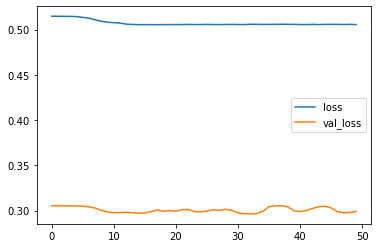

In [36]:
plt.plot(hist.history['loss'],label='loss')
plt.plot(hist.history['val_loss'],label='val_loss')
plt.legend()

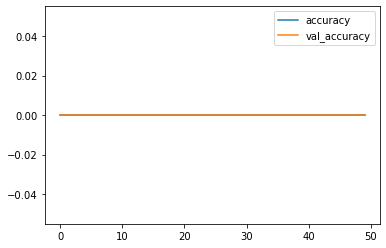

In [37]:
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.legend()

# --------------------------------------------------------------------------------------

In [ ]:
K.clear_session()   #clean slate

idx = 0
#start = time.time()

for X_train, y_train in zip(Xs_train, ys_train):    
    print("TASK " + str(idx + 1))
    
    X_train = np.array([np.array(xi) for xi in X_train], dtype=object)
    X_train = X_train.reshape(X_train.shape[0],X_train[0].shape[0],X_train[0].shape[2], 1)
    input_shape = X_train.shape[1:]
    
    y_train = np.array(y_train)
    y_train = y_train.reshape(y_train.shape[0],-1)     
    output_shape = y_train.shape[1]
#     y_tensor = tf.convert_to_tensor(y_train, dtype=tf.int64) 
    
    X_train = np.asarray(X_train).astype(np.int)

    y_train = np.asarray(y_train).astype(np.int)
    
    if input_shape[0] < 6 or input_shape[1] < 6:
            kernel = 1
    else: kernel = 2
    
    
    
    
    m = basic_model(input_shape, output_shape, kernel)
    
    m.compile(optimizer='adam', 
              loss='mean_squared_error', #### this one needs to be adjusted
              metrics=['accuracy'])  

    callback = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5)

    hist4 = m.fit(X_train,
                  y_tensor,
                  epochs=10,               ### this can be much smaller cause each task has only 5 or so inputs???
                  batch_size=200,          ### this can be much smaller cause each task has only 5 or so inputs???
                  validation_split=0.2) 
    
    
    idx += 1
#    print("Total time: " + str(np.round(end - start, 1)) + " s" + "\n")
    
    
    
#
# epochs: how many times the whole dataset has passed through the model

In [ ]:
a = min([len(Xs_train[125][x]) for x in range(len(Xs_train[125]))]) # y axis

In [ ]:
a

In [ ]:
b = min([len(Xs_train[125][x][0]) for x in range(len(Xs_train[125]))])

In [ ]:
b

In [ ]:
min(a,b)

In [ ]:
[len(Xs_train[125][x]) for x in range(len(Xs_train[125]))].append([len(Xs_train[125][x][0]) for x in range(len(Xs_train[125]))])